# Final Project
### Stephen Newberry
### ECE 504

This project builds on a couple of previous ones in which rectangular waveguide electromagnetic field data is used to train a machine learning algorithm.
That ML model can then identify modal parameters (m, n), as well as the field component, propagation mode, and frequency for previously unseen data.
The modal configurations are restricted to (m, n) between 1 and 3.
This project also shows the performance of the machine learning models within the presence of exponential-distributed noise.

### This notebook contains the final code for the project

In [1]:
# Make sure we auto-reload for the helper functions
%load_ext autoreload
%autoreload 2
# Imports
import p4_functions as p4 # These are custom functions to clean up the notebook a bit
# ------------------------------------------- #
import numpy as np
import pandas as pd
import cmath
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

# Configure logging
import logging
logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)

# Configure plot size
plt.rcParams['figure.dpi'] = 300

First, just make sure the helper function file works

In [2]:
p4.test_function(4) #Just to make sure I am writing and importing my functions with the correct syntax

It Works 4 times!


In [3]:
 # use this data to show the function works
example_training_data = p4.create_training_data(1)

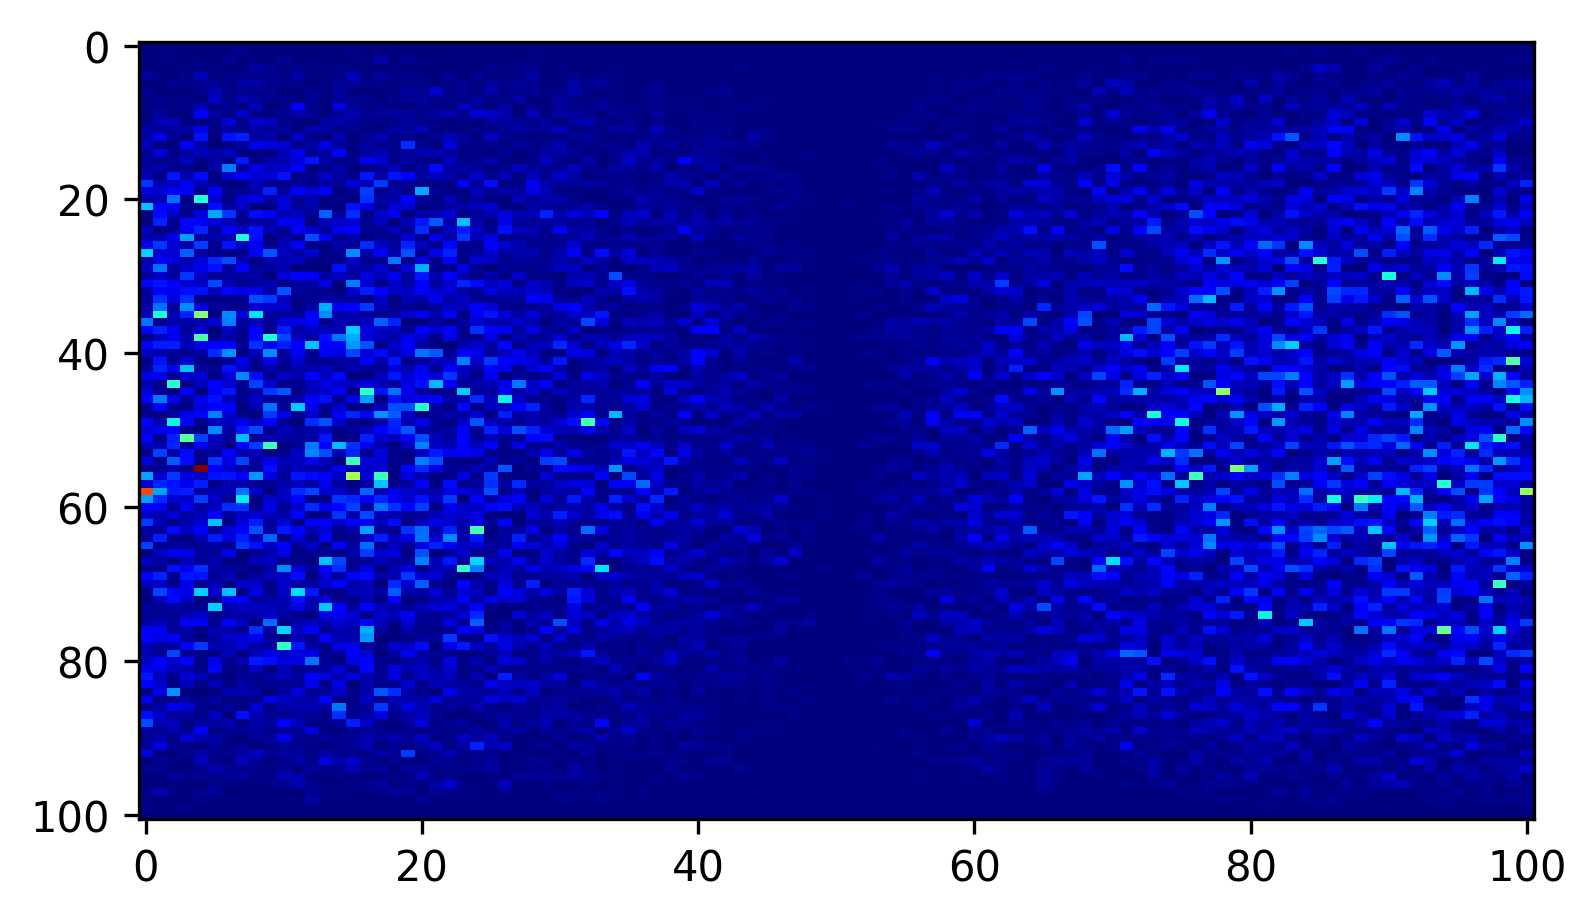

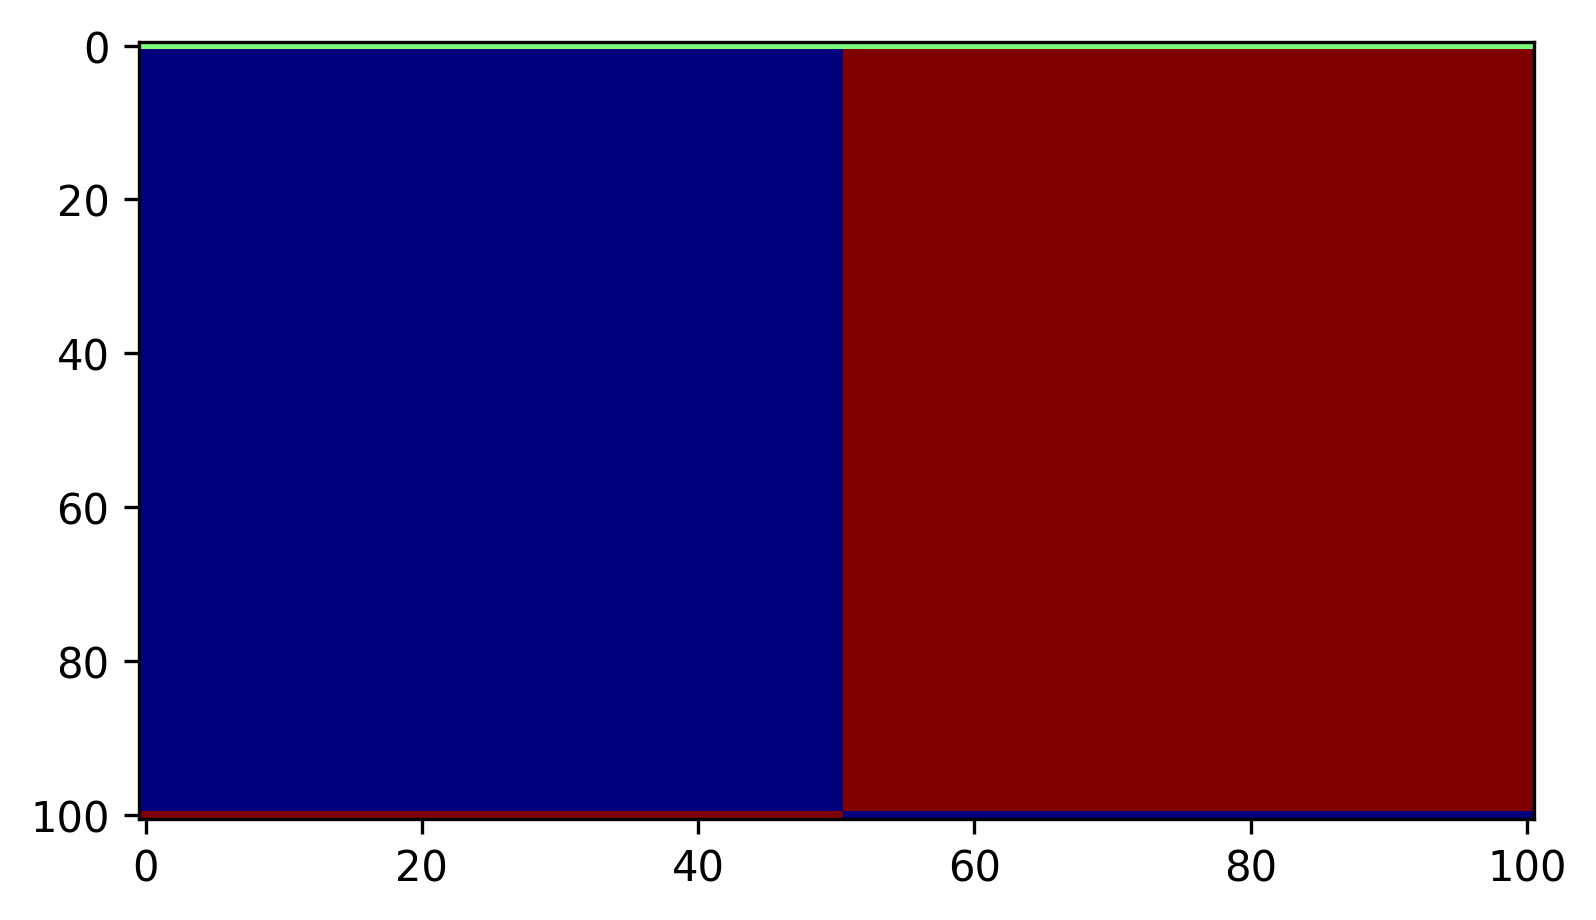

In [4]:
for i in range(len(example_training_data.mag_rad)): # Include these plots as some example training data
    aspect_ratio = example_training_data.width[i]/example_training_data.height[i]
    plt.imshow(abs((example_training_data.mag_rad[i])), aspect=1/aspect_ratio, cmap='jet')
    plt.show()
    plt.imshow(np.angle((example_training_data.mag_rad[i])), aspect=1/aspect_ratio, cmap='jet')
    plt.show()

In [5]:
noisy_training_data = example_training_data.copy()
# Report some statistics:
print(f"Mean of magnitude data: {np.mean(abs(noisy_training_data.mag_rad[0]))}")
print(f"Mean of phase data: {np.mean(np.angle(noisy_training_data.mag_rad[0]))}")

noisy_training_data['mag_rad'][0] = p4.add_noise(noisy_training_data['mag_rad'][0], .91, "exponential")
# noisy_training_data['mag_rad'][0].shape

Mean of magnitude data: 229.99087289789028
Mean of phase data: -0.015090485249083406


c:\users\steph\documents\education\class04_2022s_ece504\homework\venv\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


1


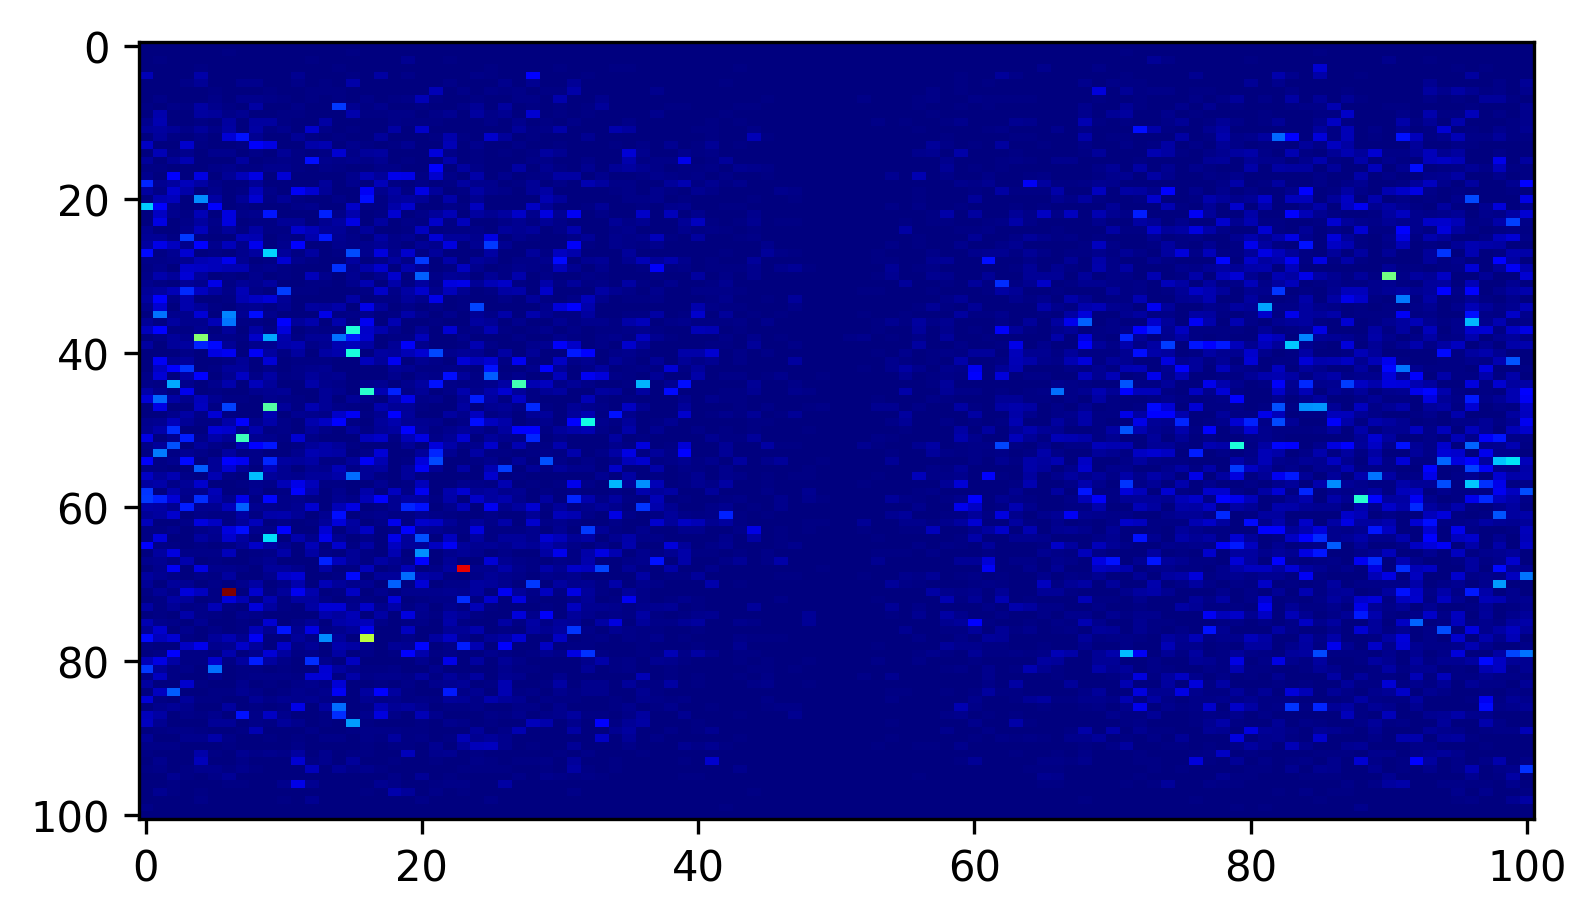

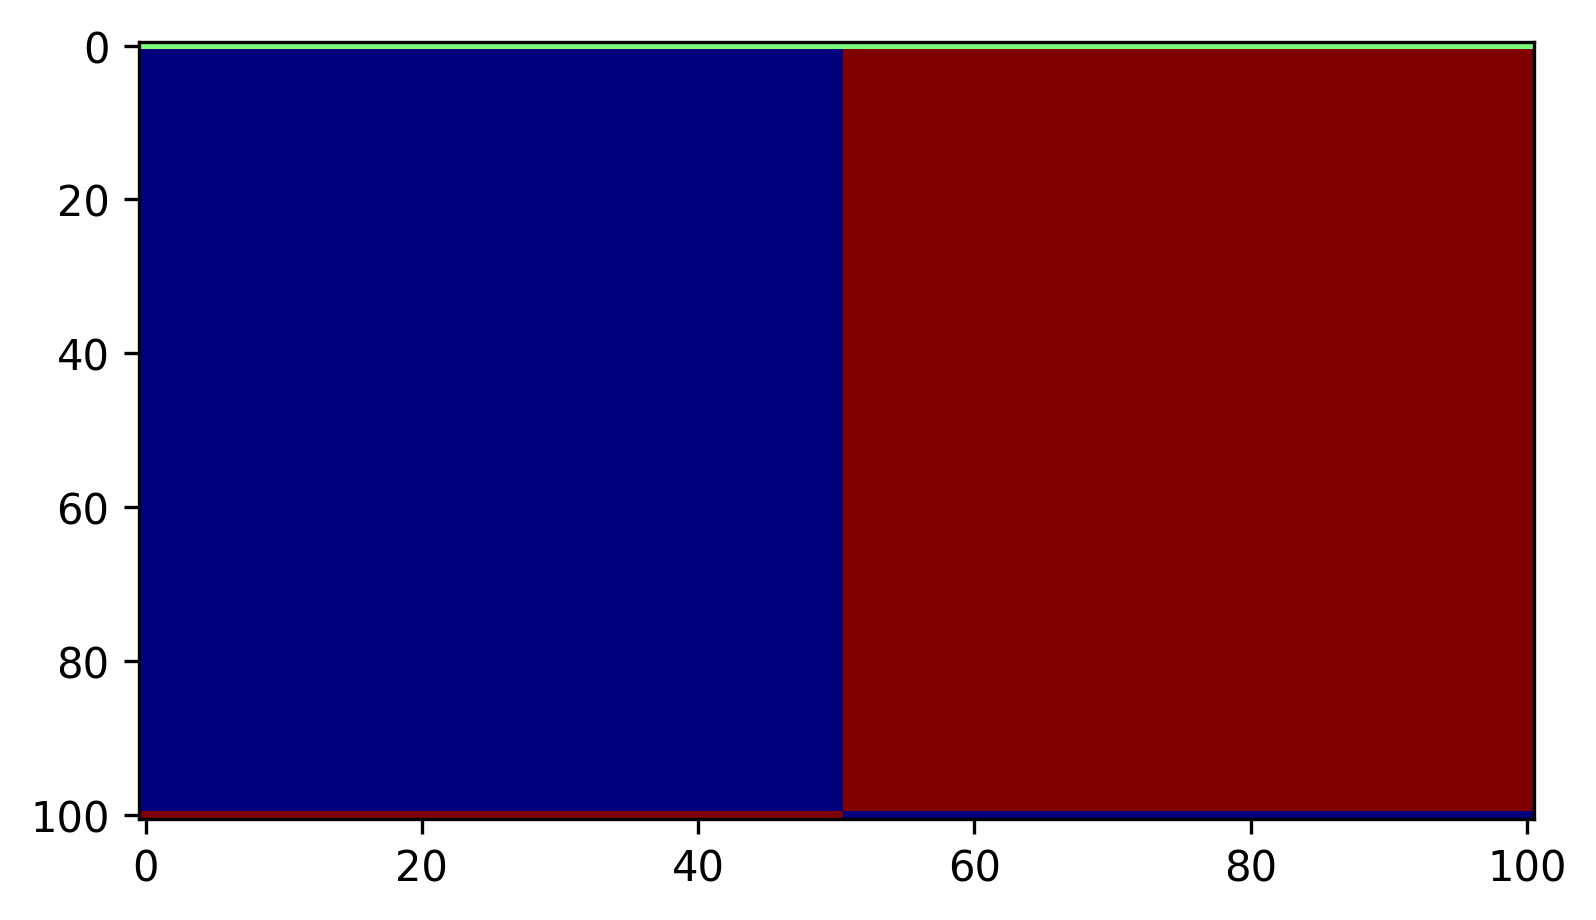

In [6]:
print(len(noisy_training_data))
for i in range(len(noisy_training_data.mag_rad)): # Include these plots as some example training data
    aspect_ratio = noisy_training_data.width[i]/noisy_training_data.height[i]
    plt.imshow(abs((noisy_training_data.mag_rad[i])), aspect=1/aspect_ratio, cmap='jet')
    plt.show()
    plt.imshow(np.angle((noisy_training_data.mag_rad[i])), aspect=1/aspect_ratio, cmap='jet')
    plt.show()

In [7]:
# Create training data set. Expect to need at least 1M points.
generate_training_set = False # Set true if needed to generate. Takes a few hours.
generate_test_set = False
num_training_points = int(25000)

if generate_training_set:
    training_data = p4.create_training_data(num_training_points)
    training_data.to_pickle("./training_data_compressed.pkl", compression={'method': 'gzip', 'compresslevel': 1, 'mtime': 1})
else:
    training_data = pd.read_pickle("./training_data_compressed.pkl", compression={'method': 'gzip', 'compresslevel': 1, 'mtime': 1})

if generate_test_set:
    test_data = p4.create_training_data(int(num_training_points/5)) # 20 % for testing
    test_data.to_pickle("./test_data_compressed.pkl", compression={'method': 'gzip', 'compresslevel': 1, 'mtime': 1})
else:
    test_data = pd.read_pickle("./test_data_compressed.pkl", compression={'method': 'gzip', 'compresslevel': 1, 'mtime': 1})


In [8]:
# Create noisy data sets
training_data_noise_0p01 = p4.noise_gen_data(training_data, 0.01)
training_data_noise_0p10 = p4.noise_gen_data(training_data, 0.1)
training_data_noise_1p00 = p4.noise_gen_data(training_data, 1.0)
training_data_noise_10p0 = p4.noise_gen_data(training_data, 10.0)
training_data_noise_100p = p4.noise_gen_data(training_data, 100.0)
test_data_noise_0p01 = p4.noise_gen_data(test_data, 0.01)
test_data_noise_0p10 = p4.noise_gen_data(test_data, 0.1)
test_data_noise_1p00 = p4.noise_gen_data(test_data, 1.0)
test_data_noise_10p0 = p4.noise_gen_data(test_data, 10.0)
test_data_noise_100p = p4.noise_gen_data(test_data, 100.0)

C:\Users\steph\Documents\Education\CLASS04_2022S_ECE504\Projects\ece504-final-waveguide-ml\Code\p4_functions.py:282: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output_data['mag_rad'][i] = add_noise(output_data['mag_rad'][i], std_deviation, "exponential")


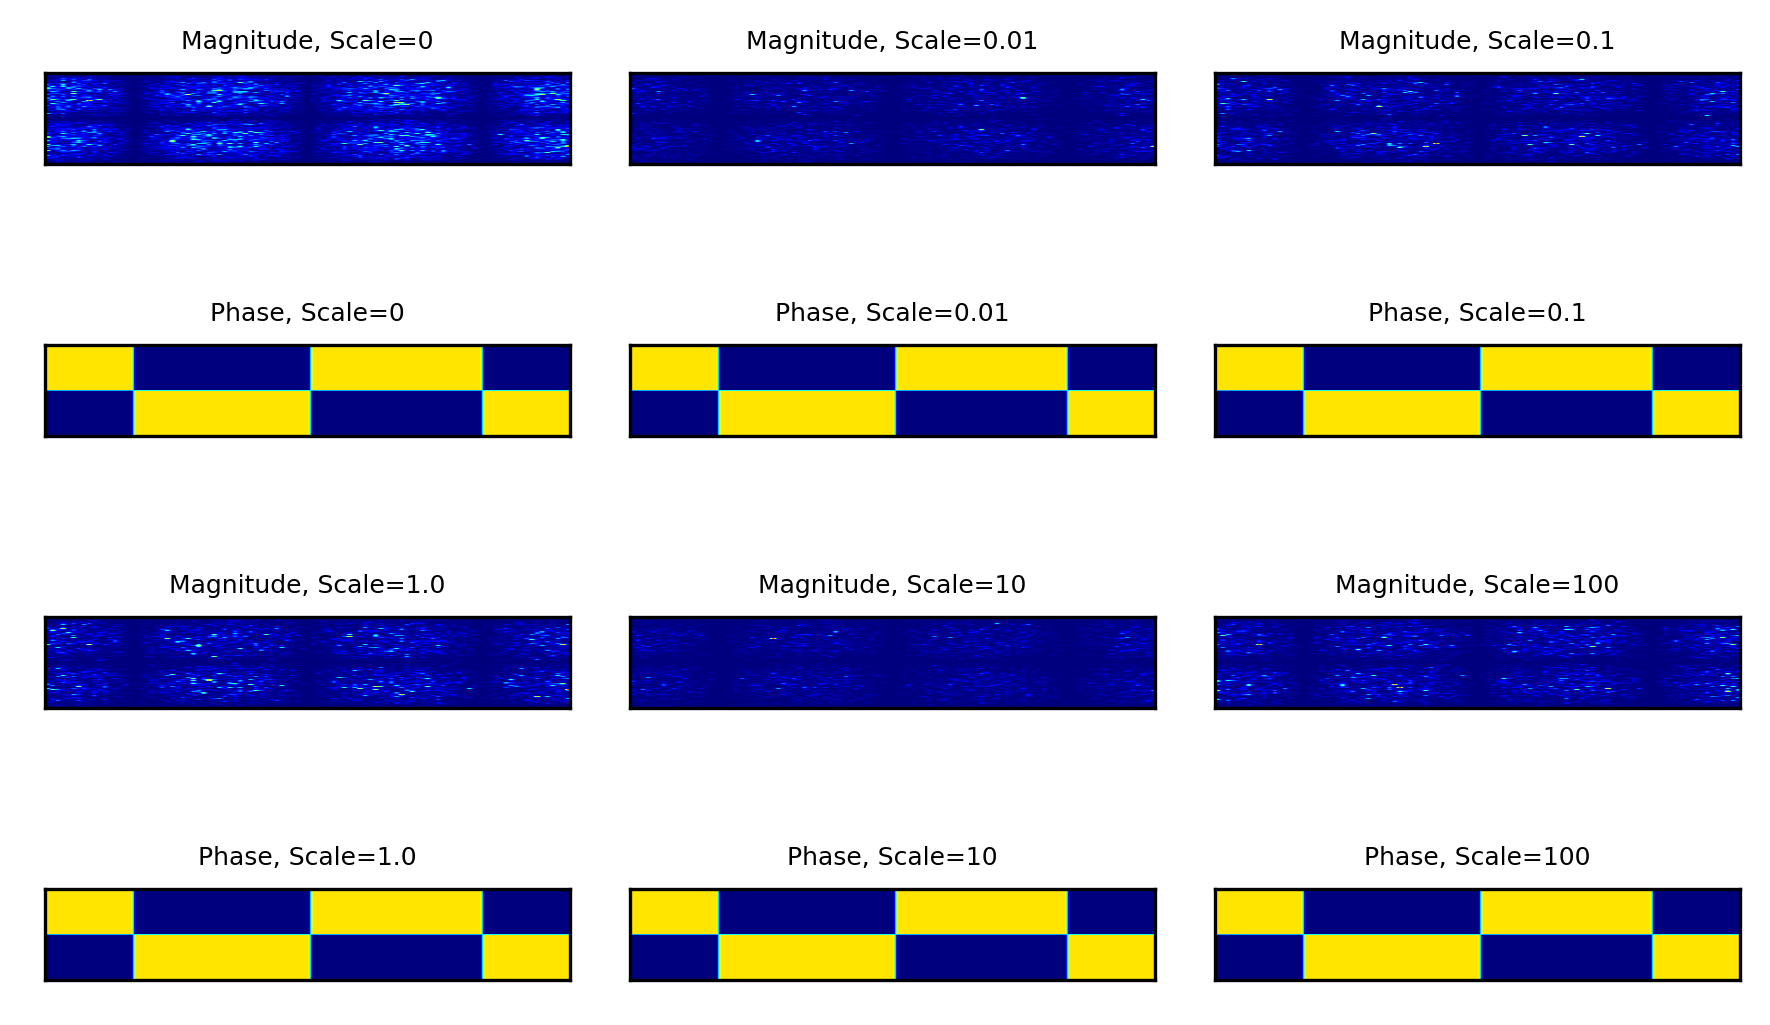

In [9]:
# Plot a comparison
sample_index = np.random.randint(0, 1000)
aspect_ratio = training_data.width[sample_index]/training_data.height[sample_index]

fig = plt.figure()

plt.subplot(4, 3, 1)
plt.xticks([])
plt.yticks([])
plt.title("Magnitude, Scale=0",fontdict={'fontsize': 6})
plt.imshow(abs((training_data.mag_rad[sample_index])), aspect=1/aspect_ratio, cmap='jet')
plt.subplot(4, 3, 4)
plt.xticks([])
plt.yticks([])
plt.title("Phase, Scale=0",fontdict={'fontsize': 6})
plt.imshow(np.angle((training_data.mag_rad[sample_index])), aspect=1/aspect_ratio, cmap='jet')

plt.subplot(4, 3, 2)
plt.xticks([])
plt.yticks([])
plt.title("Magnitude, Scale=0.01",fontdict={'fontsize': 6})
plt.imshow(abs((training_data_noise_0p01.mag_rad[sample_index])), aspect=1/aspect_ratio, cmap='jet')
plt.subplot(4, 3, 5)
plt.xticks([])
plt.yticks([])
plt.title("Phase, Scale=0.01",fontdict={'fontsize': 6})
plt.imshow(np.angle((training_data_noise_0p01.mag_rad[sample_index])), aspect=1/aspect_ratio, cmap='jet')

plt.subplot(4, 3, 3)
plt.xticks([])
plt.yticks([])
plt.title("Magnitude, Scale=0.1",fontdict={'fontsize': 6})
plt.imshow(abs((training_data_noise_0p10.mag_rad[sample_index])), aspect=1/aspect_ratio, cmap='jet')
plt.subplot(4, 3, 6)
plt.xticks([])
plt.yticks([])
plt.title("Phase, Scale=0.1",fontdict={'fontsize': 6})
plt.imshow(np.angle((training_data_noise_0p10.mag_rad[sample_index])), aspect=1/aspect_ratio, cmap='jet')

plt.subplot(4, 3, 7)
plt.xticks([])
plt.yticks([])
plt.title("Magnitude, Scale=1.0",fontdict={'fontsize': 6})
plt.imshow(abs((training_data_noise_1p00.mag_rad[sample_index])), aspect=1/aspect_ratio, cmap='jet')
plt.subplot(4, 3, 10)
plt.xticks([])
plt.yticks([])
plt.title("Phase, Scale=1.0",fontdict={'fontsize': 6})
plt.imshow(np.angle((training_data_noise_1p00.mag_rad[sample_index])), aspect=1/aspect_ratio, cmap='jet')

plt.subplot(4, 3, 8)
plt.xticks([])
plt.yticks([])
plt.title("Magnitude, Scale=10",fontdict={'fontsize': 6})
plt.imshow(abs((training_data_noise_10p0.mag_rad[sample_index])), aspect=1/aspect_ratio, cmap='jet')
plt.subplot(4, 3, 11)
plt.xticks([])
plt.yticks([])
plt.title("Phase, Scale=10",fontdict={'fontsize': 6})
plt.imshow(np.angle((training_data_noise_10p0.mag_rad[sample_index])), aspect=1/aspect_ratio, cmap='jet')

plt.subplot(4, 3, 9)
plt.xticks([])
plt.yticks([])
plt.title("Magnitude, Scale=100",fontdict={'fontsize': 6})
plt.imshow(abs((training_data_noise_100p.mag_rad[sample_index])), aspect=1/aspect_ratio, cmap='jet')
plt.subplot(4, 3, 12)
plt.xticks([])
plt.yticks([])
plt.title("Phase, Scale=100",fontdict={'fontsize': 6})
plt.imshow(np.angle((training_data_noise_100p.mag_rad[sample_index])), aspect=1/aspect_ratio, cmap='jet')


plt.tight_layout()
# plt.subplots_adjust(wspace=.1, hspace=1)
plt.show()



            # Machine Learning Algorithm

In [10]:
# Create input for the mag/angle data...
# CANNOT be complex. Must use separate magnitude and phase data
input_mag = keras.layers.Input(shape=[101,101], name="input_mag")
input_angle = keras.layers.Input(shape=[101,101], name="input_angle")
input_width = keras.layers.Input(shape=[1], name="input_width")
input_height = keras.layers.Input(shape=[1], name="input_height")

hidden_mag_flat = keras.layers.Flatten()(input_mag) # Should this flatten go right after input?
hidden_mag_norm = keras.layers.BatchNormalization()(hidden_mag_flat)
hidden_mag_1 = keras.layers.Dense(1024, activation="relu")(hidden_mag_norm)
hidden_mag_2 = keras.layers.Dense(500, activation="relu")(hidden_mag_1)
hidden_mag_3 = keras.layers.Dense(100, activation="relu")(hidden_mag_2)

hidden_angle_flat = keras.layers.Flatten()(input_angle)
hidden_angle_norm = keras.layers.BatchNormalization()(hidden_angle_flat)
hidden_angle_1 = keras.layers.Dense(1024, activation="relu")(hidden_angle_norm)
hidden_angle_2 = keras.layers.Dense(500, activation="relu")(hidden_angle_1)
hidden_angle_3 = keras.layers.Dense(100, activation="relu")(hidden_angle_2)

concat_w_h = keras.layers.concatenate([input_width, input_height])
hidden_wh_1 = keras.layers.Dense(50, activation="relu")(concat_w_h)
hidden_wh_2 = keras.layers.Dense(50, activation="relu")(hidden_wh_1)

concat_all = keras.layers.concatenate([hidden_mag_2, hidden_angle_2, hidden_wh_2])
hidden_all_1 = keras.layers.Dense(500, activation="relu")(concat_all)
hidden_all_2 = keras.layers.Dense(50, activation="relu")(hidden_all_1)

output_m = keras.layers.Dense(3, activation="softmax", name="output_m")(hidden_all_2) # Considered classification, 11 options
output_n = keras.layers.Dense(3, activation="softmax", name="output_n")(hidden_all_2) # Considered classification, 11 options
output_mode = keras.layers.Dense(1, activation="sigmoid", name="output_mode")(hidden_all_2) # Considered classification, 2 options (TE/TM)

output_freq_extra = keras.layers.Dense(70, activation="relu")(hidden_all_2)
output_freq_extra_1 = keras.layers.Dense(50, activation="relu")(output_freq_extra)
output_freq_extra_2 = keras.layers.Dense(50, activation="relu")(output_freq_extra_1)
output_freq_extra_3 = keras.layers.Dense(50, activation="relu")(output_freq_extra_2)
output_freq = keras.layers.Dense(1, activation="leaky_relu", name="output_freq")(output_freq_extra_3)

output_component = keras.layers.Dense(6, activation="softmax", name="output_comp")(hidden_all_2) # Considered classification, 11 options
model = keras.Model(inputs=[input_mag, input_angle, input_width, input_height], outputs=[output_m, output_n, output_mode, output_freq, output_component])

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_mag (InputLayer)          [(None, 101, 101)]   0                                            
__________________________________________________________________________________________________
input_angle (InputLayer)        [(None, 101, 101)]   0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 10201)        0           input_mag[0][0]                  
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 10201)        0           input_angle[0][0]                
______________________________________________________________________________________________

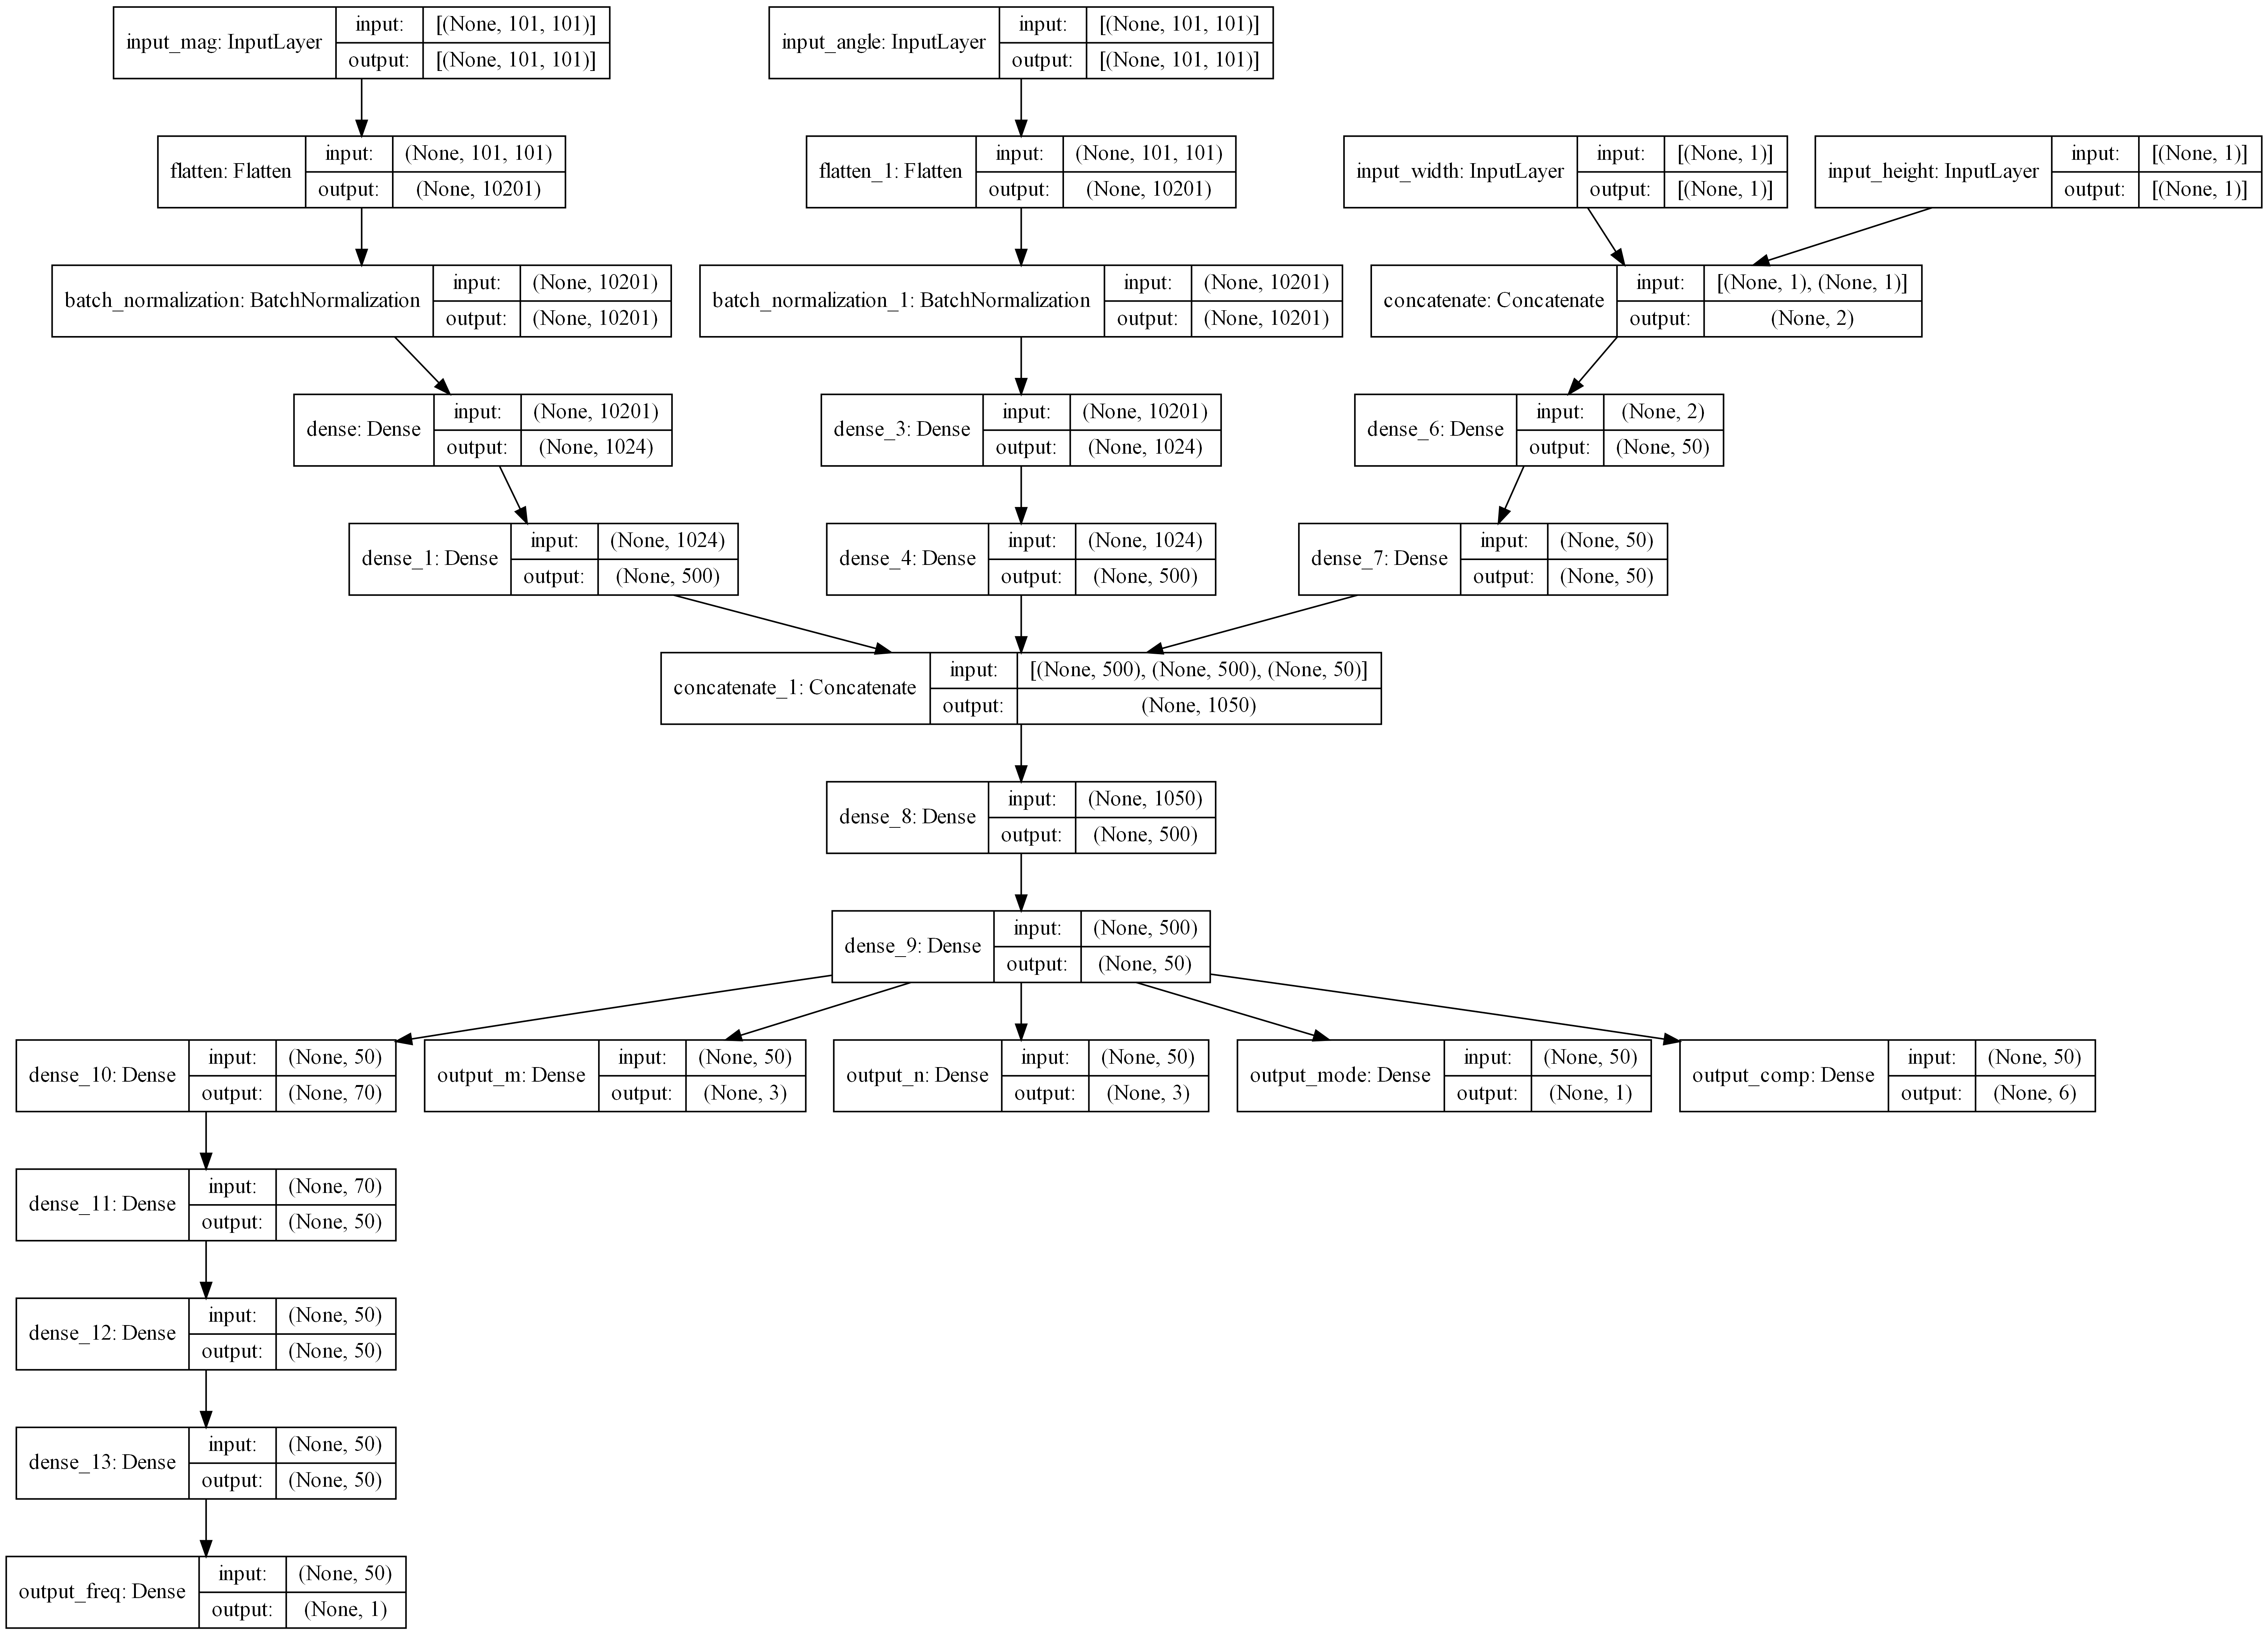

In [12]:
# Use this plot for documentation, but will have to figure out how to cross columns.
keras.utils.plot_model(model, show_shapes=True, rankdir="TB", dpi=300, show_layer_names=True, layer_range=None)

In [13]:
# Loss functions as recommended in Keras documentation
model.compile(loss = ['sparse_categorical_crossentropy', 'sparse_categorical_crossentropy', 'binary_crossentropy', 'mean_squared_logarithmic_error', 'sparse_categorical_crossentropy'],
              optimizer=keras.optimizers.Adam())

In [14]:
# Data preparation
reprep_data = True

if reprep_data:
    in_mag_train = []
    for i in range(len(training_data.mag_rad)):
        in_mag_train.append(abs(training_data.mag_rad[i]))
    in_mag_train = np.asarray(in_mag_train)
    in_angle_train = []
    for i in range(len(training_data.mag_rad)):
        in_angle_train.append(tf.convert_to_tensor(np.angle(training_data.mag_rad[i])))
    in_angle_train = np.asarray(in_angle_train)
    in_width_train = tf.convert_to_tensor(training_data.width.values)
    in_height_train = tf.convert_to_tensor(training_data.height.values)
    out_m_train = tf.convert_to_tensor(training_data.m.values.astype(np.int))
    out_n_train = tf.convert_to_tensor(training_data.n.values.astype(np.int))
    out_mode_train = tf.convert_to_tensor(training_data['mode'].values.astype(np.int))
    out_freq_train = tf.convert_to_tensor(training_data.freq.values)
    out_component_train = tf.convert_to_tensor(training_data.component.values.astype(np.int))

    in_mag_test = []
    for i in range(len(test_data.mag_rad)):
        in_mag_test.append(tf.convert_to_tensor(abs(test_data.mag_rad[i])))
    in_mag_test = np.asarray(in_mag_test)
    in_angle_test = []
    for i in range(len(test_data.mag_rad)):
        in_angle_test.append(tf.convert_to_tensor(np.angle(test_data.mag_rad[i])))
    in_angle_test = np.asarray(in_angle_test)
    in_width_test = tf.convert_to_tensor(test_data.width.values)
    in_height_test = tf.convert_to_tensor(test_data.height.values)
    out_m_test = tf.convert_to_tensor(test_data.m.values.astype(np.int))
    out_n_test = tf.convert_to_tensor(test_data.n.values.astype(np.int))
    out_mode_test = tf.convert_to_tensor(test_data['mode'].values.astype(np.int))
    out_freq_test = tf.convert_to_tensor(test_data.freq.values)
    out_component_test = tf.convert_to_tensor(test_data.component.values.astype(np.int))

In [15]:
train_model = False

if train_model:
    history = model.fit([[in_mag_train], [in_angle_train], in_width_train, in_height_train],
                        [out_m_train, out_n_train, out_mode_train, out_freq_train, out_component_train],
                        epochs = 1000,
                        batch_size=1000,
                        validation_data=([[in_mag_test], [in_angle_test], in_width_test, in_height_test],
                                         [out_m_test, out_n_test, out_mode_test, out_freq_test, out_component_test]))
    model.save('./keras_model')
else:
    model = keras.models.load_model('./keras_model')

In [16]:
# Plot loss
if train_model:
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    # plt.gca().set_ylim(.001, 1)
    plt.yscale("log")
    plt.legend(bbox_to_anchor=(1.4, .5), loc='right', borderaxespad=0)
    plt.show()

In [17]:
# Need to perform an evaluation
# Create eval data, 1k samples
eval_data = p4.create_training_data(1000)

eval_data_noise_0p01 = p4.noise_gen_data(eval_data, 0.01)
eval_data_noise_0p10 = p4.noise_gen_data(eval_data, 0.1)
eval_data_noise_1p00 = p4.noise_gen_data(eval_data, 1.0)
eval_data_noise_10p0 = p4.noise_gen_data(eval_data, 10.0)
eval_data_noise_100p = p4.noise_gen_data(eval_data, 100.0)

In [18]:
# Prep eval data
# Prepare test data
in_mag_eval0 = []
for i in range(len(eval_data.mag_rad)):
    in_mag_eval0.append(abs(eval_data.mag_rad[i]))
in_mag_eval0 = np.asarray(in_mag_eval0)
in_angle_eval0 = []
for i in range(len(eval_data.mag_rad)):
    in_angle_eval0.append(tf.convert_to_tensor(np.angle(eval_data.mag_rad[i])))
in_angle_eval0 = np.asarray(in_angle_eval0)
in_width_eval0 = tf.convert_to_tensor(eval_data.width.values)
in_height_eval0 = tf.convert_to_tensor(eval_data.height.values)
out_m_eval0 = tf.convert_to_tensor(eval_data.m.values.astype(np.int))
out_n_eval0 = tf.convert_to_tensor(eval_data.n.values.astype(np.int))
out_mode_eval0 = tf.convert_to_tensor(eval_data['mode'].values.astype(np.int))
out_freq_eval0 = tf.convert_to_tensor(eval_data.freq.values)
out_component_eval0 = tf.convert_to_tensor(eval_data.component.values.astype(np.int))

in_mag_eval1 = []
for i in range(len(eval_data_noise_0p01.mag_rad)):
    in_mag_eval1.append(abs(eval_data_noise_0p01.mag_rad[i]))
in_mag_eval1 = np.asarray(in_mag_eval1)
in_angle_eval1 = []
for i in range(len(eval_data_noise_0p01.mag_rad)):
    in_angle_eval1.append(tf.convert_to_tensor(np.angle(eval_data_noise_0p01.mag_rad[i])))
in_angle_eval1 = np.asarray(in_angle_eval1)
in_width_eval1 = tf.convert_to_tensor(eval_data_noise_0p01.width.values)
in_height_eval1 = tf.convert_to_tensor(eval_data_noise_0p01.height.values)
out_m_eval1 = tf.convert_to_tensor(eval_data_noise_0p01.m.values.astype(np.int))
out_n_eval1 = tf.convert_to_tensor(eval_data_noise_0p01.n.values.astype(np.int))
out_mode_eval1 = tf.convert_to_tensor(eval_data_noise_0p01['mode'].values.astype(np.int))
out_freq_eval1 = tf.convert_to_tensor(eval_data_noise_0p01.freq.values)
out_component_eval1 = tf.convert_to_tensor(eval_data_noise_0p01.component.values.astype(np.int))

in_mag_eval2 = []
for i in range(len(eval_data_noise_0p10.mag_rad)):
    in_mag_eval2.append(abs(eval_data_noise_0p10.mag_rad[i]))
in_mag_eval2 = np.asarray(in_mag_eval2)
in_angle_eval2 = []
for i in range(len(eval_data_noise_0p10.mag_rad)):
    in_angle_eval2.append(tf.convert_to_tensor(np.angle(eval_data_noise_0p10.mag_rad[i])))
in_angle_eval2 = np.asarray(in_angle_eval2)
in_width_eval2 = tf.convert_to_tensor(eval_data_noise_0p10.width.values)
in_height_eval2 = tf.convert_to_tensor(eval_data_noise_0p10.height.values)
out_m_eval2 = tf.convert_to_tensor(eval_data_noise_0p10.m.values.astype(np.int))
out_n_eval2 = tf.convert_to_tensor(eval_data_noise_0p10.n.values.astype(np.int))
out_mode_eval2 = tf.convert_to_tensor(eval_data_noise_0p10['mode'].values.astype(np.int))
out_freq_eval2 = tf.convert_to_tensor(eval_data_noise_0p10.freq.values)
out_component_eval2 = tf.convert_to_tensor(eval_data_noise_0p10.component.values.astype(np.int))

in_mag_eval3 = []
for i in range(len(eval_data_noise_1p00.mag_rad)):
    in_mag_eval3.append(abs(eval_data_noise_1p00.mag_rad[i]))
in_mag_eval3 = np.asarray(in_mag_eval3)
in_angle_eval3 = []
for i in range(len(eval_data_noise_1p00.mag_rad)):
    in_angle_eval3.append(tf.convert_to_tensor(np.angle(eval_data_noise_1p00.mag_rad[i])))
in_angle_eval3 = np.asarray(in_angle_eval3)
in_width_eval3 = tf.convert_to_tensor(eval_data_noise_1p00.width.values)
in_height_eval3 = tf.convert_to_tensor(eval_data_noise_1p00.height.values)
out_m_eval3 = tf.convert_to_tensor(eval_data_noise_1p00.m.values.astype(np.int))
out_n_eval3 = tf.convert_to_tensor(eval_data_noise_1p00.n.values.astype(np.int))
out_mode_eval3 = tf.convert_to_tensor(eval_data_noise_1p00['mode'].values.astype(np.int))
out_freq_eval3 = tf.convert_to_tensor(eval_data_noise_1p00.freq.values)
out_component_eval3 = tf.convert_to_tensor(eval_data_noise_1p00.component.values.astype(np.int))

in_mag_eval4 = []
for i in range(len(eval_data_noise_10p0.mag_rad)):
    in_mag_eval4.append(abs(eval_data_noise_10p0.mag_rad[i]))
in_mag_eval4 = np.asarray(in_mag_eval4)
in_angle_eval4 = []
for i in range(len(eval_data_noise_10p0.mag_rad)):
    in_angle_eval4.append(tf.convert_to_tensor(np.angle(eval_data_noise_10p0.mag_rad[i])))
in_angle_eval4 = np.asarray(in_angle_eval4)
in_width_eval4 = tf.convert_to_tensor(eval_data_noise_10p0.width.values)
in_height_eval4 = tf.convert_to_tensor(eval_data_noise_10p0.height.values)
out_m_eval4 = tf.convert_to_tensor(eval_data_noise_10p0.m.values.astype(np.int))
out_n_eval4 = tf.convert_to_tensor(eval_data_noise_10p0.n.values.astype(np.int))
out_mode_eval4 = tf.convert_to_tensor(eval_data_noise_10p0['mode'].values.astype(np.int))
out_freq_eval4 = tf.convert_to_tensor(eval_data_noise_10p0.freq.values)
out_component_eval4 = tf.convert_to_tensor(eval_data_noise_10p0.component.values.astype(np.int))

in_mag_eval5 = []
for i in range(len(eval_data_noise_100p.mag_rad)):
    in_mag_eval5.append(abs(eval_data_noise_100p.mag_rad[i]))
in_mag_eval5 = np.asarray(in_mag_eval5)
in_angle_eval5 = []
for i in range(len(eval_data_noise_100p.mag_rad)):
    in_angle_eval5.append(tf.convert_to_tensor(np.angle(eval_data_noise_100p.mag_rad[i])))
in_angle_eval5 = np.asarray(in_angle_eval5)
in_width_eval5 = tf.convert_to_tensor(eval_data_noise_100p.width.values)
in_height_eval5 = tf.convert_to_tensor(eval_data_noise_100p.height.values)
out_m_eval5 = tf.convert_to_tensor(eval_data_noise_100p.m.values.astype(np.int))
out_n_eval5 = tf.convert_to_tensor(eval_data_noise_100p.n.values.astype(np.int))
out_mode_eval5 = tf.convert_to_tensor(eval_data_noise_100p['mode'].values.astype(np.int))
out_freq_eval5 = tf.convert_to_tensor(eval_data_noise_100p.freq.values)
out_component_eval5 = tf.convert_to_tensor(eval_data_noise_100p.component.values.astype(np.int))

In [19]:
# Evaluate Model
score0 = model.evaluate([[in_mag_eval0], [in_angle_eval0], in_width_eval0, in_height_eval0],
                       [out_m_eval0, out_n_eval0, out_mode_eval0, out_freq_eval0, out_component_eval0], verbose=1)

score1 = model.evaluate([[in_mag_eval1], [in_angle_eval1], in_width_eval1, in_height_eval1],
                        [out_m_eval1, out_n_eval1, out_mode_eval1, out_freq_eval1, out_component_eval1], verbose=1)

score2 = model.evaluate([[in_mag_eval2], [in_angle_eval2], in_width_eval2, in_height_eval2],
                        [out_m_eval2, out_n_eval2, out_mode_eval2, out_freq_eval2, out_component_eval2], verbose=1)

score3 = model.evaluate([[in_mag_eval3], [in_angle_eval3], in_width_eval3, in_height_eval3],
                        [out_m_eval3, out_n_eval3, out_mode_eval3, out_freq_eval3, out_component_eval3], verbose=1)

score4 = model.evaluate([[in_mag_eval4], [in_angle_eval4], in_width_eval4, in_height_eval4],
                        [out_m_eval4, out_n_eval4, out_mode_eval4, out_freq_eval4, out_component_eval4], verbose=1)

score5 = model.evaluate([[in_mag_eval5], [in_angle_eval5], in_width_eval5, in_height_eval5],
                        [out_m_eval5, out_n_eval5, out_mode_eval5, out_freq_eval5, out_component_eval5], verbose=1)

print(f"Score 0: {score0}")
print(f"Score 1: {score1}")
print(f"Score 2: {score2}")
print(f"Score 3: {score3}")
print(f"Score 4: {score4}")
print(f"Score 5: {score5}")

32/32 [==============================] - 0s 7ms/step - loss: 97.6935 - output_m_loss: 3.0997 - output_n_loss: 25.1166 - output_mode_loss: 4.1737 - output_freq_loss: 1.4045 - output_comp_loss: 63.8989
Score 0: [5.607844829559326, 0.0002047528832918033, 8.229438321905036e-07, 2.7545599937438965, 0.45315882563591003, 2.399920701980591]
Score 1: [5.606805324554443, 0.00019654311472550035, 8.349838935828302e-07, 2.7545604705810547, 0.45212024450302124, 2.3999271392822266]
Score 2: [5.607017993927002, 0.000197142522665672, 8.333149708050769e-07, 2.7545599937438965, 0.45233353972435, 2.3999264240264893]
Score 3: [5.607874870300293, 0.00020562269492074847, 8.224669727496803e-07, 2.7545599937438965, 0.45318862795829773, 2.3999204635620117]
Score 4: [5.673380374908447, 0.0003269183507654816, 7.97075983882678e-07, 2.7545595169067383, 0.48632848262786865, 2.4321651458740234]
Score 5: [97.69352722167969, 3.0997486114501953, 25.116573333740234, 4.173731803894043, 1.404541015625, 63.898929595947266]


m error: 0
n error: 0
mode error: 171
comp error: 153
mean freq error: 65.13991290251002
median freq error: 20.66480827331543
min freq error: -75.13674926757812
max freq error: 1559.773193359375


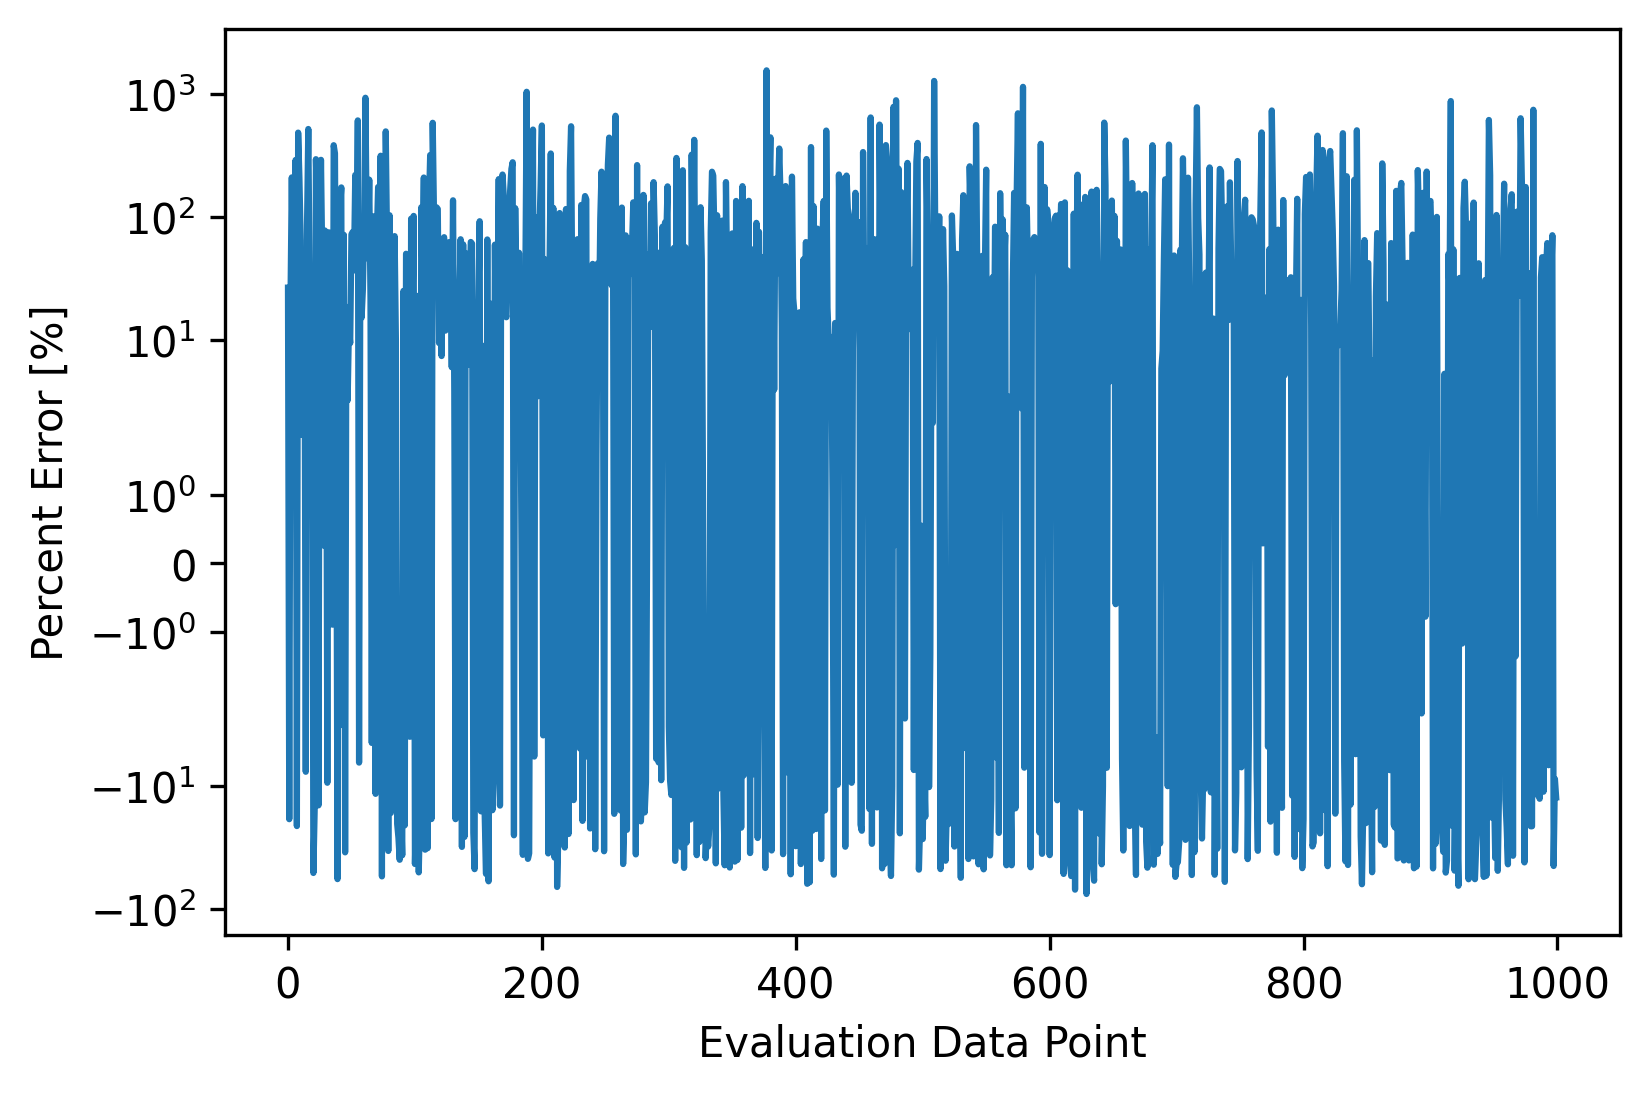

In [20]:
# in_width_eval[1]
# # model.predict([[te_mag], [te_angle], te_width, te_height])
# for i in range(len(in_mag_eval0)):
#     mag_temp = in_mag_eval0[i]
#     ang_temp = in_angle_eval0[i]
#     wid_temp = in_width_eval0[i]
#     hgt_temp = in_height_eval0[i]

eval0_predictions = model.predict([[in_mag_eval0], [in_angle_eval0], in_width_eval0, in_height_eval0])
    # model.predict([[mag_temp], [ang_temp], wid_temp, hgt_temp])

sum_m_error0 = 0
sum_n_error0 = 0
sum_mode_error0 = 0
sum_comp_error0 = 0

for i in range(len(eval0_predictions[0])):
    eval_pred_m = np.argmax(eval0_predictions[0][i])
    # print(f"{eval_pred_m} - {eval_data.m[i]}")
    if eval_pred_m != (eval_data.m[i]):
        sum_m_error0 += 1

for i in range(len(eval0_predictions[1])):
    eval_pred_n = np.argmax(eval0_predictions[1][i])
    if eval_pred_n != (eval_data.n[i]):
        sum_n_error0 += 1

for i in range(len(eval0_predictions[2])):
    eval_pred_mode = np.round(eval0_predictions[2][i])
    if eval_pred_mode != eval_data['mode'][i]:
        sum_mode_error0 += 1

for i in range(len(eval0_predictions[4])):
    eval_pred_comp = np.argmax(eval0_predictions[4][i])
    # print(f"{eval_pred_comp} - {eval_data.component[i]}")
    if eval_pred_comp != eval_data.component[i]:
        sum_comp_error0 += 1

perc_error0 = np.zeros(len(eval0_predictions[3]))
for i in range(len(eval0_predictions[4])):
    eval_pred_freq = eval0_predictions[3][i]
    eval_real_freq = eval_data.freq[i]
    perc_error0[i] = ((eval_pred_freq-eval_real_freq)/eval_real_freq)*100

mean_perc_error0 = np.mean(perc_error0)
median_perc_error0 = np.median(perc_error0)
min_perc_error0 = np.min(perc_error0)
max_perc_error0 = np.max(perc_error0)

print(f"m error: {sum_m_error0}")
print(f"n error: {sum_n_error0}")
print(f"mode error: {sum_mode_error0}")
print(f"comp error: {sum_comp_error0}")
print(f"mean freq error: {mean_perc_error0}")
print(f"median freq error: {median_perc_error0}")
print(f"min freq error: {min_perc_error0}")
print(f"max freq error: {max_perc_error0}")

plt.plot(perc_error0)
plt.yscale('symlog')
plt.ylabel('Percent Error [%]')
plt.xlabel('Evaluation Data Point')
plt.show()

In [21]:
# in_width_eval[1]
# model.predict([[te_mag], [te_angle], te_width, te_height])
# for i in range(len(in_mag_eval1)):
#     mag_temp = in_mag_eval1[i]
#     ang_temp = in_angle_eval1[i]
#     wid_temp = in_width_eval1[i]
#     hgt_temp = in_height_eval1[i]

eval1_predictions = model.predict([[in_mag_eval1], [in_angle_eval1], in_width_eval1, in_height_eval1])
# model.predict([[mag_temp], [ang_temp], wid_temp, hgt_temp])

sum_m_error1 = 0
sum_n_error1 = 0
sum_mode_error1 = 0
sum_comp_error1 = 0

for i in range(len(eval1_predictions[0])):
    eval_pred_m = np.argmax(eval1_predictions[0][i])
    # print(f"{eval_pred_m} - {eval_data_noise_0p01.m[i]}")
    if eval_pred_m != eval_data_noise_0p01.m[i]:
        sum_m_error1 += 1

for i in range(len(eval1_predictions[1])):
    eval_pred_n = np.argmax(eval1_predictions[1][i])
    if eval_pred_n != eval_data_noise_0p01.n[i]:
        sum_n_error1 += 1

for i in range(len(eval1_predictions[2])):
    eval_pred_mode = np.round(eval1_predictions[2][i])
    if eval_pred_mode != eval_data_noise_0p01['mode'][i]:
        sum_mode_error1 += 1

for i in range(len(eval1_predictions[4])):
    eval_pred_comp = np.argmax(eval1_predictions[4][i])
    # print(f"{eval_pred_comp} - {eval_data_noise_0p01.component[i]}")
    if eval_pred_comp != eval_data_noise_0p01.component[i]:
        sum_comp_error1 += 1

perc_error1 = np.zeros(len(eval1_predictions[3]))
for i in range(len(eval1_predictions[4])):
    eval_pred_freq = eval1_predictions[3][i]
    eval_real_freq = eval_data_noise_0p01.freq[i]
    perc_error1[i] = ((eval_pred_freq-eval_real_freq)/eval_real_freq)*100

mean_perc_error1 = np.mean(perc_error1)
median_perc_error1 = np.median(perc_error1)
min_perc_error1 = np.min(perc_error1)
max_perc_error1 = np.max(perc_error1)

print(f"m error: {sum_m_error1}")
print(f"n error: {sum_n_error1}")
print(f"mode error: {sum_mode_error1}")
print(f"comp error: {sum_comp_error1}")
print(f"mean freq error: {mean_perc_error1}")
print(f"median freq error: {median_perc_error1}")
print(f"min freq error: {min_perc_error1}")
print(f"max freq error: {max_perc_error1}")

# plt.plot(perc_error1)
# plt.yscale('symlog')
# plt.ylabel('Percent Error [%]')
# plt.xlabel('Evaluation Data Point')
# plt.show()

m error: 0
n error: 0
mode error: 171
comp error: 153
mean freq error: 64.76360252129845
median freq error: 19.134804725646973
min freq error: -75.1217041015625
max freq error: 1559.773193359375


In [22]:
# in_width_eval[1]
# model.predict([[te_mag], [te_angle], te_width, te_height])
# for i in range(len(in_mag_eval2)):
#     mag_temp = in_mag_eval2[i]
#     ang_temp = in_angle_eval2[i]
#     wid_temp = in_width_eval2[i]
#     hgt_temp = in_height_eval2[i]

eval2_predictions = model.predict([[in_mag_eval2], [in_angle_eval2], in_width_eval2, in_height_eval2])
# model.predict([[mag_temp], [ang_temp], wid_temp, hgt_temp])

sum_m_error2 = 0
sum_n_error2 = 0
sum_mode_error2 = 0
sum_comp_error2 = 0

for i in range(len(eval2_predictions[0])):
    eval_pred_m = np.argmax(eval2_predictions[0][i])
    # print(f"{eval_pred_m} - {eval_data_noise_0p10.m[i]}")
    if eval_pred_m != eval_data_noise_0p10.m[i]:
        sum_m_error2 += 1

for i in range(len(eval2_predictions[1])):
    eval_pred_n = np.argmax(eval2_predictions[1][i])
    if eval_pred_n != eval_data_noise_0p10.n[i]:
        sum_n_error2 += 1

for i in range(len(eval2_predictions[2])):
    eval_pred_mode = np.round(eval2_predictions[2][i])
    if eval_pred_mode != eval_data_noise_0p10['mode'][i]:
        sum_mode_error2 += 1

for i in range(len(eval2_predictions[4])):
    eval_pred_comp = np.argmax(eval2_predictions[4][i])
    # print(f"{eval_pred_comp} - {eval_data_noise_0p10.component[i]}")
    if eval_pred_comp != eval_data_noise_0p10.component[i]:
        sum_comp_error2 += 1

perc_error2 = np.zeros(len(eval2_predictions[3]))
for i in range(len(eval2_predictions[4])):
    eval_pred_freq = eval2_predictions[3][i]
    eval_real_freq = eval_data_noise_0p10.freq[i]
    perc_error2[i] = ((eval_pred_freq-eval_real_freq)/eval_real_freq)*100

mean_perc_error2 = np.mean(perc_error2)
median_perc_error2 = np.median(perc_error2)
min_perc_error2 = np.min(perc_error2)
max_perc_error2 = np.max(perc_error2)

print(f"m error: {sum_m_error2}")
print(f"n error: {sum_n_error2}")
print(f"mode error: {sum_mode_error2}")
print(f"comp error: {sum_comp_error2}")
print(f"mean freq error: {mean_perc_error2}")
print(f"median freq error: {median_perc_error2}")
print(f"min freq error: {min_perc_error2}")
print(f"max freq error: {max_perc_error2}")

# plt.plot(perc_error2)
# plt.yscale('symlog')
# plt.ylabel('Percent Error [%]')
# plt.xlabel('Evaluation Data Point')
# plt.show()

m error: 0
n error: 0
mode error: 171
comp error: 153
mean freq error: 64.8462341865776
median freq error: 19.614027976989746
min freq error: -75.12226867675781
max freq error: 1559.773193359375


m error: 0
n error: 0
mode error: 171
comp error: 153
mean freq error: 65.12058497214923
median freq error: 20.66480827331543
min freq error: -75.14848327636719
max freq error: 1559.773193359375


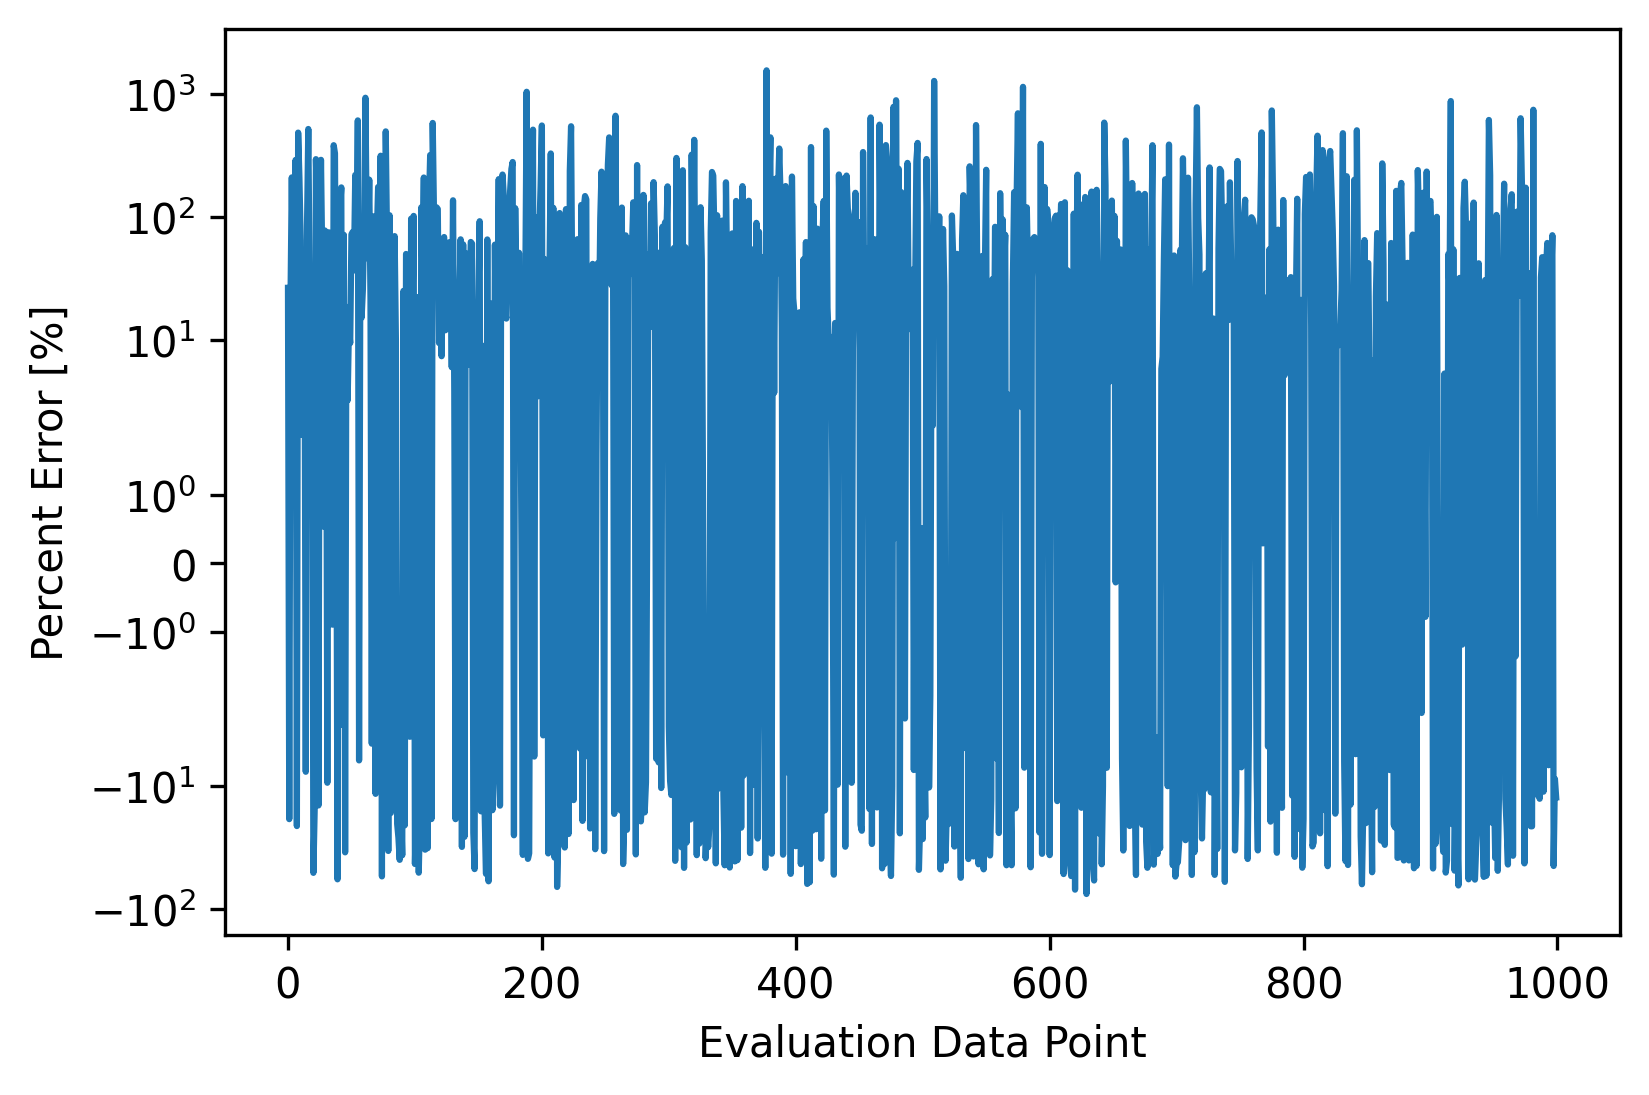

In [23]:
# in_width_eval[1]
# model.predict([[te_mag], [te_angle], te_width, te_height])
# for i in range(len(in_mag_eval3)):
#     mag_temp = in_mag_eval3[i]
#     ang_temp = in_angle_eval3[i]
#     wid_temp = in_width_eval3[i]
#     hgt_temp = in_height_eval3[i]

eval3_predictions = model.predict([[in_mag_eval3], [in_angle_eval3], in_width_eval3, in_height_eval3])
# model.predict([[mag_temp], [ang_temp], wid_temp, hgt_temp])

sum_m_error3 = 0
sum_n_error3 = 0
sum_mode_error3 = 0
sum_comp_error3 = 0

for i in range(len(eval3_predictions[0])):
    eval_pred_m = np.argmax(eval3_predictions[0][i])
    # print(f"{eval_pred_m} - {eval_data_noise_1p00.m[i]}")
    if eval_pred_m != eval_data_noise_1p00.m[i]:
        sum_m_error3 += 1

for i in range(len(eval3_predictions[1])):
    eval_pred_n = np.argmax(eval3_predictions[1][i])
    if eval_pred_n != eval_data_noise_1p00.n[i]:
        sum_n_error3 += 1

for i in range(len(eval3_predictions[2])):
    eval_pred_mode = np.round(eval3_predictions[2][i])
    if eval_pred_mode != eval_data_noise_1p00['mode'][i]:
        sum_mode_error3 += 1

for i in range(len(eval3_predictions[4])):
    eval_pred_comp = np.argmax(eval3_predictions[4][i])
    # print(f"{eval_pred_comp} - {eval_data_noise_1p00.component[i]}")
    if eval_pred_comp != eval_data_noise_1p00.component[i]:
        sum_comp_error3 += 1

perc_error3 = np.zeros(len(eval3_predictions[3]))
for i in range(len(eval3_predictions[4])):
    eval_pred_freq = eval3_predictions[3][i]
    eval_real_freq = eval_data_noise_1p00.freq[i]
    perc_error3[i] = ((eval_pred_freq-eval_real_freq)/eval_real_freq)*100

mean_perc_error3 = np.mean(perc_error3)
median_perc_error3 = np.median(perc_error3)
min_perc_error3 = np.min(perc_error3)
max_perc_error3 = np.max(perc_error3)

print(f"m error: {sum_m_error3}")
print(f"n error: {sum_n_error3}")
print(f"mode error: {sum_mode_error3}")
print(f"comp error: {sum_comp_error3}")
print(f"mean freq error: {mean_perc_error3}")
print(f"median freq error: {median_perc_error3}")
print(f"min freq error: {min_perc_error3}")
print(f"max freq error: {max_perc_error3}")

plt.plot(perc_error3)
plt.yscale('symlog')
plt.ylabel('Percent Error [%]')
plt.xlabel('Evaluation Data Point')
plt.show()

m error: 0
n error: 0
mode error: 171
comp error: 154
mean freq error: 72.59814940608292
median freq error: 22.42139720916748
min freq error: -69.30162048339844
max freq error: 1813.8387451171875


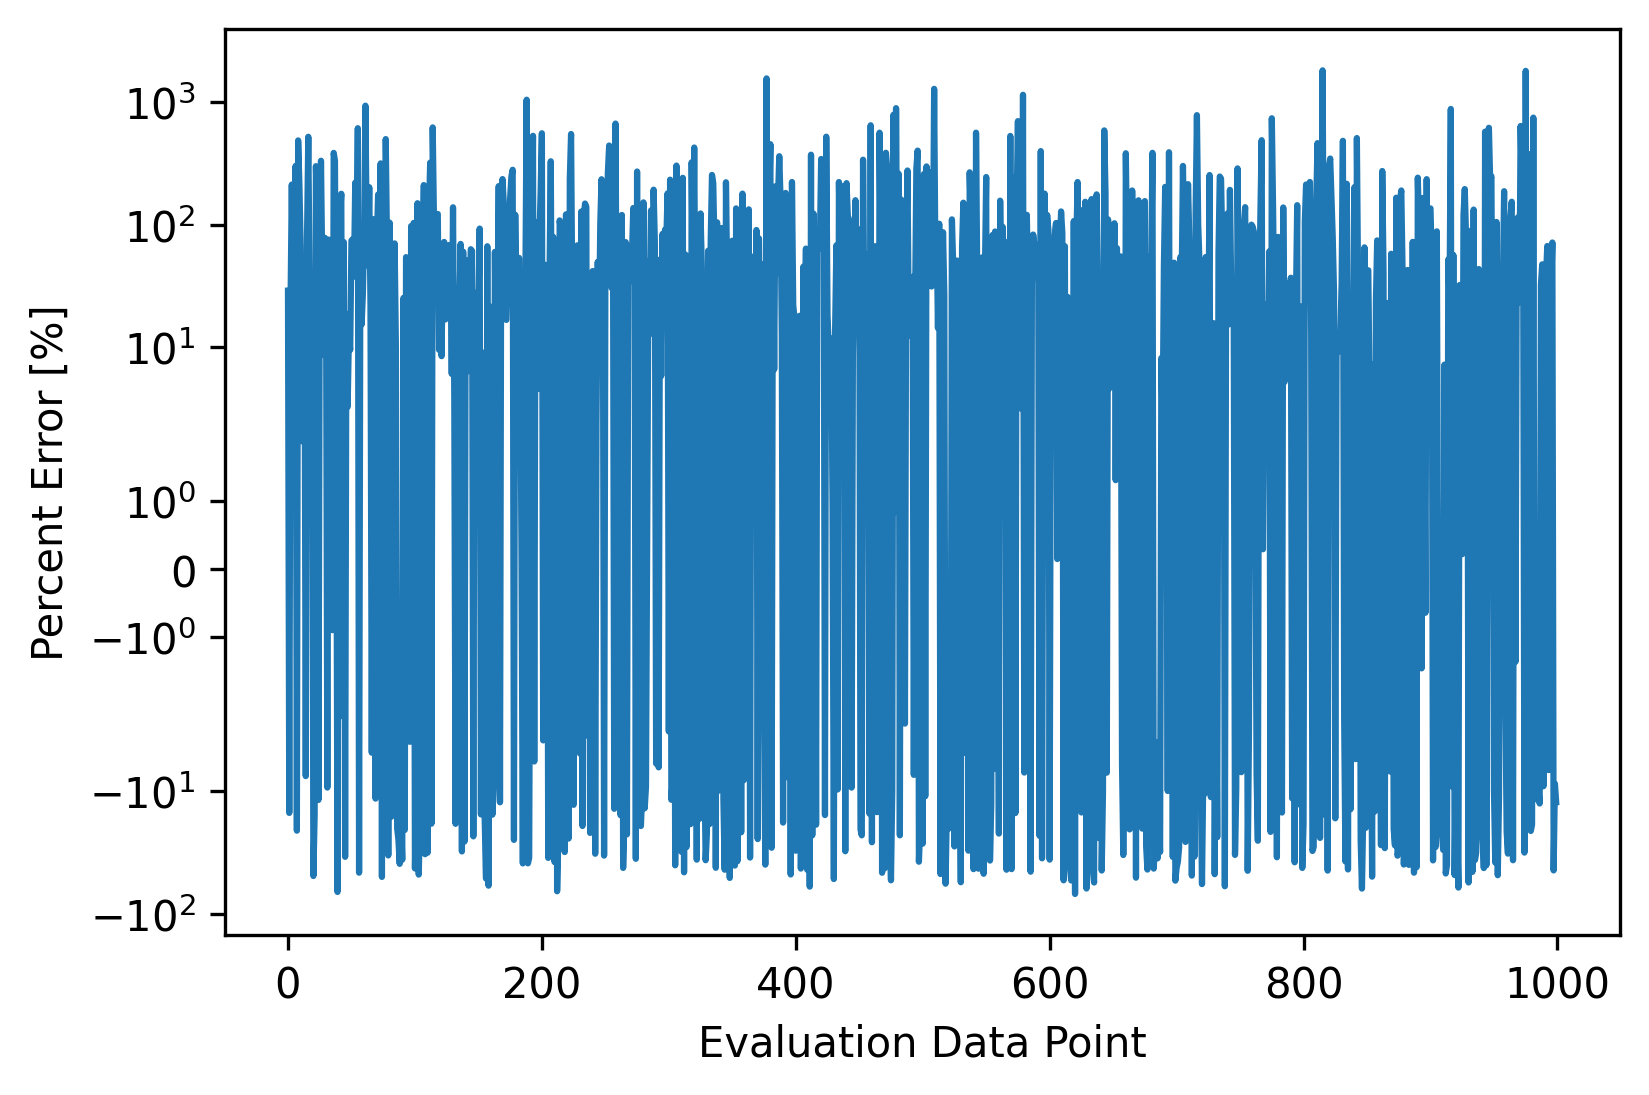

In [24]:
# in_width_eval[1]
# model.predict([[te_mag], [te_angle], te_width, te_height])
# for i in range(len(in_mag_eval4)):
#     mag_temp = in_mag_eval4[i]
#     ang_temp = in_angle_eval4[i]
#     wid_temp = in_width_eval4[i]
#     hgt_temp = in_height_eval4[i]

eval4_predictions = model.predict([[in_mag_eval4], [in_angle_eval4], in_width_eval4, in_height_eval4])
# model.predict([[mag_temp], [ang_temp], wid_temp, hgt_temp])

sum_m_error4 = 0
sum_n_error4 = 0
sum_mode_error4 = 0
sum_comp_error4 = 0

for i in range(len(eval4_predictions[0])):
    eval_pred_m = np.argmax(eval4_predictions[0][i])
    # print(f"{eval_pred_m} - {eval_data_noise_10p0.m[i]}")
    if eval_pred_m != eval_data_noise_10p0.m[i]:
        sum_m_error4 += 1

for i in range(len(eval4_predictions[1])):
    eval_pred_n = np.argmax(eval4_predictions[1][i])
    if eval_pred_n != eval_data_noise_10p0.n[i]:
        sum_n_error4 += 1

for i in range(len(eval4_predictions[2])):
    eval_pred_mode = np.round(eval4_predictions[2][i])
    if eval_pred_mode != eval_data_noise_10p0['mode'][i]:
        sum_mode_error4 += 1

for i in range(len(eval4_predictions[4])):
    eval_pred_comp = np.argmax(eval4_predictions[4][i])
    # print(f"{eval_pred_comp} - {eval_data_noise_10p0.component[i]}")
    if eval_pred_comp != eval_data_noise_10p0.component[i]:
        sum_comp_error4 += 1

perc_error4 = np.zeros(len(eval4_predictions[3]))
for i in range(len(eval4_predictions[4])):
    eval_pred_freq = eval4_predictions[3][i]
    eval_real_freq = eval_data_noise_10p0.freq[i]
    perc_error4[i] = ((eval_pred_freq-eval_real_freq)/eval_real_freq)*100

mean_perc_error4 = np.mean(perc_error4)
median_perc_error4 = np.median(perc_error4)
min_perc_error4 = np.min(perc_error4)
max_perc_error4 = np.max(perc_error4)

print(f"m error: {sum_m_error4}")
print(f"n error: {sum_n_error4}")
print(f"mode error: {sum_mode_error4}")
print(f"comp error: {sum_comp_error4}")
print(f"mean freq error: {mean_perc_error4}")
print(f"median freq error: {median_perc_error4}")
print(f"min freq error: {min_perc_error4}")
print(f"max freq error: {max_perc_error4}")

plt.plot(perc_error4)
plt.yscale('symlog')
plt.ylabel('Percent Error [%]')
plt.xlabel('Evaluation Data Point')
plt.show()

m error: 7
n error: 19
mode error: 187
comp error: 217
mean freq error: 377.16512742327154
median freq error: 36.884939193725586
min freq error: -69.30162048339844
max freq error: 59002.51953125


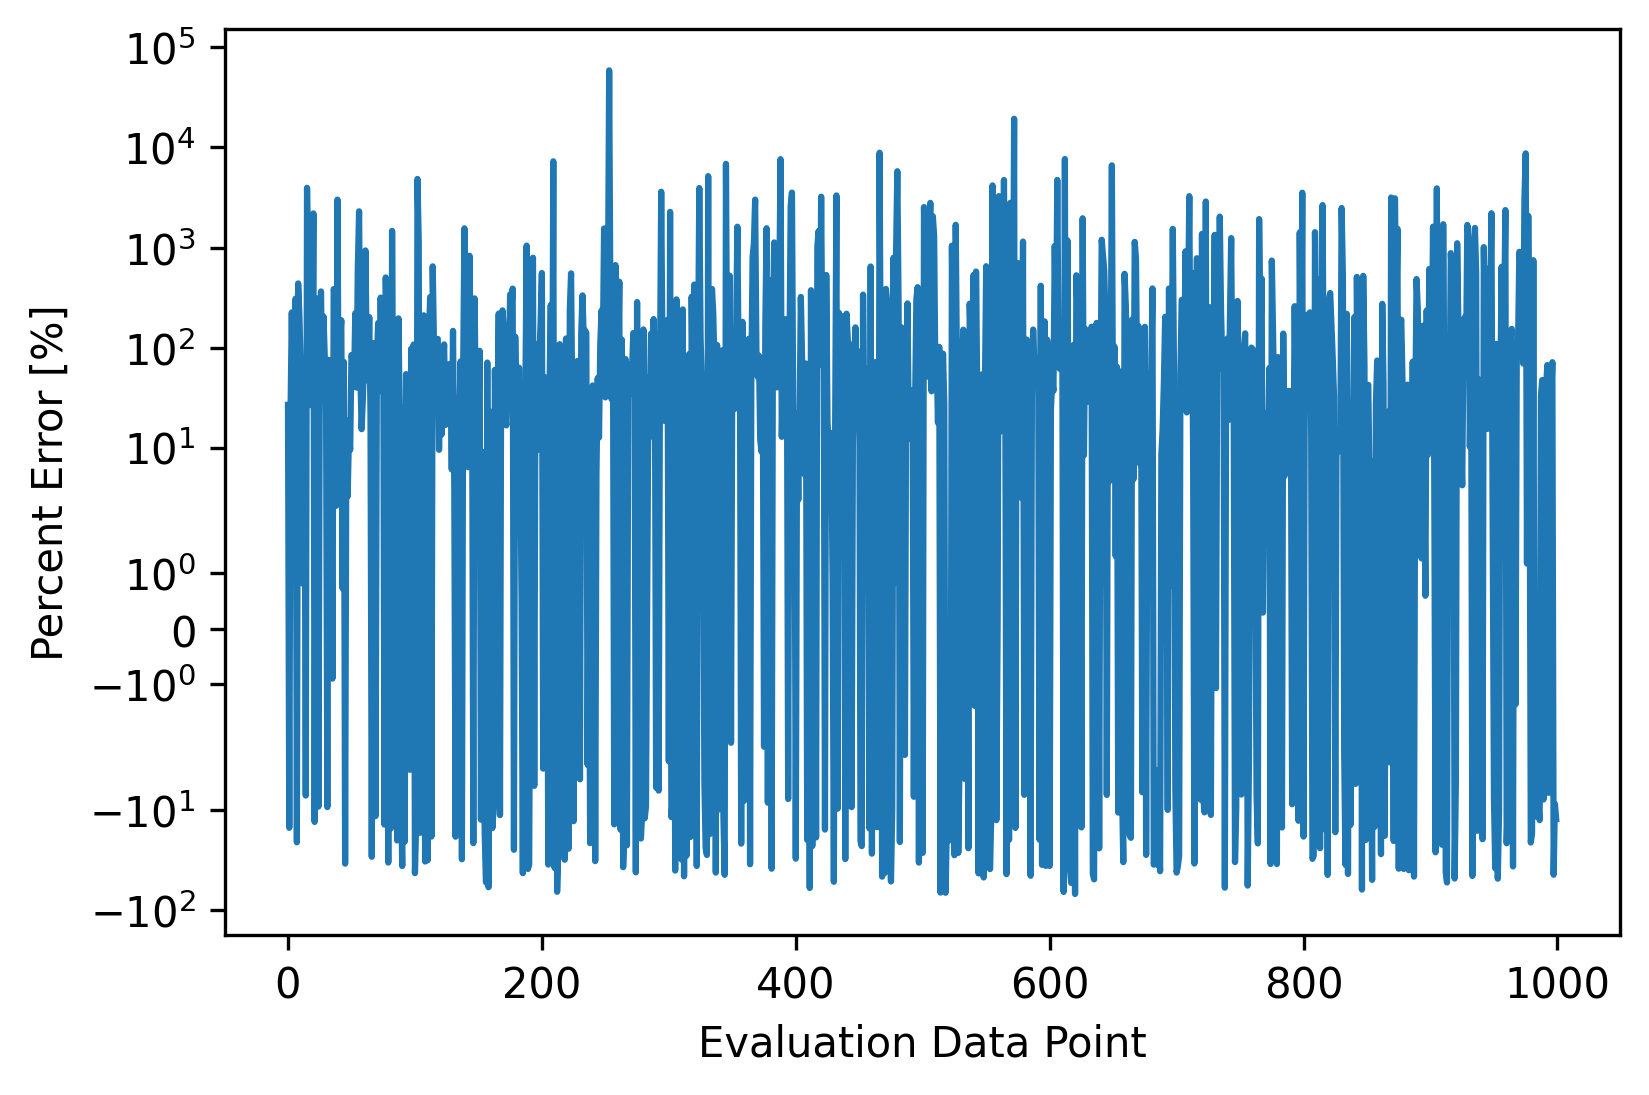

In [25]:
# in_width_eval[1]
# model.predict([[te_mag], [te_angle], te_width, te_height])
# for i in range(len(in_mag_eval5)):
#     mag_temp = in_mag_eval5[i]
#     ang_temp = in_angle_eval5[i]
#     wid_temp = in_width_eval5[i]
#     hgt_temp = in_height_eval5[i]

eval5_predictions = model.predict([[in_mag_eval5], [in_angle_eval5], in_width_eval5, in_height_eval5])
# model.predict([[mag_temp], [ang_temp], wid_temp, hgt_temp])

sum_m_error5 = 0
sum_n_error5 = 0
sum_mode_error5 = 0
sum_comp_error5 = 0

for i in range(len(eval5_predictions[0])):
    eval_pred_m = np.argmax(eval5_predictions[0][i])
    # print(f"{eval_pred_m} - {eval_data_noise_100p.m[i]}")
    if eval_pred_m != eval_data_noise_100p.m[i]:
        sum_m_error5 += 1

for i in range(len(eval5_predictions[1])):
    eval_pred_n = np.argmax(eval5_predictions[1][i])
    if eval_pred_n != eval_data_noise_100p.n[i]:
        sum_n_error5 += 1

for i in range(len(eval5_predictions[2])):
    eval_pred_mode = np.round(eval5_predictions[2][i])
    if eval_pred_mode != eval_data_noise_100p['mode'][i]:
        sum_mode_error5 += 1

for i in range(len(eval5_predictions[4])):
    eval_pred_comp = np.argmax(eval5_predictions[4][i])
    # print(f"{eval_pred_comp} - {eval_data_noise_100p.component[i]}")
    if eval_pred_comp != eval_data_noise_100p.component[i]:
        sum_comp_error5 += 1

perc_error5 = np.zeros(len(eval5_predictions[3]))
for i in range(len(eval5_predictions[4])):
    eval_pred_freq = eval5_predictions[3][i]
    eval_real_freq = eval_data_noise_100p.freq[i]
    perc_error5[i] = ((eval_pred_freq-eval_real_freq)/eval_real_freq)*100

mean_perc_error5 = np.mean(perc_error5)
median_perc_error5 = np.median(perc_error5)
min_perc_error5 = np.min(perc_error5)
max_perc_error5 = np.max(perc_error5)

print(f"m error: {sum_m_error5}")
print(f"n error: {sum_n_error5}")
print(f"mode error: {sum_mode_error5}")
print(f"comp error: {sum_comp_error5}")
print(f"mean freq error: {mean_perc_error5}")
print(f"median freq error: {median_perc_error5}")
print(f"min freq error: {min_perc_error5}")
print(f"max freq error: {max_perc_error5}")

plt.plot(perc_error5)
plt.yscale('symlog')
plt.ylabel('Percent Error [%]')
plt.xlabel('Evaluation Data Point')
plt.show()

Text(0, 0.5, 'Error Count')

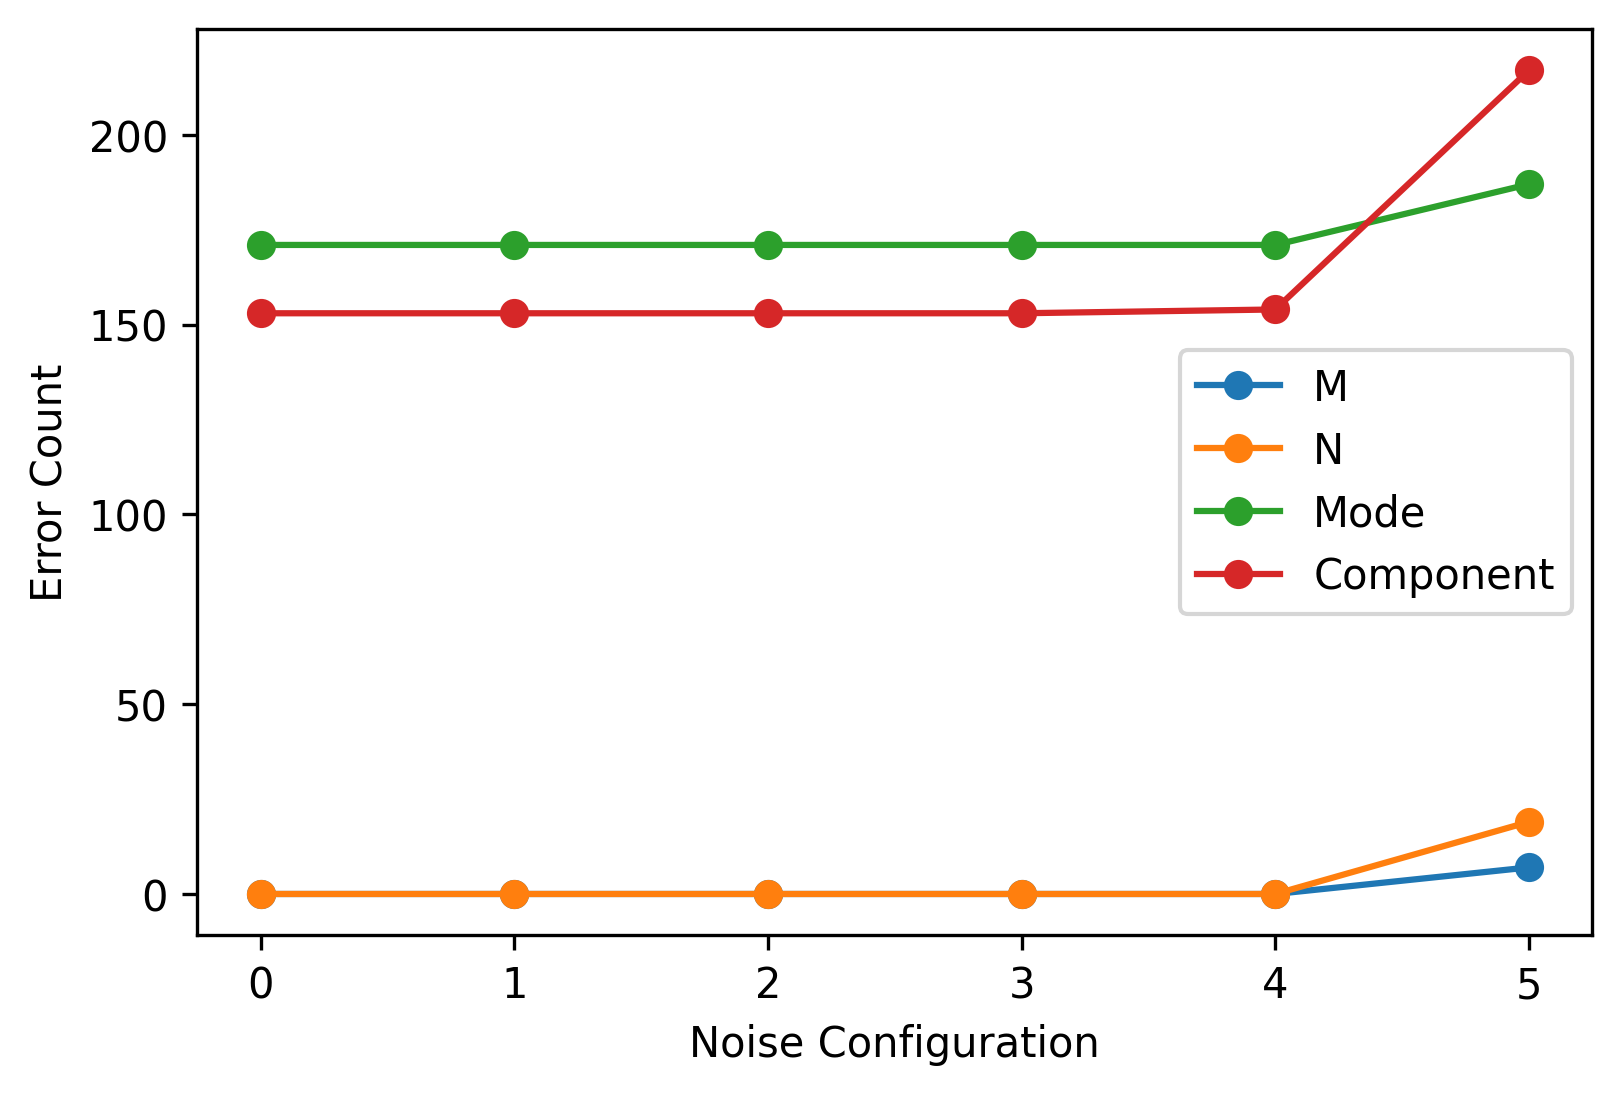

In [26]:
# Plot comparisons
x_axis_vals = [0, 1, 2, 3, 4, 5]
m_err_tot = [sum_m_error0, sum_m_error1,sum_m_error2,sum_m_error3,sum_m_error4,sum_m_error5]
n_err_tot = [sum_n_error0, sum_n_error1,sum_n_error2,sum_n_error3,sum_n_error4,sum_n_error5]
mode_err_tot = [sum_mode_error0, sum_mode_error1,sum_mode_error2,sum_mode_error3,sum_mode_error4,sum_mode_error5]
comp_err_tot = [sum_comp_error0, sum_comp_error1,sum_comp_error2,sum_comp_error3,sum_comp_error4,sum_comp_error5]

plt.plot(x_axis_vals, m_err_tot, marker="o")
plt.plot(x_axis_vals, n_err_tot, marker="o")
plt.plot(x_axis_vals, mode_err_tot, marker="o")
plt.plot(x_axis_vals, comp_err_tot, marker="o")
plt.legend(['M', 'N', 'Mode', 'Component'])
plt.xlabel("Noise Configuration")
plt.ylabel("Error Count")

## Create an SVM!

In [27]:
# need to prep the data first
# original: [[in_mag_train], [in_angle_train], in_width_train, in_height_train],
# [out_m_train, out_n_train, out_mode_train, out_freq_train, out_component_train]
# need a 2d array, each row is:
# - flattened 101x101 matrix of mag
# - flattened 101x101 matrix of angle
# - width
# - height

# Then, each svm needs to be done one at a time

In [28]:


# poly_kernel_svm_clf.fit([[in_mag_train], [in_angle_train], in_width_train, in_height_train],
#                         [out_m_train, out_n_train, out_mode_train, out_freq_train, out_component_train])

# Create a single 25000 x 20404 array. Each row is a sample.
in_mag_train_flat = np.reshape(in_mag_train,(len(in_mag_train),-1))
in_angle_train_flat = np.reshape(in_angle_train,(len(in_angle_train),-1))
in_mag_angle_train = np.concatenate((in_mag_train_flat, in_angle_train_flat), axis=1)
in_dims_train = np.vstack((in_width_train, in_height_train)).transpose()
in_svm_all_train = np.concatenate((in_mag_angle_train, in_dims_train), axis=1)

in_mag_test_flat = np.reshape(in_mag_test,(len(in_mag_test),-1))
in_angle_test_flat = np.reshape(in_angle_test,(len(in_angle_test),-1))
in_mag_angle_test = np.concatenate((in_mag_test_flat, in_angle_test_flat), axis=1)
in_dims_test = np.vstack((in_width_test, in_height_test)).transpose()
in_svm_all_test = np.concatenate((in_mag_angle_test, in_dims_test), axis=1)

# clf.fit([in_mag_train_flat], out_m_train)

In [29]:
from sklearn import tree
import joblib

train_new_models = False

In [30]:
# Fit the first one (m)
if train_new_models:
    clf_m = tree.DecisionTreeClassifier()
    clf_m.fit(in_svm_all_train, out_m_train)
    joblib.dump(clf_m, "dt_model_m.pkl", compress=3)
else:
    clf_m = joblib.load("dt_model_m.pkl")

[Text(0.5, 0.9, 'X[2530] <= 0.0\ngini = 0.667\nsamples = 25000\nvalue = [8487, 8264, 8249]'),
 Text(0.2, 0.7, 'X[20099] <= 0.785\ngini = 0.037\nsamples = 3927\nvalue = [52, 3854, 21]'),
 Text(0.1, 0.5, 'gini = 0.0\nsamples = 3853\nvalue = [0, 3853, 0]'),
 Text(0.3, 0.5, 'X[15665] <= 0.0\ngini = 0.425\nsamples = 74\nvalue = [52, 1, 21]'),
 Text(0.2, 0.3, 'X[14276] <= 2.356\ngini = 0.087\nsamples = 22\nvalue = [0, 1, 21]'),
 Text(0.1, 0.1, '\n  (...)  \n'),
 Text(0.3, 0.1, '\n  (...)  \n'),
 Text(0.4, 0.3, 'gini = 0.0\nsamples = 52\nvalue = [52, 0, 0]'),
 Text(0.8, 0.7, 'X[12322] <= 2.356\ngini = 0.644\nsamples = 21073\nvalue = [8435, 4410, 8228]'),
 Text(0.7, 0.5, 'X[17473] <= 2.356\ngini = 0.641\nsamples = 18305\nvalue = [8435, 4410, 5460]'),
 Text(0.6, 0.3, 'X[5133] <= 0.0\ngini = 0.663\nsamples = 15551\nvalue = [5681, 4410, 5460]'),
 Text(0.5, 0.1, '\n  (...)  \n'),
 Text(0.7, 0.1, '\n  (...)  \n'),
 Text(0.8, 0.3, 'gini = 0.0\nsamples = 2754\nvalue = [2754, 0, 0]'),
 Text(0.9, 0.5, 

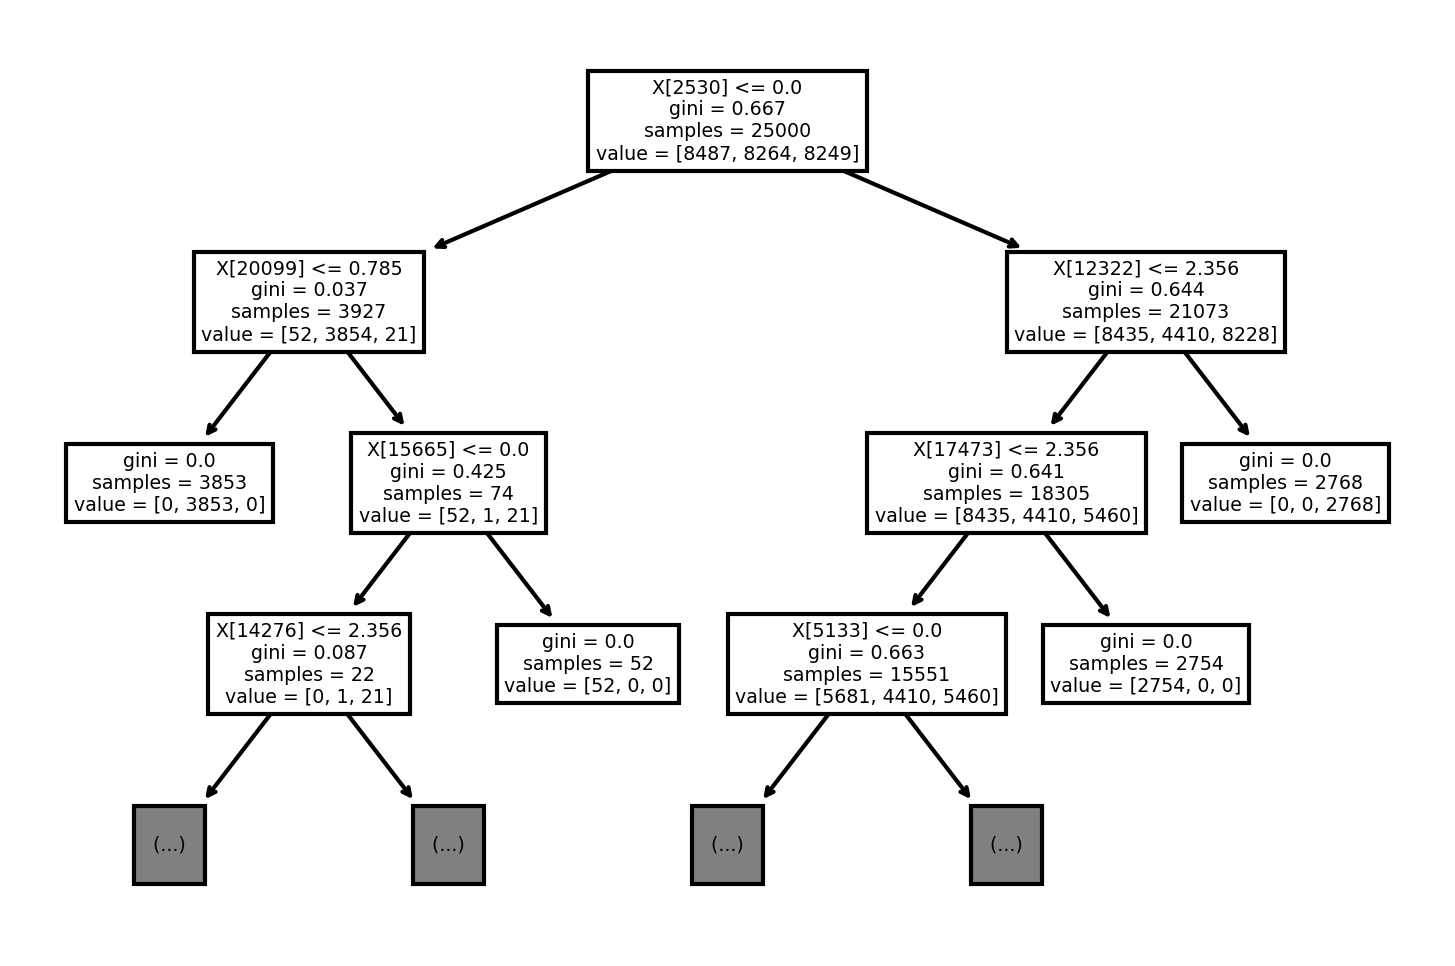

In [31]:
tree.plot_tree(clf_m, max_depth=3)

In [54]:
# fit n
if train_new_models:
    clf_n = tree.DecisionTreeClassifier()
    clf_n.fit(in_svm_all_train, out_n_train)
    joblib.dump(clf_n, "dt_model_n.pkl", compress=3)
else:
    clf_n = joblib.load("dt_model_n.pkl")

In [55]:
# fit mode
if train_new_models:
    clf_mode = tree.DecisionTreeClassifier()
    clf_mode.fit(in_svm_all_train, out_mode_train)
    joblib.dump(clf_mode, "dt_model_mode.pkl", compress=3)
else:
    clf_mode = joblib.load("dt_model_mode.pkl")

In [56]:
# fit comp
if train_new_models:
    clf_comp = tree.DecisionTreeClassifier()
    clf_comp.fit(in_svm_all_train, out_component_train)
    joblib.dump(clf_comp, "dt_model_comp.pkl", compress=3)
else:
    clf_comp = joblib.load("dt_model_comp.pkl")

In [57]:
# fit freq
if train_new_models:
    reg_freq = tree.DecisionTreeRegressor()
    reg_freq.fit(in_svm_all_train, out_freq_train)
    joblib.dump(reg_freq, "dt_model_freq.pkl", compress=3)
else:
    reg_freq = joblib.load("dt_model_freq.pkl")

m error: 51
n error: 65
mode error: 1
comp error: 0
mean freq error: 27.97413454356523
median freq error: -0.24828516025417383
min freq error: -94.72329060567367
max freq error: 1925.5152164535855


Text(0, 0.5, 'Count of Occurances')

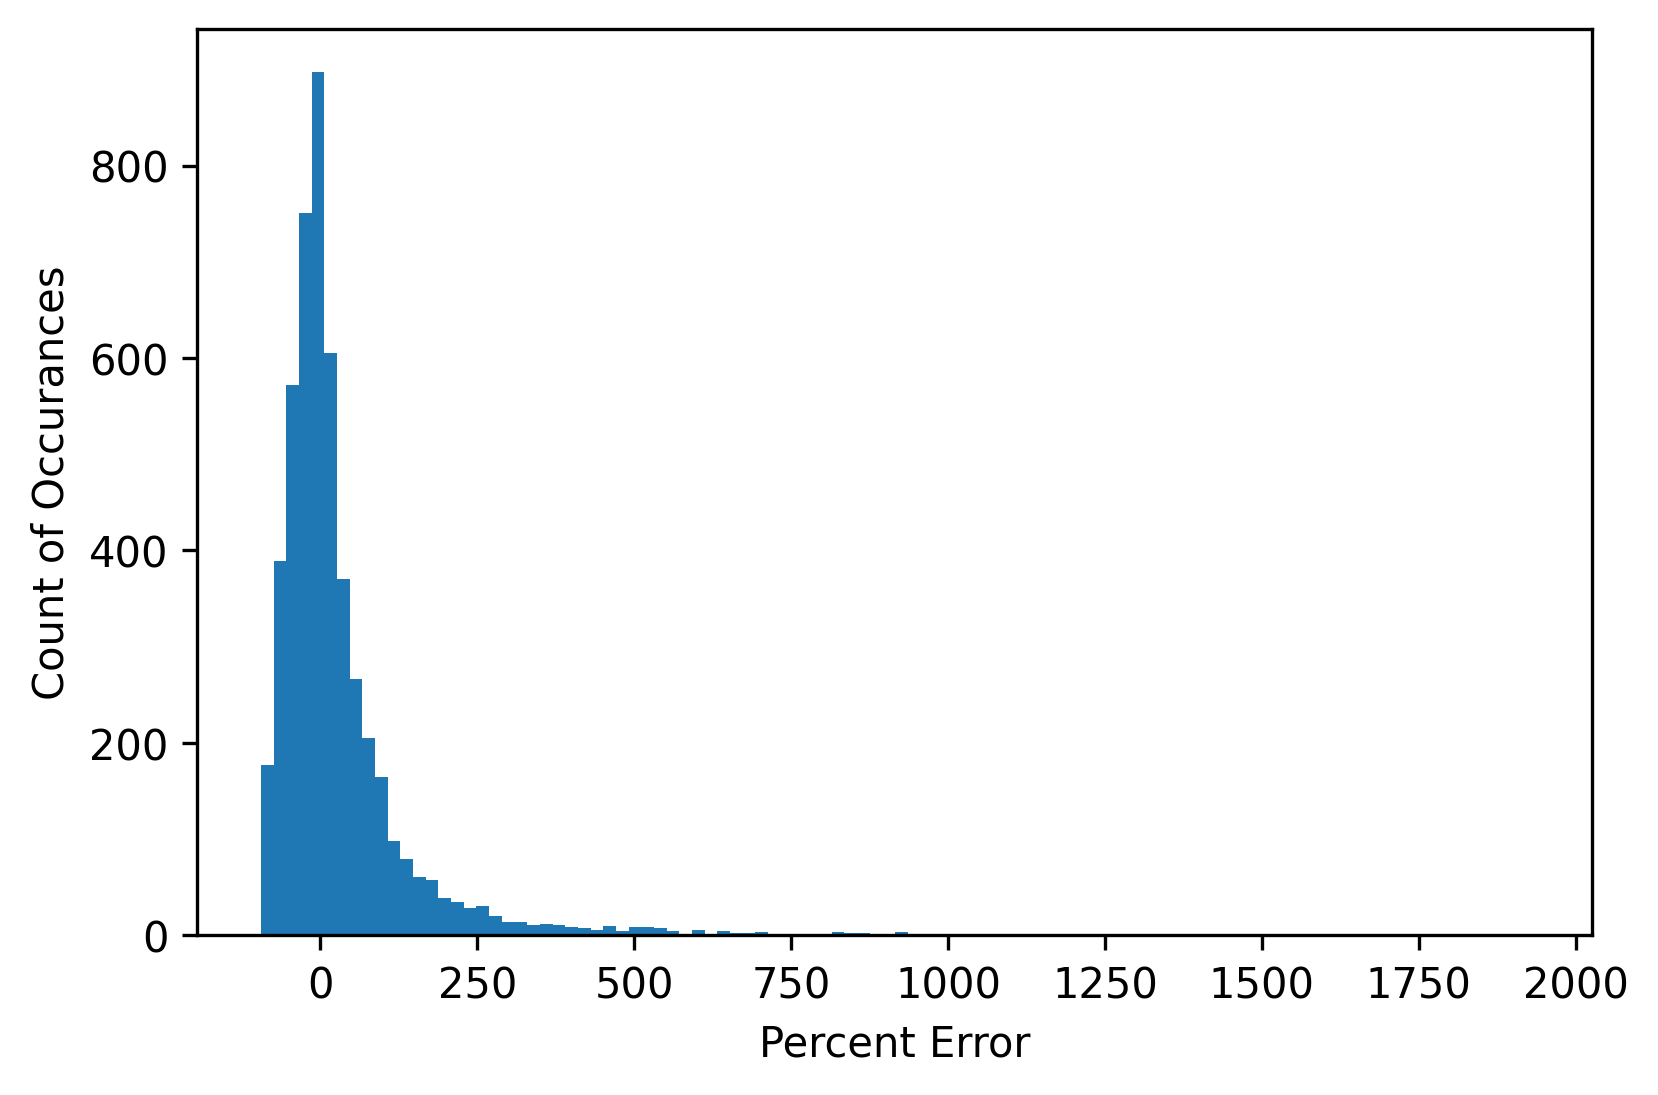

In [58]:
# Check the noiseless test data set
m_error_test = 0
for i in range(len(out_m_test)):
    predicted_m_test = np.array(clf_m.predict([in_svm_all_test[i]])).item()
    real_m_test = np.array(out_m_test[i])
    # print(f"Predict: {predicted_m0} and Real: {real_m0}")
    if predicted_m_test != real_m_test:
        m_error_test += 1

# print(f"m error: {m_error_test}")

n_error_test = 0
for i in range(len(out_n_test)):
    predicted_n_test = np.array(clf_n.predict([in_svm_all_test[i]])).item()
    real_n_test = np.array(out_n_test[i])
    # print(f"Predict: {predicted_m0} and Real: {real_m0}")
    if predicted_n_test != real_n_test:
        n_error_test += 1

# print(f"n error: {n_error_test}")

mode_error_test = 0
for i in range(len(out_mode_test)):
    predicted_mode_test = np.array(clf_mode.predict([in_svm_all_test[i]])).item()
    real_mode_test = np.array(out_mode_test[i])
    # print(f"Predict: {predicted_m0} and Real: {real_m0}")
    if predicted_mode_test != real_mode_test:
        mode_error_test += 1

# print(f"mode error: {mode_error_test}")

comp_error_test = 0
for i in range(len(out_component_test)):
    predicted_comp_test = np.array(clf_comp.predict([in_svm_all_test[i]])).item()
    real_comp_test = np.array(out_component_test[i])
    # print(f"Predict: {predicted_comp_test} and Real: {real_comp_test}")
    if predicted_comp_test != real_comp_test:
        comp_error_test += 1

# print(f"comp error: {comp_error_test}")

perc_error_test = np.zeros(len(out_freq_test))
for i in range(len(out_freq_test)):
    predicted_freq_test = np.array(reg_freq.predict([in_svm_all_test[i]])).item()
    real_freq_test = np.array(out_freq_test[i])
    # print(f"Predict: {predicted_freq_test} and Real: {real_freq_test}")
    perc_error_test[i] = ((predicted_freq_test-real_freq_test)/real_freq_test)*100


mean_perc_error_test = np.mean(perc_error_test)
median_perc_error_test = np.median(perc_error_test)
min_perc_error_test = np.min(perc_error_test)
max_perc_error_test = np.max(perc_error_test)

print(f"m error: {m_error_test}")
print(f"n error: {n_error_test}")
print(f"mode error: {mode_error_test}")
print(f"comp error: {comp_error_test}")
print(f"mean freq error: {mean_perc_error_test}")
print(f"median freq error: {median_perc_error_test}")
print(f"min freq error: {min_perc_error_test}")
print(f"max freq error: {max_perc_error_test}")

plt.hist(perc_error_test, bins=100)
plt.xlabel("Percent Error")
plt.ylabel("Count of Occurances")

In [59]:
# Prep the eval data
in_mag_eval0_flat = np.reshape(in_mag_eval0,(len(in_mag_eval0),-1))
in_angle_eval0_flat = np.reshape(in_angle_eval0,(len(in_angle_eval0),-1))
in_mag_angle_eval0 = np.concatenate((in_mag_eval0_flat, in_angle_eval0_flat), axis=1)
in_dims_eval0 = np.vstack((in_width_eval0, in_height_eval0)).transpose()
in_svm_all_eval0 = np.concatenate((in_mag_angle_eval0, in_dims_eval0), axis=1)

in_mag_eval1_flat = np.reshape(in_mag_eval1,(len(in_mag_eval1),-1))
in_angle_eval1_flat = np.reshape(in_angle_eval1,(len(in_angle_eval1),-1))
in_mag_angle_eval1 = np.concatenate((in_mag_eval1_flat, in_angle_eval1_flat), axis=1)
in_dims_eval1 = np.vstack((in_width_eval1, in_height_eval1)).transpose()
in_svm_all_eval1 = np.concatenate((in_mag_angle_eval1, in_dims_eval1), axis=1)

in_mag_eval2_flat = np.reshape(in_mag_eval2,(len(in_mag_eval2),-1))
in_angle_eval2_flat = np.reshape(in_angle_eval2,(len(in_angle_eval2),-1))
in_mag_angle_eval2 = np.concatenate((in_mag_eval2_flat, in_angle_eval2_flat), axis=1)
in_dims_eval2 = np.vstack((in_width_eval2, in_height_eval2)).transpose()
in_svm_all_eval2 = np.concatenate((in_mag_angle_eval2, in_dims_eval2), axis=1)

in_mag_eval3_flat = np.reshape(in_mag_eval3,(len(in_mag_eval3),-1))
in_angle_eval3_flat = np.reshape(in_angle_eval3,(len(in_angle_eval3),-1))
in_mag_angle_eval3 = np.concatenate((in_mag_eval3_flat, in_angle_eval3_flat), axis=1)
in_dims_eval3 = np.vstack((in_width_eval3, in_height_eval3)).transpose()
in_svm_all_eval3 = np.concatenate((in_mag_angle_eval3, in_dims_eval3), axis=1)

in_mag_eval4_flat = np.reshape(in_mag_eval4,(len(in_mag_eval4),-1))
in_angle_eval4_flat = np.reshape(in_angle_eval4,(len(in_angle_eval4),-1))
in_mag_angle_eval4 = np.concatenate((in_mag_eval4_flat, in_angle_eval4_flat), axis=1)
in_dims_eval4 = np.vstack((in_width_eval4, in_height_eval4)).transpose()
in_svm_all_eval4 = np.concatenate((in_mag_angle_eval4, in_dims_eval4), axis=1)

in_mag_eval5_flat = np.reshape(in_mag_eval5,(len(in_mag_eval5),-1))
in_angle_eval5_flat = np.reshape(in_angle_eval5,(len(in_angle_eval5),-1))
in_mag_angle_eval5 = np.concatenate((in_mag_eval5_flat, in_angle_eval5_flat), axis=1)
in_dims_eval5 = np.vstack((in_width_eval5, in_height_eval5)).transpose()
in_svm_all_eval5 = np.concatenate((in_mag_angle_eval5, in_dims_eval5), axis=1)

m error: 9
n error: 10
mode error: 0
comp error: 0
mean freq error: 27.960966790068955
median freq error: 1.1646336946932672
min freq error: -93.00385336202133
max freq error: 1023.9685302123693


Text(0, 0.5, 'Count of Occurances')

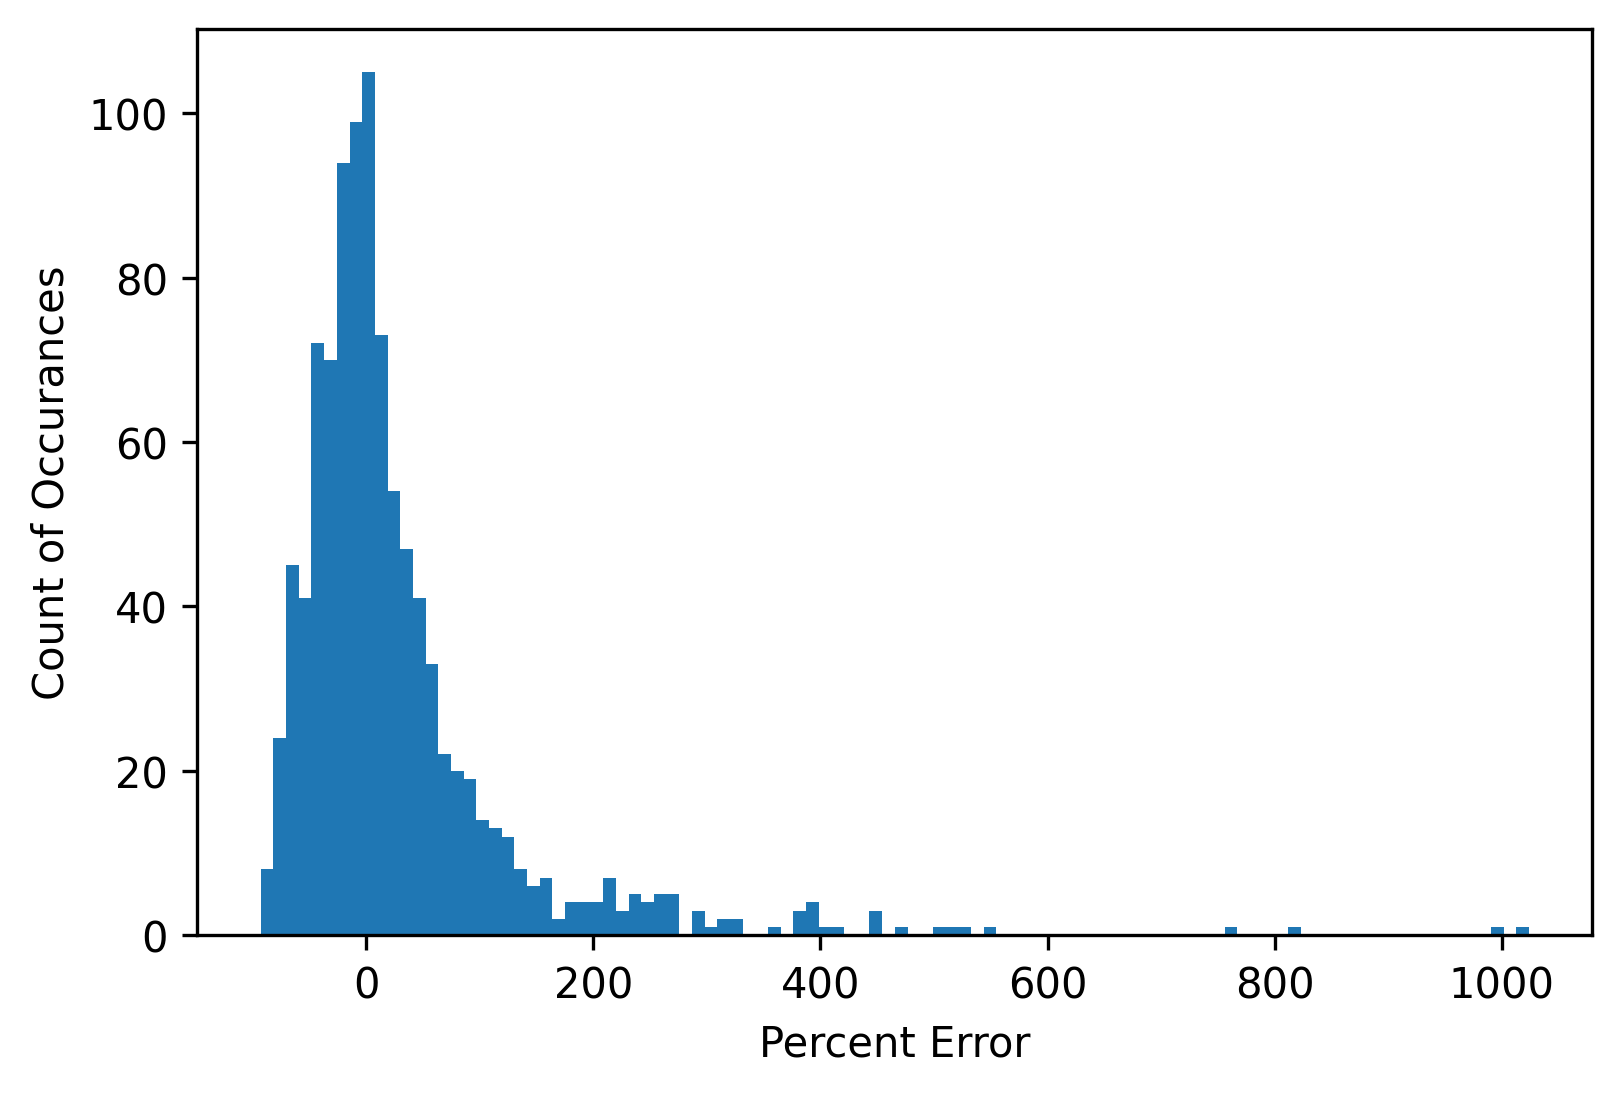

In [60]:
# Check the noiseless eval0 data set
m_error0 = 0
for i in range(len(out_m_eval0)):
    predicted_m_eval0 = np.array(clf_m.predict([in_svm_all_eval0[i]])).item()
    real_m_eval0 = np.array(out_m_eval0[i])
    # print(f"Predict: {predicted_m0} and Real: {real_m0}")
    if predicted_m_eval0 != real_m_eval0:
        m_error0 += 1

# print(f"m error: {m_error0}")

n_error0 = 0
for i in range(len(out_n_eval0)):
    predicted_n_eval0 = np.array(clf_n.predict([in_svm_all_eval0[i]])).item()
    real_n_eval0 = np.array(out_n_eval0[i])
    # print(f"Predict: {predicted_m0} and Real: {real_m0}")
    if predicted_n_eval0 != real_n_eval0:
        n_error0 += 1

# print(f"n error: {n_error0}")

mode_error0 = 0
for i in range(len(out_mode_eval0)):
    predicted_mode_eval0 = np.array(clf_mode.predict([in_svm_all_eval0[i]])).item()
    real_mode_eval0 = np.array(out_mode_eval0[i])
    # print(f"Predict: {predicted_m0} and Real: {real_m0}")
    if predicted_mode_eval0 != real_mode_eval0:
        mode_error0 += 1

# print(f"mode error: {mode_error0}")

comp_error0 = 0
for i in range(len(out_component_eval0)):
    predicted_comp_eval0 = np.array(clf_comp.predict([in_svm_all_eval0[i]])).item()
    real_comp_eval0 = np.array(out_component_eval0[i])
    # print(f"Predict: {predicted_comp_eval0} and Real: {real_comp_eval0}")
    if predicted_comp_eval0 != real_comp_eval0:
        comp_error0 += 1

# print(f"comp error: {comp_error0}")

perc_error0 = np.zeros(len(out_freq_eval0))
for i in range(len(out_freq_eval0)):
    predicted_freq_eval0 = np.array(reg_freq.predict([in_svm_all_eval0[i]])).item()
    real_freq_eval0 = np.array(out_freq_eval0[i])
    # print(f"Predict: {predicted_freq_eval0} and Real: {real_freq_eval0}")
    perc_error0[i] = ((predicted_freq_eval0-real_freq_eval0)/real_freq_eval0)*100


mean_perc_error0 = np.mean(perc_error0)
median_perc_error0 = np.median(perc_error0)
min_perc_error0 = np.min(perc_error0)
max_perc_error0 = np.max(perc_error0)

print(f"m error: {m_error0}")
print(f"n error: {n_error0}")
print(f"mode error: {mode_error0}")
print(f"comp error: {comp_error0}")
print(f"mean freq error: {mean_perc_error0}")
print(f"median freq error: {median_perc_error0}")
print(f"min freq error: {min_perc_error0}")
print(f"max freq error: {max_perc_error0}")

plt.hist(perc_error0, bins=100)
plt.xlabel("Percent Error")
plt.ylabel("Count of Occurances")

m error: 74
n error: 81
mode error: 160
comp error: 32
mean freq error: 5.594262777640799
median freq error: -26.012668915911128
min freq error: -96.8424089729766
max freq error: 1514.7962220462823


Text(0, 0.5, 'Count of Occurances')

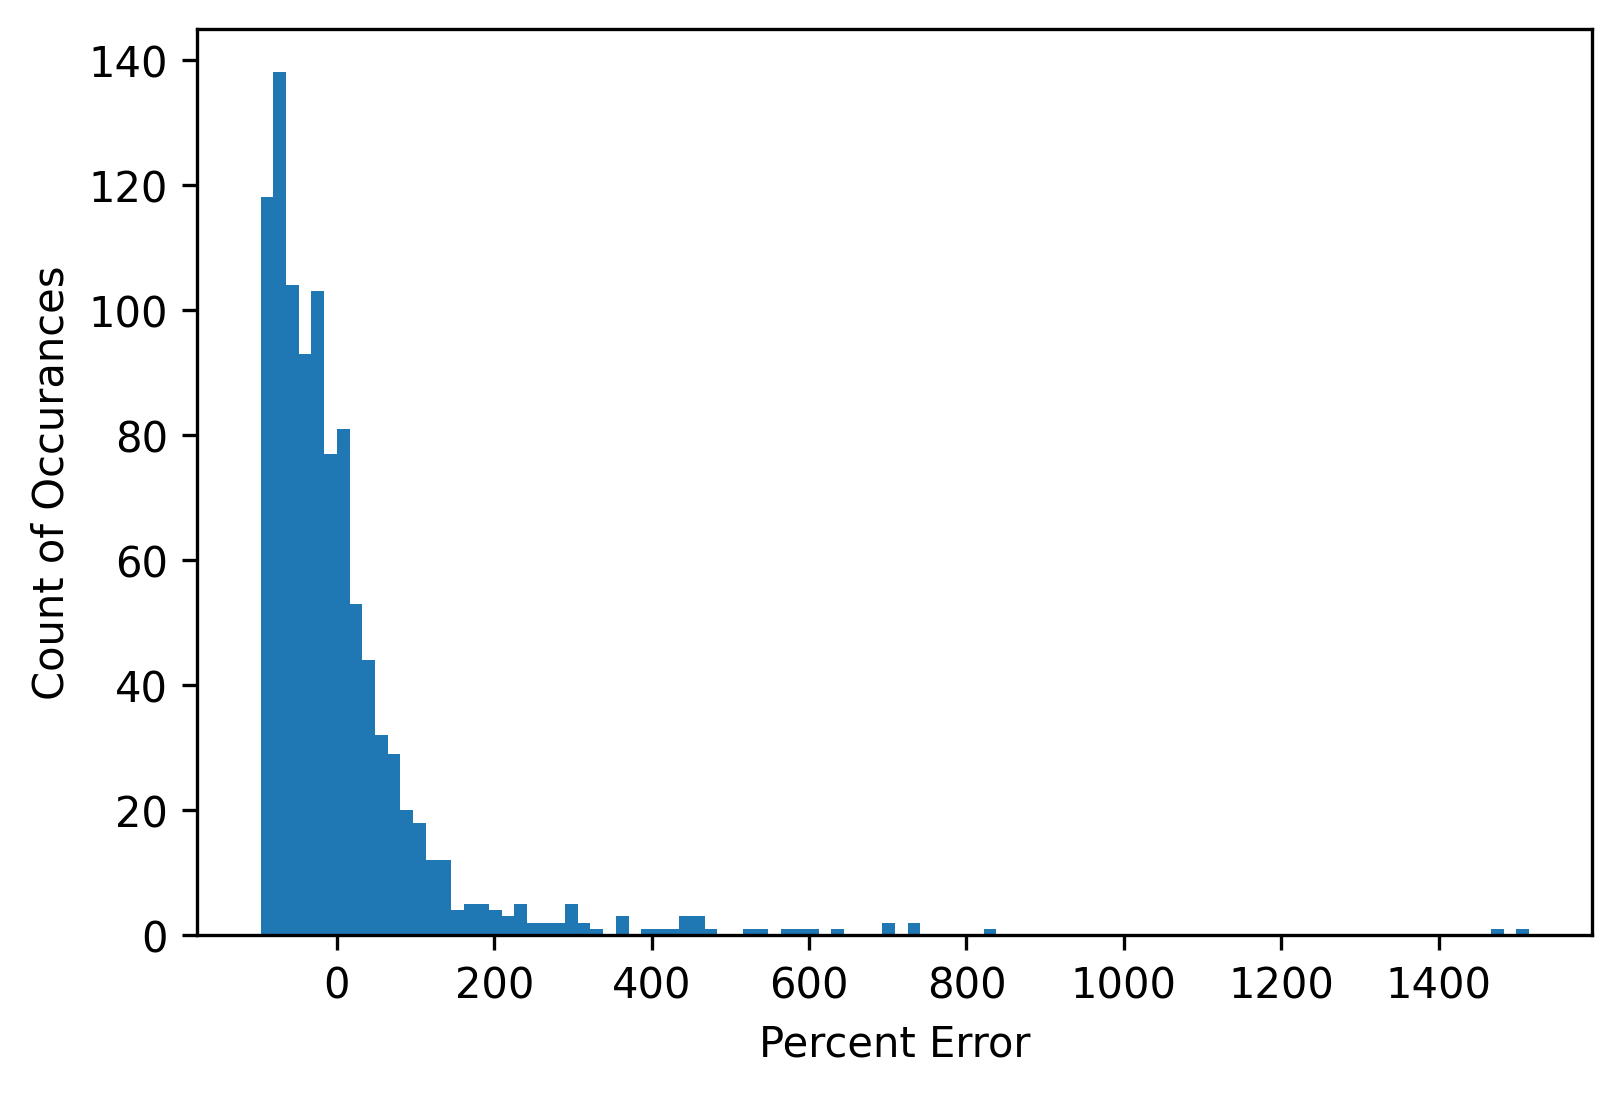

In [61]:
# Check the noiseless eval1 data set
m_error1 = 0
for i in range(len(out_m_eval1)):
    predicted_m_eval1 = np.array(clf_m.predict([in_svm_all_eval1[i]])).item()
    real_m_eval1 = np.array(out_m_eval1[i])
    # print(f"Predict: {predicted_m0} and Real: {real_m0}")
    if predicted_m_eval1 != real_m_eval1:
        m_error1 += 1

# print(f"m error: {m_error1}")

n_error1 = 0
for i in range(len(out_n_eval1)):
    predicted_n_eval1 = np.array(clf_n.predict([in_svm_all_eval1[i]])).item()
    real_n_eval1 = np.array(out_n_eval1[i])
    # print(f"Predict: {predicted_m0} and Real: {real_m0}")
    if predicted_n_eval1 != real_n_eval1:
        n_error1 += 1

# print(f"n error: {n_error1}")

mode_error1 = 0
for i in range(len(out_mode_eval1)):
    predicted_mode_eval1 = np.array(clf_mode.predict([in_svm_all_eval1[i]])).item()
    real_mode_eval1 = np.array(out_mode_eval1[i])
    # print(f"Predict: {predicted_m0} and Real: {real_m0}")
    if predicted_mode_eval1 != real_mode_eval1:
        mode_error1 += 1

# print(f"mode error: {mode_error1}")

comp_error1 = 0
for i in range(len(out_component_eval1)):
    predicted_comp_eval1 = np.array(clf_comp.predict([in_svm_all_eval1[i]])).item()
    real_comp_eval1 = np.array(out_component_eval1[i])
    # print(f"Predict: {predicted_comp_eval1} and Real: {real_comp_eval1}")
    if predicted_comp_eval1 != real_comp_eval1:
        comp_error1 += 1

# print(f"comp error: {comp_error1}")

perc_error1 = np.zeros(len(out_freq_eval1))
for i in range(len(out_freq_eval1)):
    predicted_freq_eval1 = np.array(reg_freq.predict([in_svm_all_eval1[i]])).item()
    real_freq_eval1 = np.array(out_freq_eval1[i])
    # print(f"Predict: {predicted_freq_eval1} and Real: {real_freq_eval1}")
    perc_error1[i] = ((predicted_freq_eval1-real_freq_eval1)/real_freq_eval1)*100


mean_perc_error1 = np.mean(perc_error1)
median_perc_error1 = np.median(perc_error1)
min_perc_error1 = np.min(perc_error1)
max_perc_error1 = np.max(perc_error1)

print(f"m error: {m_error1}")
print(f"n error: {n_error1}")
print(f"mode error: {mode_error1}")
print(f"comp error: {comp_error1}")
print(f"mean freq error: {mean_perc_error1}")
print(f"median freq error: {median_perc_error1}")
print(f"min freq error: {min_perc_error1}")
print(f"max freq error: {max_perc_error1}")

plt.hist(perc_error1, bins=100)
plt.xlabel("Percent Error")
plt.ylabel("Count of Occurances")

m error: 33
n error: 41
mode error: 30
comp error: 3
mean freq error: 19.775683759372708
median freq error: -13.844862895199784
min freq error: -94.19413659059266
max freq error: 1644.3865858060456


Text(0, 0.5, 'Count of Occurances')

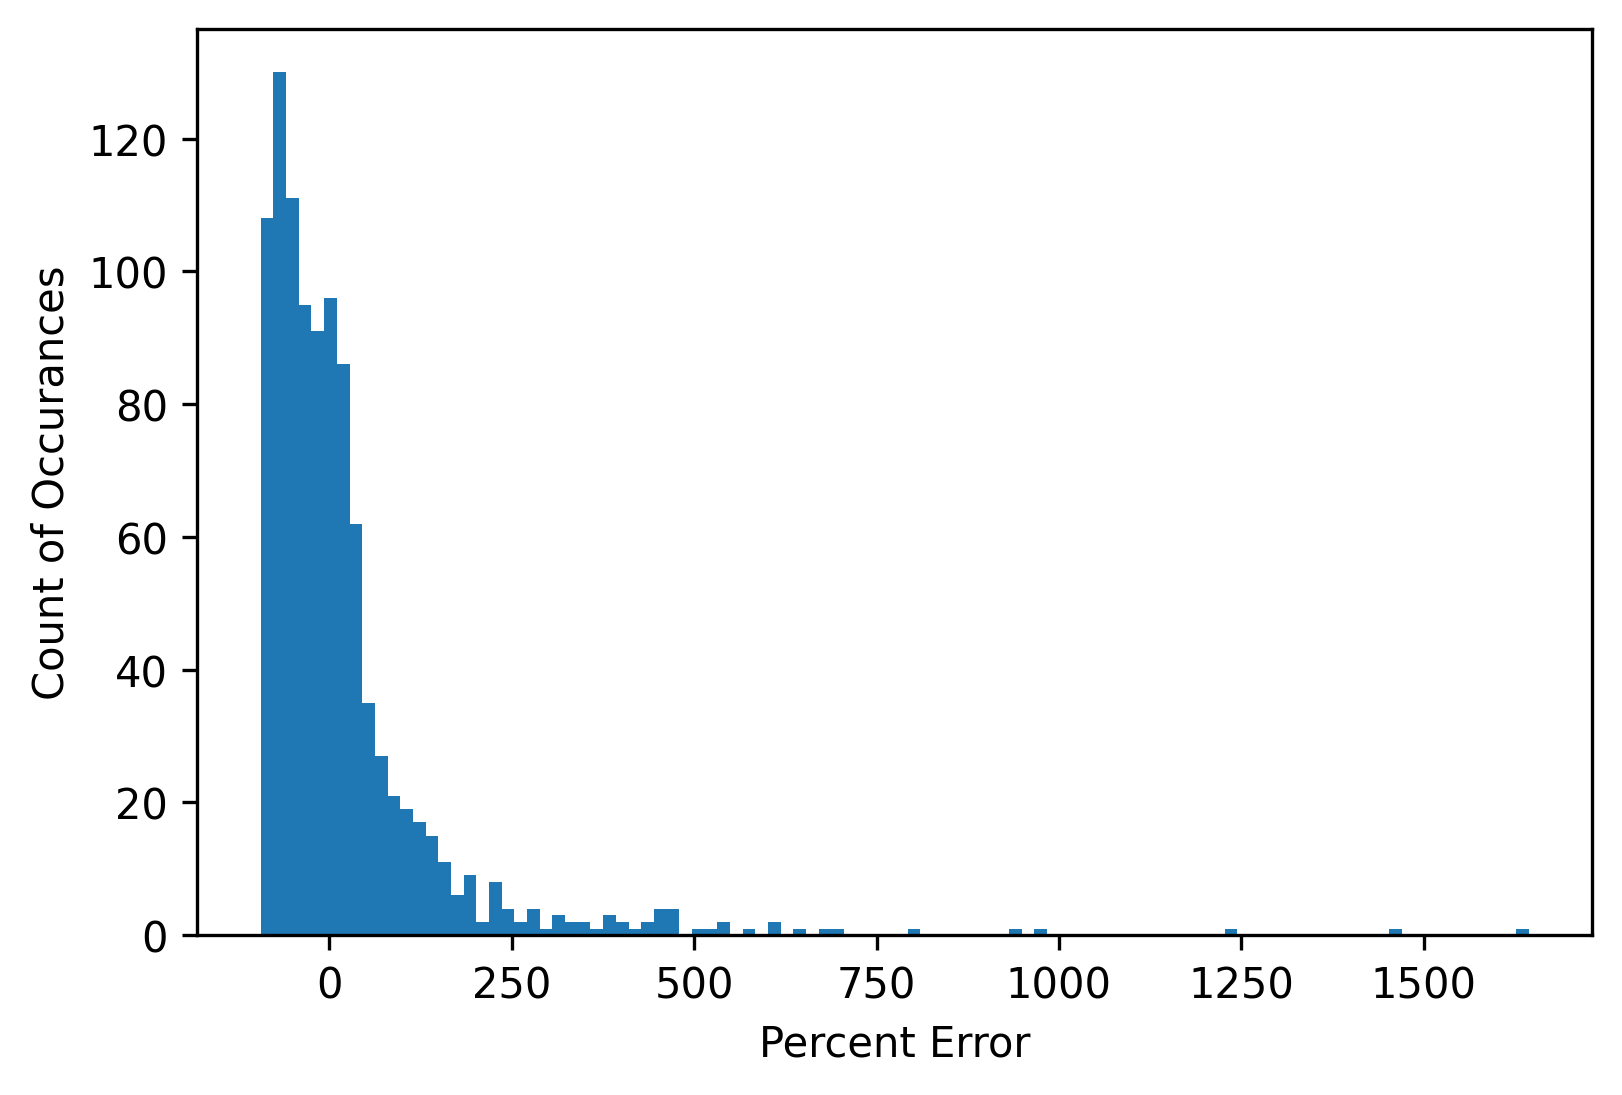

In [62]:
# Check the noiseless eval2 data set
m_error2 = 0
for i in range(len(out_m_eval2)):
    predicted_m_eval2 = np.array(clf_m.predict([in_svm_all_eval2[i]])).item()
    real_m_eval2 = np.array(out_m_eval2[i])
    # print(f"Predict: {predicted_m0} and Real: {real_m0}")
    if predicted_m_eval2 != real_m_eval2:
        m_error2 += 1

# print(f"m error: {m_error2}")

n_error2 = 0
for i in range(len(out_n_eval2)):
    predicted_n_eval2 = np.array(clf_n.predict([in_svm_all_eval2[i]])).item()
    real_n_eval2 = np.array(out_n_eval2[i])
    # print(f"Predict: {predicted_m0} and Real: {real_m0}")
    if predicted_n_eval2 != real_n_eval2:
        n_error2 += 1

# print(f"n error: {n_error2}")

mode_error2 = 0
for i in range(len(out_mode_eval2)):
    predicted_mode_eval2 = np.array(clf_mode.predict([in_svm_all_eval2[i]])).item()
    real_mode_eval2 = np.array(out_mode_eval2[i])
    # print(f"Predict: {predicted_m0} and Real: {real_m0}")
    if predicted_mode_eval2 != real_mode_eval2:
        mode_error2 += 1

# print(f"mode error: {mode_error2}")

comp_error2 = 0
for i in range(len(out_component_eval2)):
    predicted_comp_eval2 = np.array(clf_comp.predict([in_svm_all_eval2[i]])).item()
    real_comp_eval2 = np.array(out_component_eval2[i])
    # print(f"Predict: {predicted_comp_eval2} and Real: {real_comp_eval2}")
    if predicted_comp_eval2 != real_comp_eval2:
        comp_error2 += 1

# print(f"comp error: {comp_error2}")

perc_error2 = np.zeros(len(out_freq_eval2))
for i in range(len(out_freq_eval2)):
    predicted_freq_eval2 = np.array(reg_freq.predict([in_svm_all_eval2[i]])).item()
    real_freq_eval2 = np.array(out_freq_eval2[i])
    # print(f"Predict: {predicted_freq_eval2} and Real: {real_freq_eval2}")
    perc_error2[i] = ((predicted_freq_eval2-real_freq_eval2)/real_freq_eval2)*100


mean_perc_error2 = np.mean(perc_error2)
median_perc_error2 = np.median(perc_error2)
min_perc_error2 = np.min(perc_error2)
max_perc_error2 = np.max(perc_error2)

print(f"m error: {m_error2}")
print(f"n error: {n_error2}")
print(f"mode error: {mode_error2}")
print(f"comp error: {comp_error2}")
print(f"mean freq error: {mean_perc_error2}")
print(f"median freq error: {median_perc_error2}")
print(f"min freq error: {min_perc_error2}")
print(f"max freq error: {max_perc_error2}")

plt.hist(perc_error2, bins=100)
plt.xlabel("Percent Error")
plt.ylabel("Count of Occurances")

m error: 18
n error: 21
mode error: 1
comp error: 2
mean freq error: 22.226783624551032
median freq error: -3.602961264743941
min freq error: -91.69366169092102
max freq error: 1344.4439011368156


Text(0, 0.5, 'Count of Occurances')

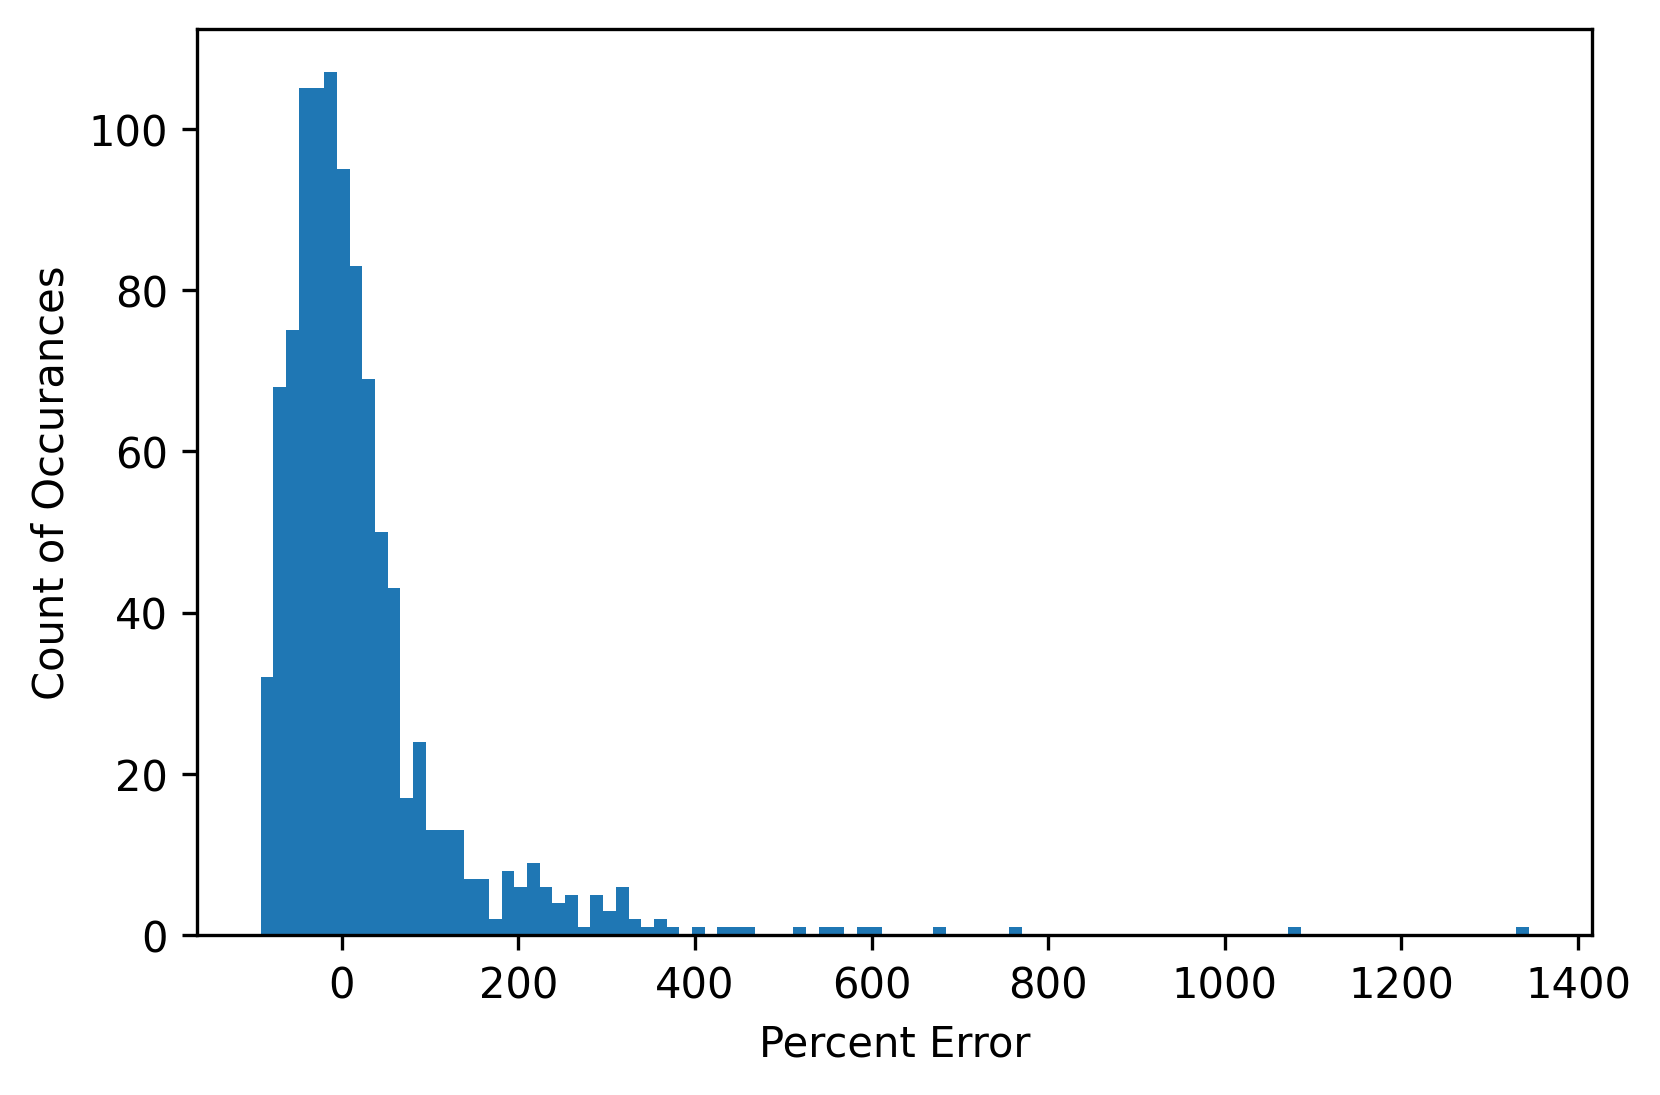

In [63]:
# Check the noiseless eval3 data set
m_error3 = 0
for i in range(len(out_m_eval3)):
    predicted_m_eval3 = np.array(clf_m.predict([in_svm_all_eval3[i]])).item()
    real_m_eval3 = np.array(out_m_eval3[i])
    # print(f"Predict: {predicted_m0} and Real: {real_m0}")
    if predicted_m_eval3 != real_m_eval3:
        m_error3 += 1

# print(f"m error: {m_error3}")

n_error3 = 0
for i in range(len(out_n_eval3)):
    predicted_n_eval3 = np.array(clf_n.predict([in_svm_all_eval3[i]])).item()
    real_n_eval3 = np.array(out_n_eval3[i])
    # print(f"Predict: {predicted_m0} and Real: {real_m0}")
    if predicted_n_eval3 != real_n_eval3:
        n_error3 += 1

# print(f"n error: {n_error3}")

mode_error3 = 0
for i in range(len(out_mode_eval3)):
    predicted_mode_eval3 = np.array(clf_mode.predict([in_svm_all_eval3[i]])).item()
    real_mode_eval3 = np.array(out_mode_eval3[i])
    # print(f"Predict: {predicted_m0} and Real: {real_m0}")
    if predicted_mode_eval3 != real_mode_eval3:
        mode_error3 += 1

# print(f"mode error: {mode_error3}")

comp_error3 = 0
for i in range(len(out_component_eval3)):
    predicted_comp_eval3 = np.array(clf_comp.predict([in_svm_all_eval3[i]])).item()
    real_comp_eval3 = np.array(out_component_eval3[i])
    # print(f"Predict: {predicted_comp_eval3} and Real: {real_comp_eval3}")
    if predicted_comp_eval3 != real_comp_eval3:
        comp_error3 += 1

# print(f"comp error: {comp_error3}")

perc_error3 = np.zeros(len(out_freq_eval3))
for i in range(len(out_freq_eval3)):
    predicted_freq_eval3 = np.array(reg_freq.predict([in_svm_all_eval3[i]])).item()
    real_freq_eval3 = np.array(out_freq_eval3[i])
    # print(f"Predict: {predicted_freq_eval3} and Real: {real_freq_eval3}")
    perc_error3[i] = ((predicted_freq_eval3-real_freq_eval3)/real_freq_eval3)*100


mean_perc_error3 = np.mean(perc_error3)
median_perc_error3 = np.median(perc_error3)
min_perc_error3 = np.min(perc_error3)
max_perc_error3 = np.max(perc_error3)

print(f"m error: {m_error3}")
print(f"n error: {n_error3}")
print(f"mode error: {mode_error3}")
print(f"comp error: {comp_error3}")
print(f"mean freq error: {mean_perc_error3}")
print(f"median freq error: {median_perc_error3}")
print(f"min freq error: {min_perc_error3}")
print(f"max freq error: {max_perc_error3}")

plt.hist(perc_error3, bins=100)
plt.xlabel("Percent Error")
plt.ylabel("Count of Occurances")

m error: 25
n error: 34
mode error: 20
comp error: 2
mean freq error: 36.060770469977754
median freq error: 4.288275464375165
min freq error: -94.51222271277977
max freq error: 1262.958779300561


Text(0, 0.5, 'Count of Occurances')

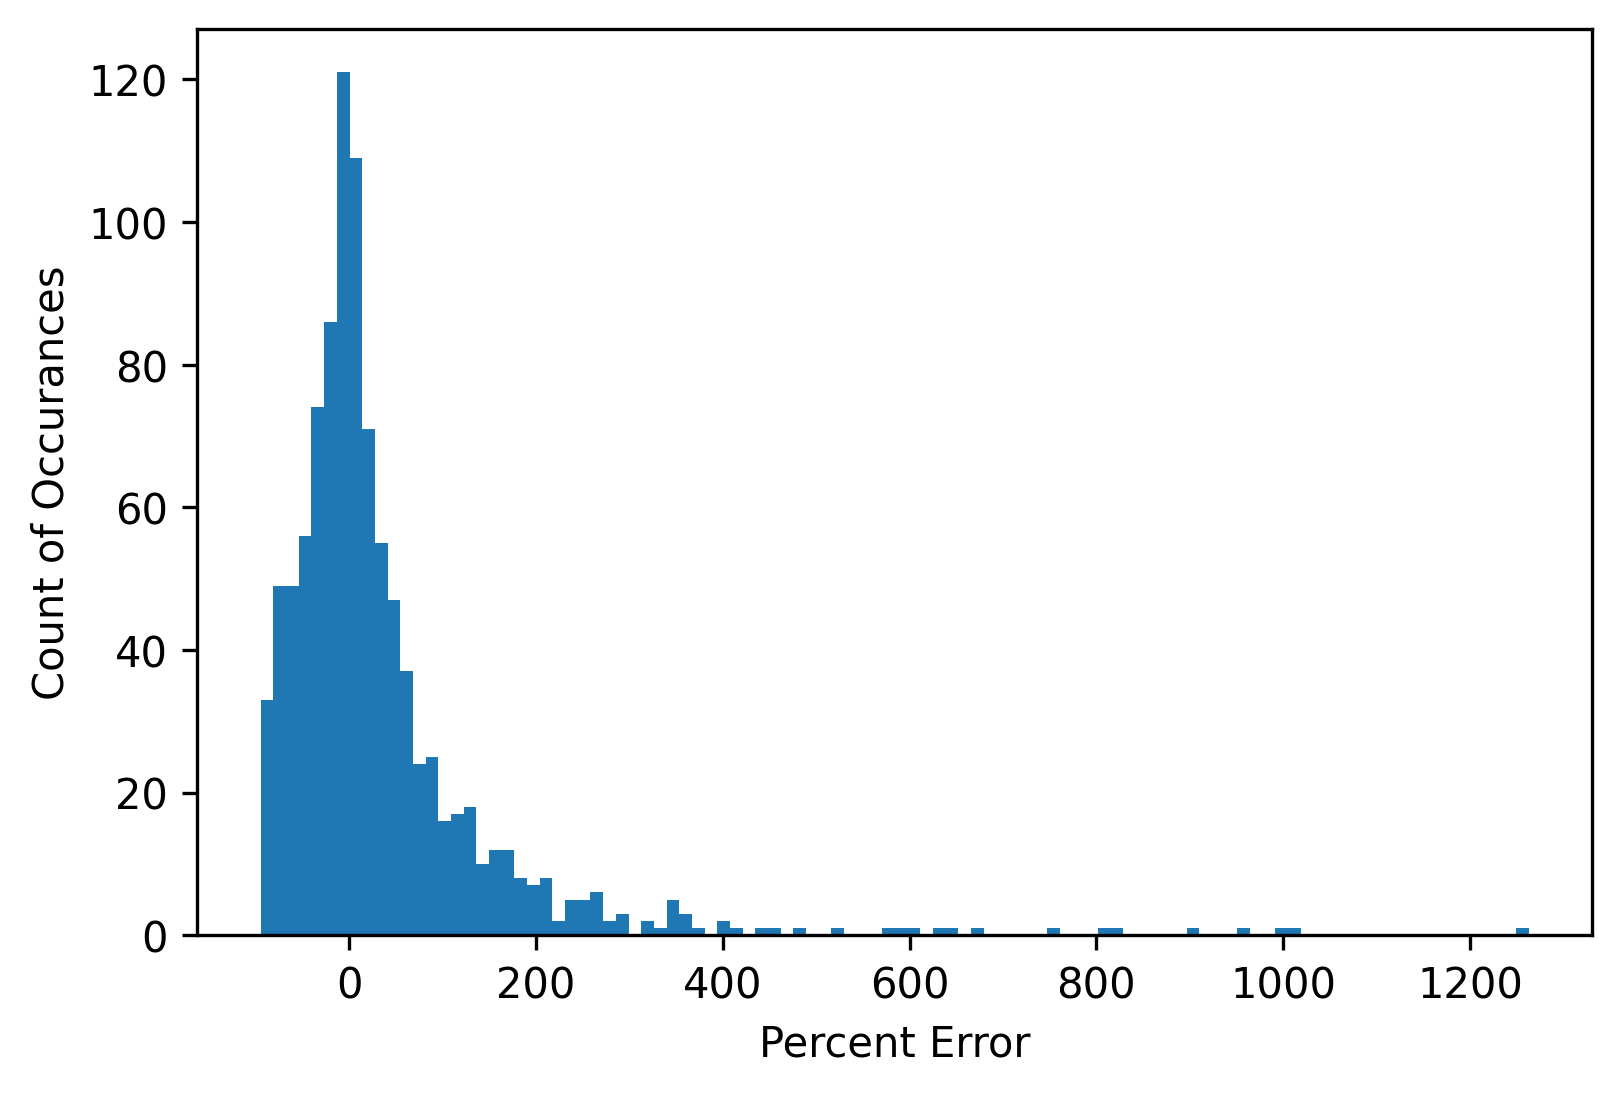

In [64]:
# Check the noiseless eval4 data set
m_error4 = 0
for i in range(len(out_m_eval4)):
    predicted_m_eval4 = np.array(clf_m.predict([in_svm_all_eval4[i]])).item()
    real_m_eval4 = np.array(out_m_eval4[i])
    # print(f"Predict: {predicted_m0} and Real: {real_m0}")
    if predicted_m_eval4 != real_m_eval4:
        m_error4 += 1

# print(f"m error: {m_error4}")

n_error4 = 0
for i in range(len(out_n_eval4)):
    predicted_n_eval4 = np.array(clf_n.predict([in_svm_all_eval4[i]])).item()
    real_n_eval4 = np.array(out_n_eval4[i])
    # print(f"Predict: {predicted_m0} and Real: {real_m0}")
    if predicted_n_eval4 != real_n_eval4:
        n_error4 += 1

# print(f"n error: {n_error4}")

mode_error4 = 0
for i in range(len(out_mode_eval4)):
    predicted_mode_eval4 = np.array(clf_mode.predict([in_svm_all_eval4[i]])).item()
    real_mode_eval4 = np.array(out_mode_eval4[i])
    # print(f"Predict: {predicted_m0} and Real: {real_m0}")
    if predicted_mode_eval4 != real_mode_eval4:
        mode_error4 += 1

# print(f"mode error: {mode_error4}")

comp_error4 = 0
for i in range(len(out_component_eval4)):
    predicted_comp_eval4 = np.array(clf_comp.predict([in_svm_all_eval4[i]])).item()
    real_comp_eval4 = np.array(out_component_eval4[i])
    # print(f"Predict: {predicted_comp_eval4} and Real: {real_comp_eval4}")
    if predicted_comp_eval4 != real_comp_eval4:
        comp_error4 += 1

# print(f"comp error: {comp_error4}")

perc_error4 = np.zeros(len(out_freq_eval4))
for i in range(len(out_freq_eval4)):
    predicted_freq_eval4 = np.array(reg_freq.predict([in_svm_all_eval4[i]])).item()
    real_freq_eval4 = np.array(out_freq_eval4[i])
    # print(f"Predict: {predicted_freq_eval4} and Real: {real_freq_eval4}")
    perc_error4[i] = ((predicted_freq_eval4-real_freq_eval4)/real_freq_eval4)*100


mean_perc_error4 = np.mean(perc_error4)
median_perc_error4 = np.median(perc_error4)
min_perc_error4 = np.min(perc_error4)
max_perc_error4 = np.max(perc_error4)

print(f"m error: {m_error4}")
print(f"n error: {n_error4}")
print(f"mode error: {mode_error4}")
print(f"comp error: {comp_error4}")
print(f"mean freq error: {mean_perc_error4}")
print(f"median freq error: {median_perc_error4}")
print(f"min freq error: {min_perc_error4}")
print(f"max freq error: {max_perc_error4}")

plt.hist(perc_error4, bins=100)
plt.xlabel("Percent Error")
plt.ylabel("Count of Occurances")

m error: 36
n error: 57
mode error: 102
comp error: 29
mean freq error: 40.96718840902868
median freq error: 2.5226001192281244
min freq error: -95.67588737141118
max freq error: 2010.357485668455


Text(0, 0.5, 'Count of Occurances')

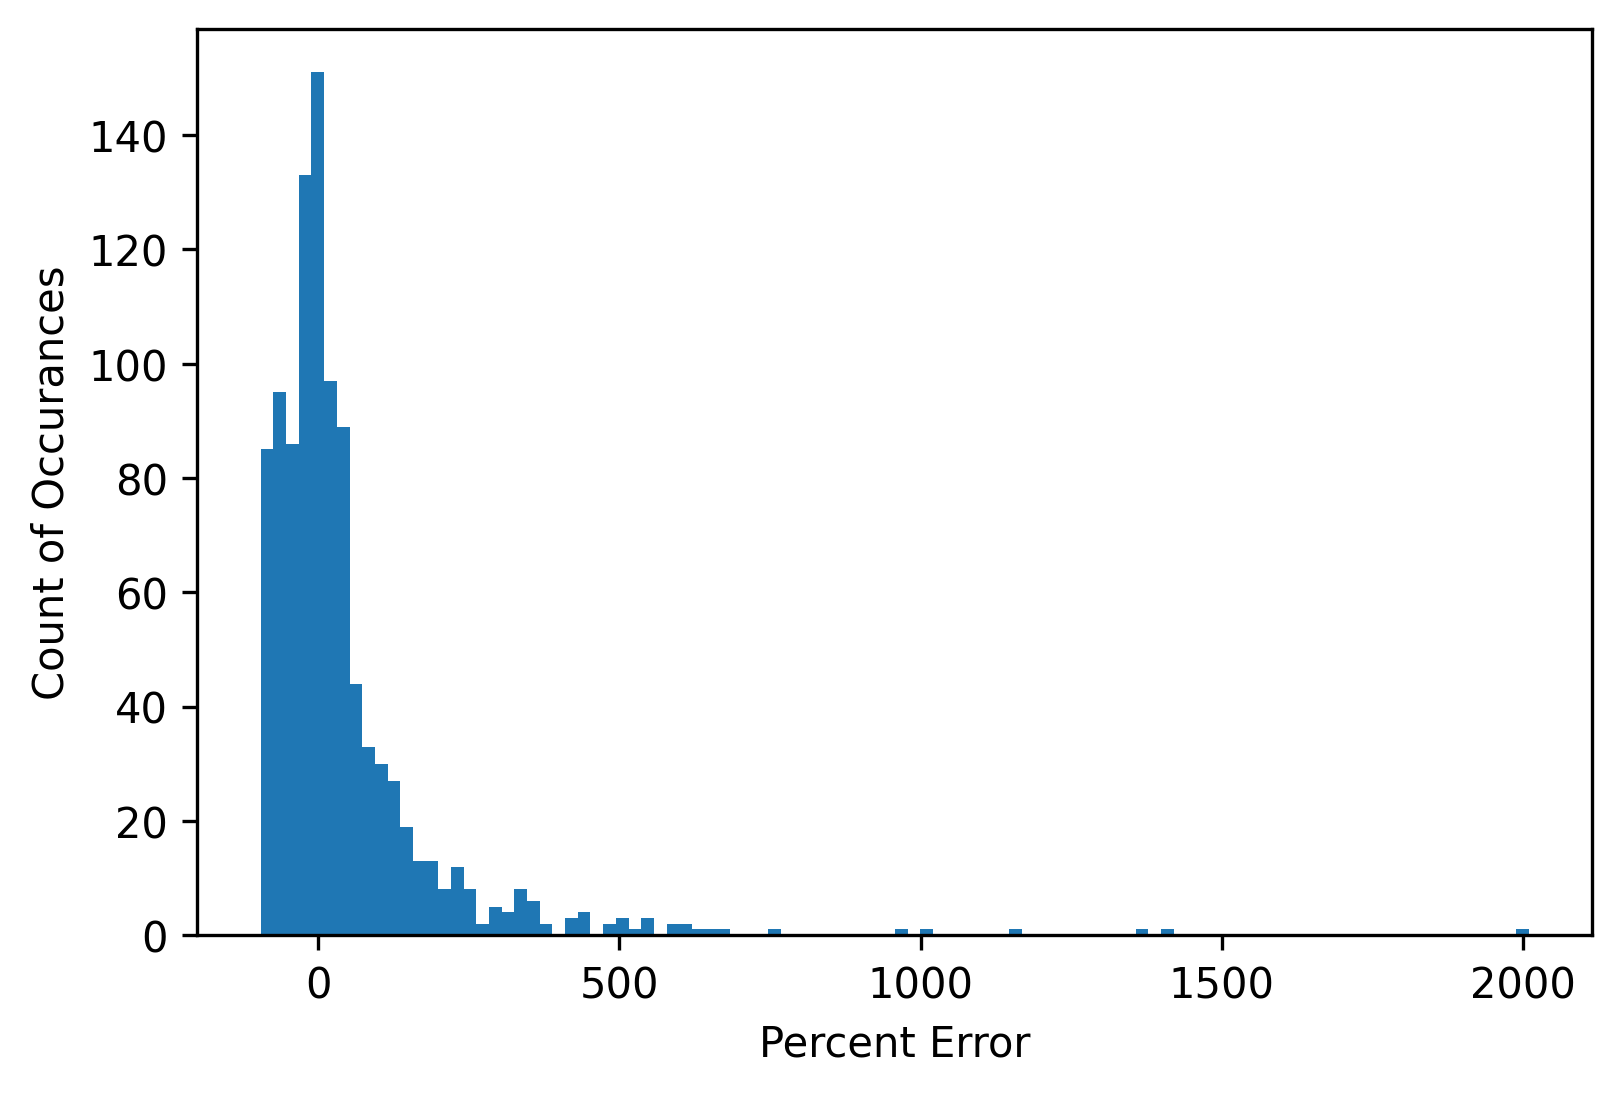

In [65]:
# Check the noiseless eval5 data set
m_error5 = 0
for i in range(len(out_m_eval5)):
    predicted_m_eval5 = np.array(clf_m.predict([in_svm_all_eval5[i]])).item()
    real_m_eval5 = np.array(out_m_eval5[i])
    # print(f"Predict: {predicted_m0} and Real: {real_m0}")
    if predicted_m_eval5 != real_m_eval5:
        m_error5 += 1

# print(f"m error: {m_error5}")

n_error5 = 0
for i in range(len(out_n_eval5)):
    predicted_n_eval5 = np.array(clf_n.predict([in_svm_all_eval5[i]])).item()
    real_n_eval5 = np.array(out_n_eval5[i])
    # print(f"Predict: {predicted_m0} and Real: {real_m0}")
    if predicted_n_eval5 != real_n_eval5:
        n_error5 += 1

# print(f"n error: {n_error5}")

mode_error5 = 0
for i in range(len(out_mode_eval5)):
    predicted_mode_eval5 = np.array(clf_mode.predict([in_svm_all_eval5[i]])).item()
    real_mode_eval5 = np.array(out_mode_eval5[i])
    # print(f"Predict: {predicted_m0} and Real: {real_m0}")
    if predicted_mode_eval5 != real_mode_eval5:
        mode_error5 += 1

# print(f"mode error: {mode_error5}")

comp_error5 = 0
for i in range(len(out_component_eval5)):
    predicted_comp_eval5 = np.array(clf_comp.predict([in_svm_all_eval5[i]])).item()
    real_comp_eval5 = np.array(out_component_eval5[i])
    # print(f"Predict: {predicted_comp_eval5} and Real: {real_comp_eval5}")
    if predicted_comp_eval5 != real_comp_eval5:
        comp_error5 += 1

# print(f"comp error: {comp_error5}")

perc_error5 = np.zeros(len(out_freq_eval5))
for i in range(len(out_freq_eval5)):
    predicted_freq_eval5 = np.array(reg_freq.predict([in_svm_all_eval5[i]])).item()
    real_freq_eval5 = np.array(out_freq_eval5[i])
    # print(f"Predict: {predicted_freq_eval5} and Real: {real_freq_eval5}")
    perc_error5[i] = ((predicted_freq_eval5-real_freq_eval5)/real_freq_eval5)*100


mean_perc_error5 = np.mean(perc_error5)
median_perc_error5 = np.median(perc_error5)
min_perc_error5 = np.min(perc_error5)
max_perc_error5 = np.max(perc_error5)

print(f"m error: {m_error5}")
print(f"n error: {n_error5}")
print(f"mode error: {mode_error5}")
print(f"comp error: {comp_error5}")
print(f"mean freq error: {mean_perc_error5}")
print(f"median freq error: {median_perc_error5}")
print(f"min freq error: {min_perc_error5}")
print(f"max freq error: {max_perc_error5}")

plt.hist(perc_error5, bins=100)
plt.xlabel("Percent Error")
plt.ylabel("Count of Occurances")

Text(0, 0.5, 'Error Count')

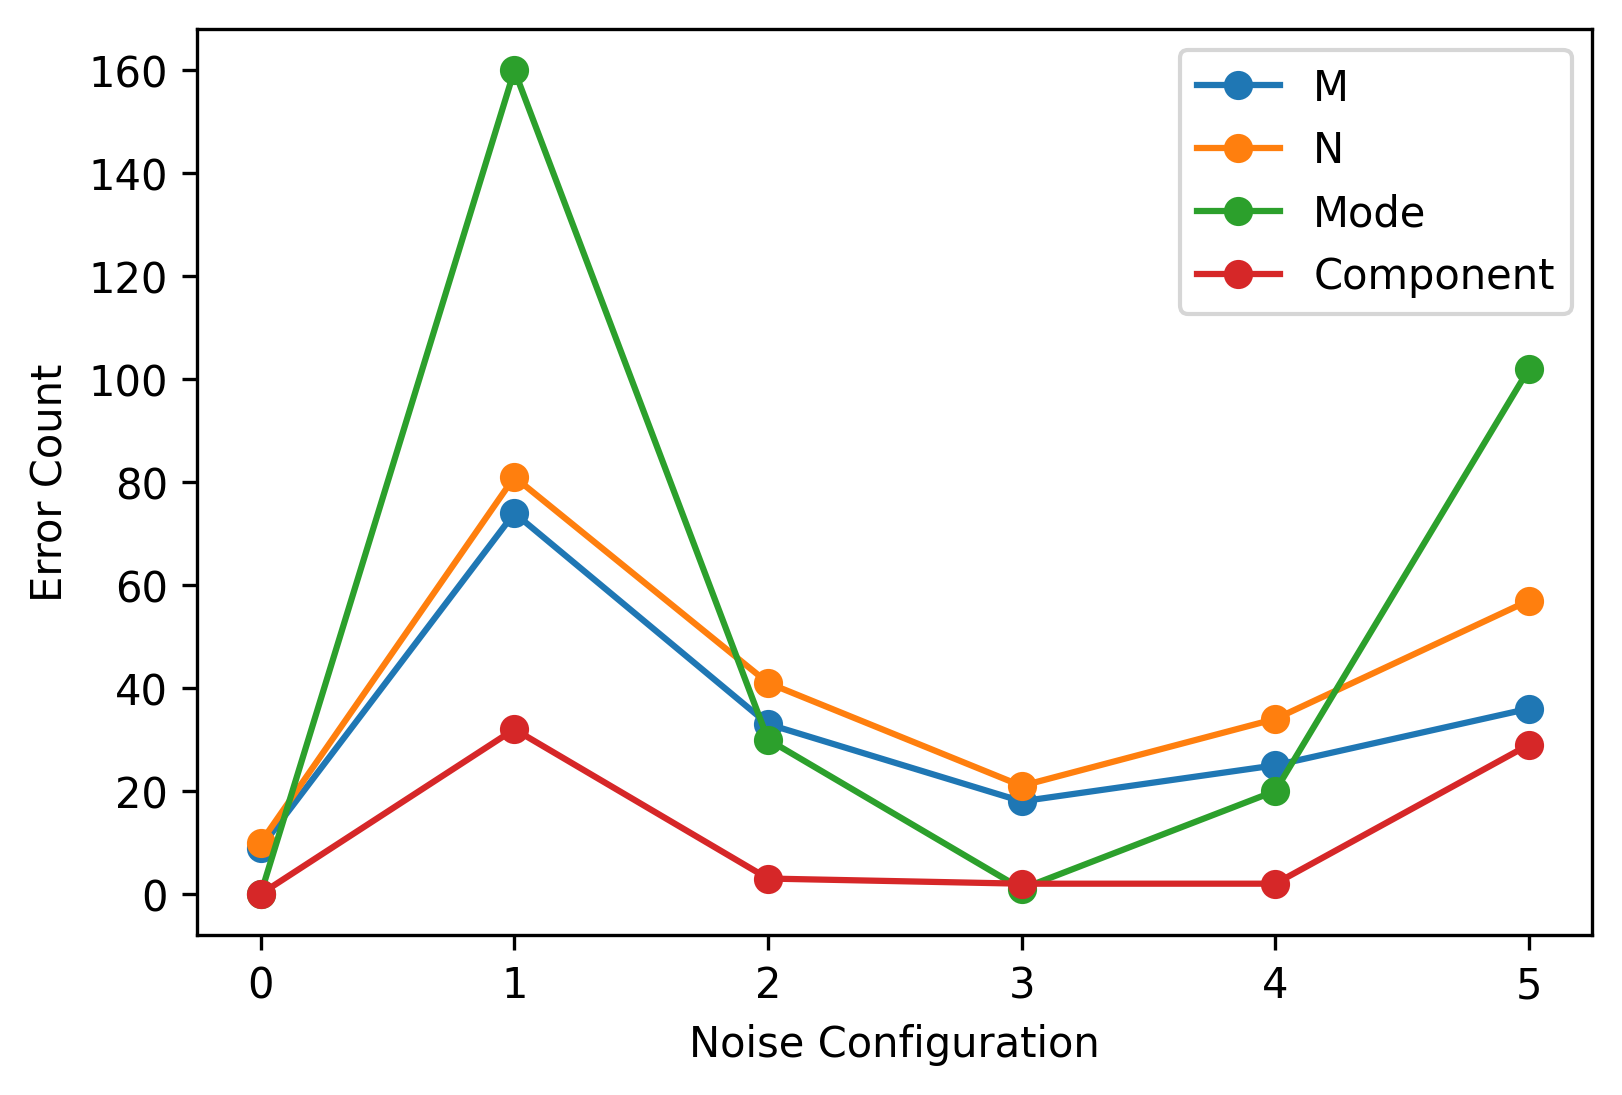

In [66]:
# Plot comparisons
x_axis_vals = [0, 1, 2, 3, 4, 5]
m_err_tot = [m_error0, m_error1,m_error2,m_error3,m_error4,m_error5]
n_err_tot = [n_error0, n_error1,n_error2,n_error3,n_error4,n_error5]
mode_err_tot = [mode_error0, mode_error1,mode_error2,mode_error3,mode_error4,mode_error5]
comp_err_tot = [comp_error0, comp_error1,comp_error2,comp_error3,comp_error4,comp_error5]

plt.plot(x_axis_vals, m_err_tot, marker="o")
plt.plot(x_axis_vals, n_err_tot, marker="o")
plt.plot(x_axis_vals, mode_err_tot, marker="o")
plt.plot(x_axis_vals, comp_err_tot, marker="o")
plt.legend(['M', 'N', 'Mode', 'Component'])
plt.xlabel("Noise Configuration")
plt.ylabel("Error Count")

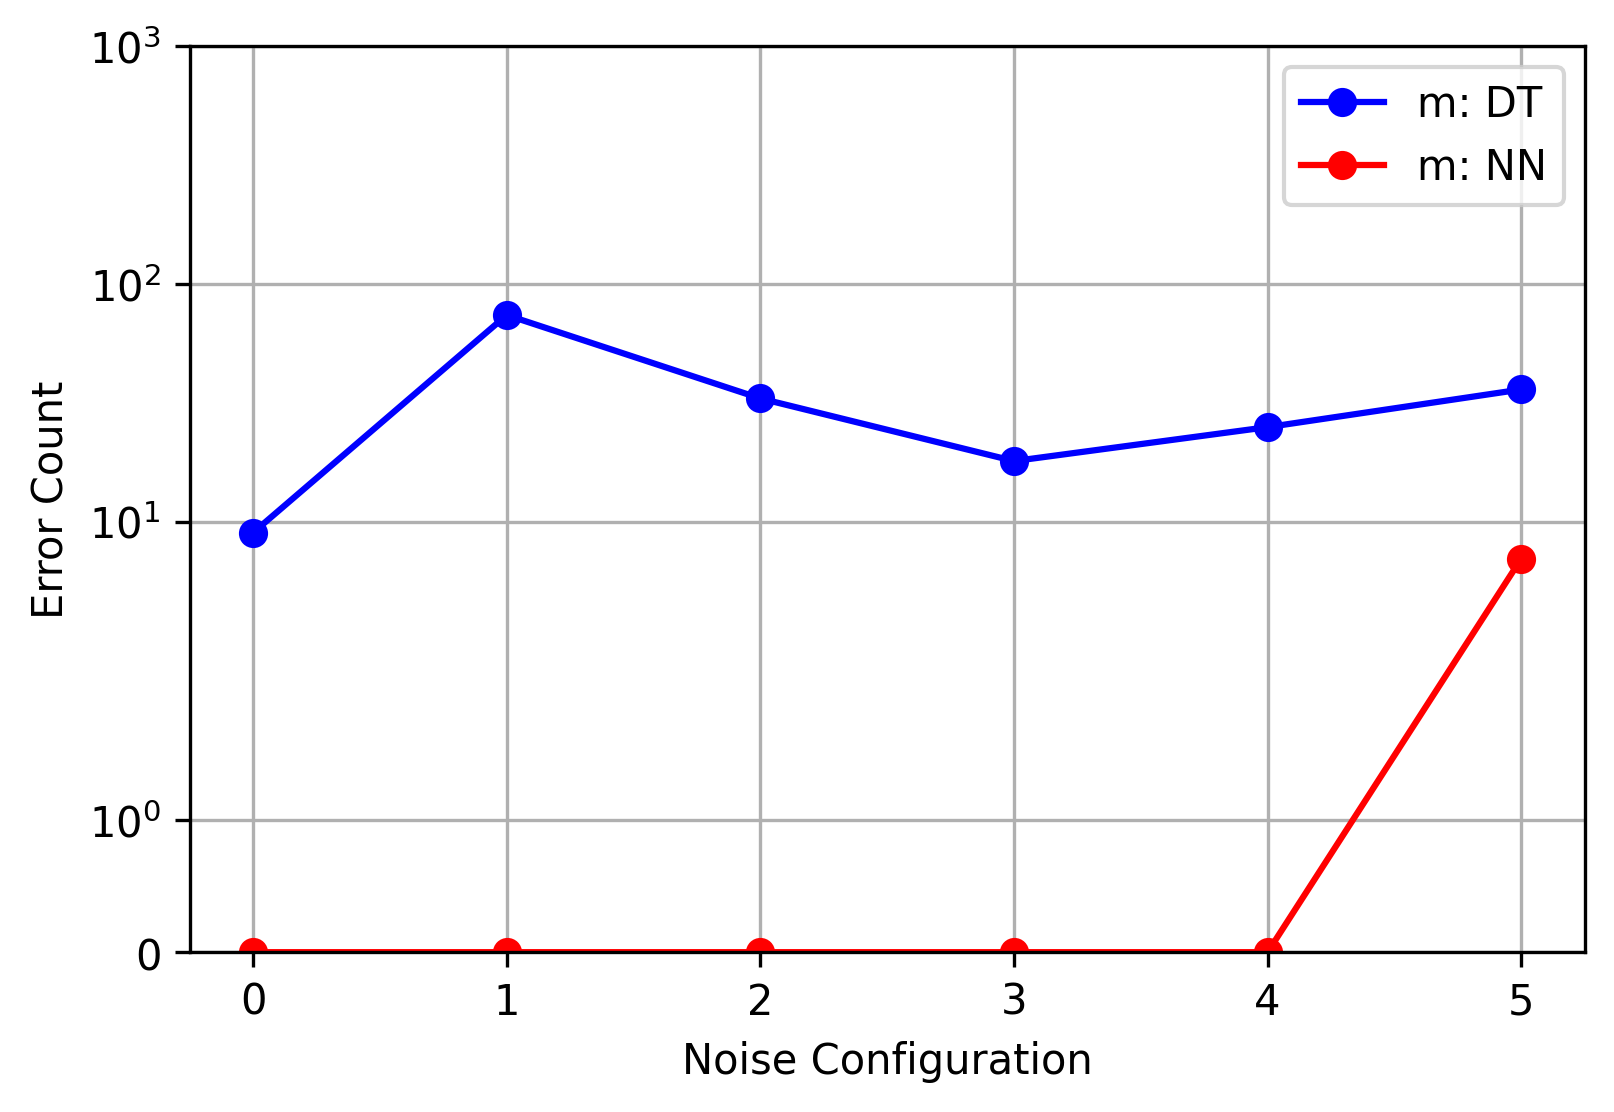

In [67]:
# Plot comparisons
x_axis_vals = [0, 1, 2, 3, 4, 5]
m_err_tot_dt = [m_error0, m_error1,m_error2,m_error3,m_error4,m_error5]
n_err_tot_dt = [n_error0, n_error1,n_error2,n_error3,n_error4,n_error5]
mode_err_tot_dt = [mode_error0, mode_error1,mode_error2,mode_error3,mode_error4,mode_error5]
comp_err_tot_dt = [comp_error0, comp_error1,comp_error2,comp_error3,comp_error4,comp_error5]

# Plot comparisons
m_err_tot_nn = [sum_m_error0, sum_m_error1,sum_m_error2,sum_m_error3,sum_m_error4,sum_m_error5]
n_err_tot_nn = [sum_n_error0, sum_n_error1,sum_n_error2,sum_n_error3,sum_n_error4,sum_n_error5]
mode_err_tot_nn = [sum_mode_error0, sum_mode_error1,sum_mode_error2,sum_mode_error3,sum_mode_error4,sum_mode_error5]
comp_err_tot_nn = [sum_comp_error0, sum_comp_error1,sum_comp_error2,sum_comp_error3,sum_comp_error4,sum_comp_error5]

plt.plot(x_axis_vals, m_err_tot_dt, marker="o", color="b", label="m: DT")
plt.plot(x_axis_vals, m_err_tot_nn, marker="o", color="r", label="m: NN")
plt.xlabel("Noise Configuration")
plt.ylabel("Error Count")
plt.yscale("symlog")
plt.grid(which="both")
plt.ylim(0, 1e3)
plt.legend()

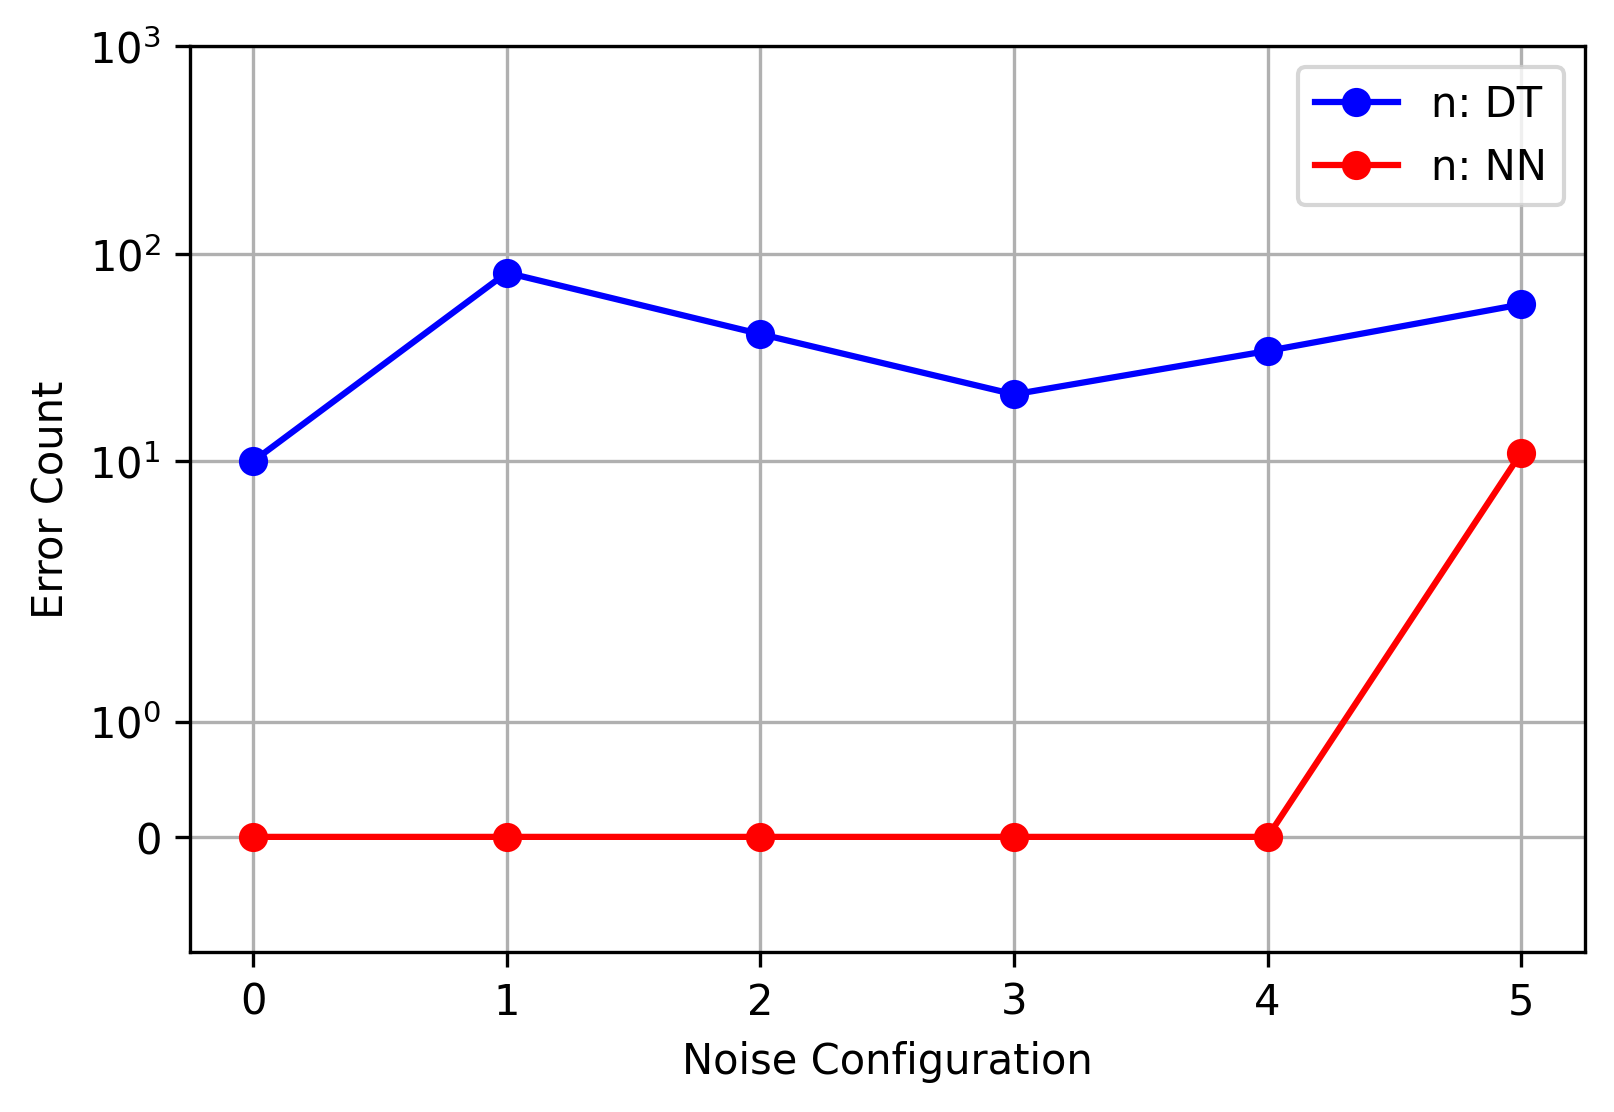

In [68]:
plt.plot(x_axis_vals, n_err_tot_dt, marker="o", color="b", label="n: DT")
plt.plot(x_axis_vals, n_err_tot_nn, marker="o", color="r", label="n: NN")
plt.xlabel("Noise Configuration")
plt.ylabel("Error Count")
plt.yscale("symlog")
plt.grid(which="both")
plt.ylim(-1, 1e3)
plt.legend()

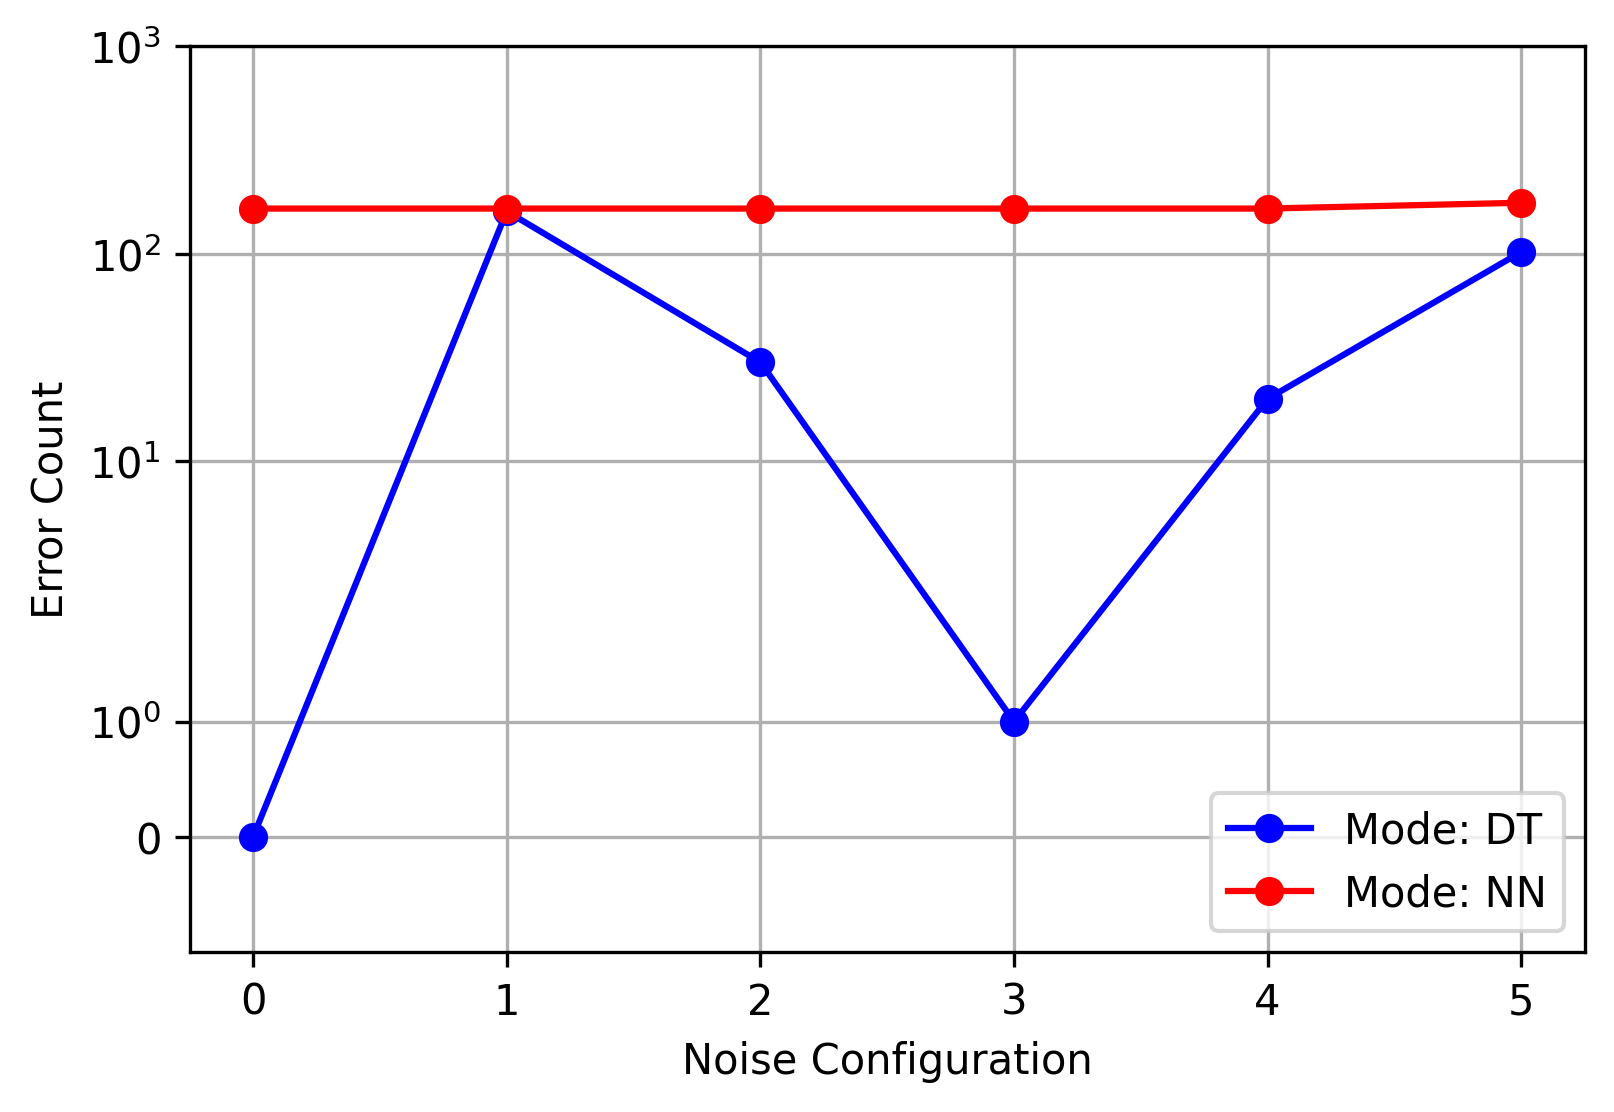

In [69]:
plt.plot(x_axis_vals, mode_err_tot_dt, marker="o", color="b", label="Mode: DT")
plt.plot(x_axis_vals, mode_err_tot_nn, marker="o", color="r", label="Mode: NN")
plt.xlabel("Noise Configuration")
plt.ylabel("Error Count")
plt.yscale("symlog")
plt.grid(which="both")
plt.ylim(-1, 1e3)
plt.legend(loc="lower right")

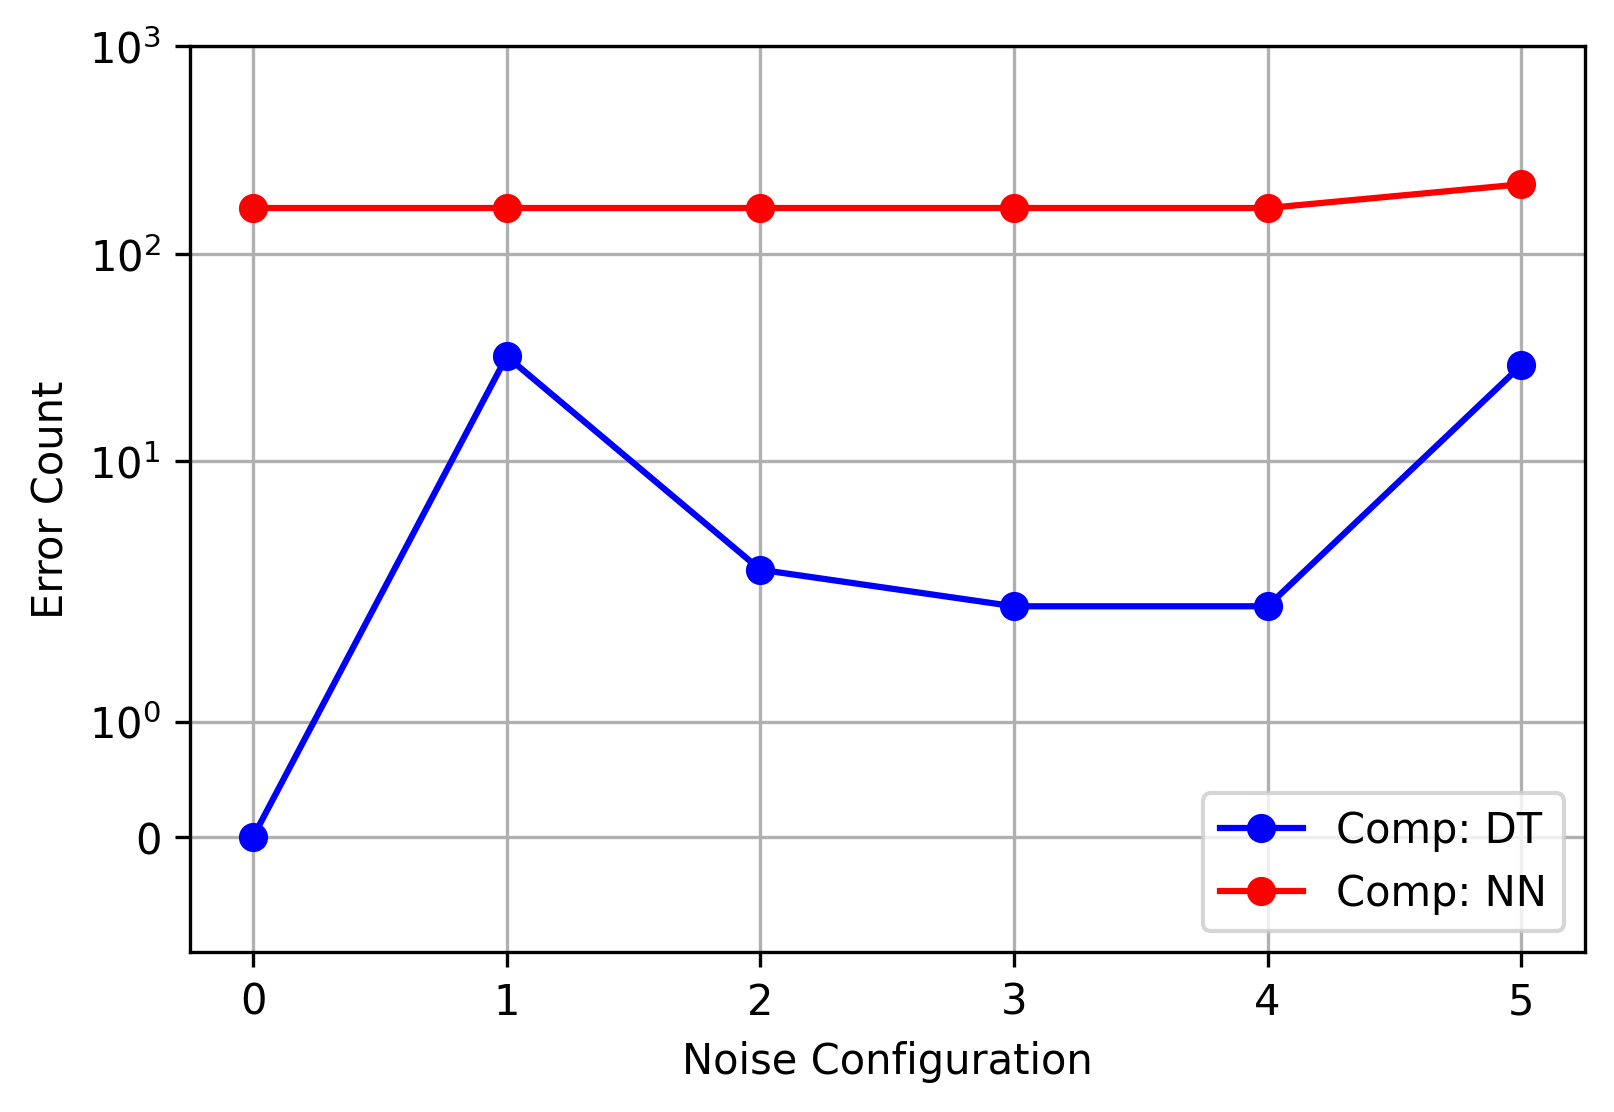

In [70]:
plt.plot(x_axis_vals, comp_err_tot_dt, marker="o", color="b", label="Comp: DT")
plt.plot(x_axis_vals, comp_err_tot_nn, marker="o", color="r", label="Comp: NN")
plt.xlabel("Noise Configuration")
plt.ylabel("Error Count")
plt.yscale("symlog")
plt.grid(which="both")
plt.ylim(-1, 1e3)
plt.legend(loc="lower right")

INFO:matplotlib.font_manager:Fontsize 0.46 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.46 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.46 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.46 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.46 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.46 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.46 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.46 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.46 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.46 < 1.0 pt not allowed by FreeType. Setting fontsi

[Text(0.23830331920903955, 0.9736842105263158, 'X[2530] <= 0.0\ngini = 0.667\nsamples = 25000\nvalue = [8487, 8264, 8249]'),
 Text(0.1765536723163842, 0.9210526315789473, 'X[20099] <= 0.785\ngini = 0.037\nsamples = 3927\nvalue = [52, 3854, 21]'),
 Text(0.1652542372881356, 0.868421052631579, 'gini = 0.0\nsamples = 3853\nvalue = [0, 3853, 0]'),
 Text(0.18785310734463276, 0.868421052631579, 'X[15665] <= 0.0\ngini = 0.425\nsamples = 74\nvalue = [52, 1, 21]'),
 Text(0.1765536723163842, 0.8157894736842105, 'X[14276] <= 2.356\ngini = 0.087\nsamples = 22\nvalue = [0, 1, 21]'),
 Text(0.1652542372881356, 0.7631578947368421, 'gini = 0.0\nsamples = 21\nvalue = [0, 0, 21]'),
 Text(0.18785310734463276, 0.7631578947368421, 'gini = 0.0\nsamples = 1\nvalue = [0, 1, 0]'),
 Text(0.19915254237288135, 0.8157894736842105, 'gini = 0.0\nsamples = 52\nvalue = [52, 0, 0]'),
 Text(0.3000529661016949, 0.9210526315789473, 'X[12322] <= 2.356\ngini = 0.644\nsamples = 21073\nvalue = [8435, 4410, 8228]'),
 Text(0.2887

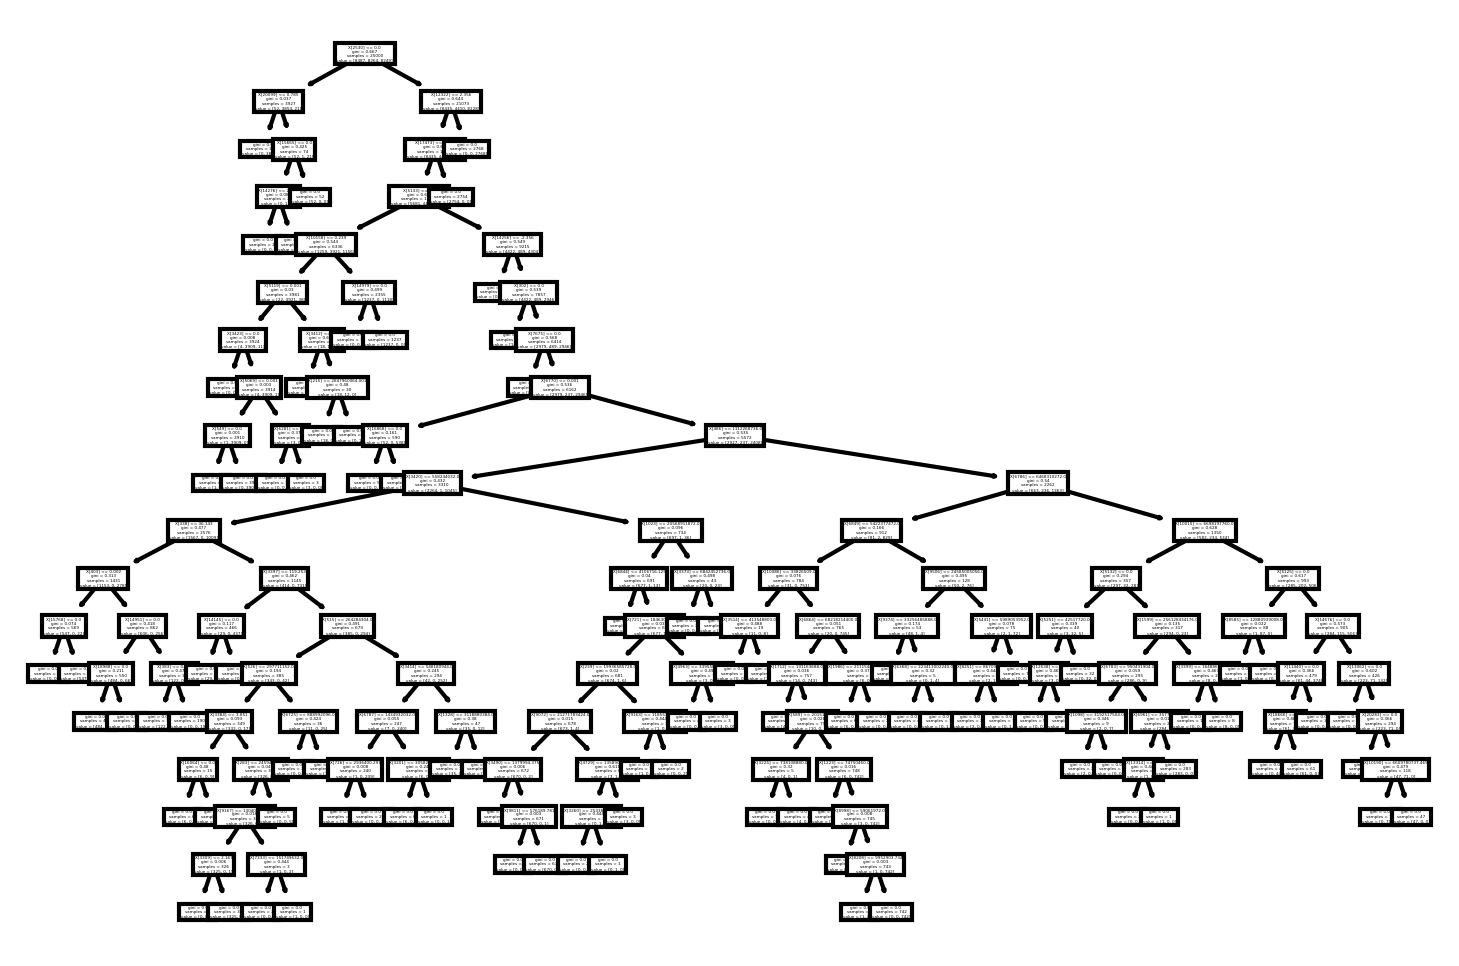

In [71]:
tree.plot_tree(clf_m, max_depth=3)

# Extras!
Try the gaussian noisy data in this algorithm (both nn and dt)
Try this data in the gaussian algorithm (both nn and dt)

In [32]:
# Open up the model
model_gauss = keras.models.load_model('./keras_model_gaussian')

# Need to perform an evaluation
# Create eval data, 1k samples
eval_data = p4.create_training_data(1000)

eval_data_noise_0p01 = p4.noise_gen_data(eval_data, 0.01)
eval_data_noise_0p10 = p4.noise_gen_data(eval_data, 0.1)
eval_data_noise_1p00 = p4.noise_gen_data(eval_data, 1.0)
eval_data_noise_10p0 = p4.noise_gen_data(eval_data, 10.0)
eval_data_noise_100p = p4.noise_gen_data(eval_data, 100.0)

# Prep eval data
# Prepare test data
in_mag_eval0 = []
for i in range(len(eval_data.mag_rad)):
    in_mag_eval0.append(abs(eval_data.mag_rad[i]))
in_mag_eval0 = np.asarray(in_mag_eval0)
in_angle_eval0 = []
for i in range(len(eval_data.mag_rad)):
    in_angle_eval0.append(tf.convert_to_tensor(np.angle(eval_data.mag_rad[i])))
in_angle_eval0 = np.asarray(in_angle_eval0)
in_width_eval0 = tf.convert_to_tensor(eval_data.width.values)
in_height_eval0 = tf.convert_to_tensor(eval_data.height.values)
out_m_eval0 = tf.convert_to_tensor(eval_data.m.values.astype(np.int))
out_n_eval0 = tf.convert_to_tensor(eval_data.n.values.astype(np.int))
out_mode_eval0 = tf.convert_to_tensor(eval_data['mode'].values.astype(np.int))
out_freq_eval0 = tf.convert_to_tensor(eval_data.freq.values)
out_component_eval0 = tf.convert_to_tensor(eval_data.component.values.astype(np.int))

in_mag_eval1 = []
for i in range(len(eval_data_noise_0p01.mag_rad)):
    in_mag_eval1.append(abs(eval_data_noise_0p01.mag_rad[i]))
in_mag_eval1 = np.asarray(in_mag_eval1)
in_angle_eval1 = []
for i in range(len(eval_data_noise_0p01.mag_rad)):
    in_angle_eval1.append(tf.convert_to_tensor(np.angle(eval_data_noise_0p01.mag_rad[i])))
in_angle_eval1 = np.asarray(in_angle_eval1)
in_width_eval1 = tf.convert_to_tensor(eval_data_noise_0p01.width.values)
in_height_eval1 = tf.convert_to_tensor(eval_data_noise_0p01.height.values)
out_m_eval1 = tf.convert_to_tensor(eval_data_noise_0p01.m.values.astype(np.int))
out_n_eval1 = tf.convert_to_tensor(eval_data_noise_0p01.n.values.astype(np.int))
out_mode_eval1 = tf.convert_to_tensor(eval_data_noise_0p01['mode'].values.astype(np.int))
out_freq_eval1 = tf.convert_to_tensor(eval_data_noise_0p01.freq.values)
out_component_eval1 = tf.convert_to_tensor(eval_data_noise_0p01.component.values.astype(np.int))

in_mag_eval2 = []
for i in range(len(eval_data_noise_0p10.mag_rad)):
    in_mag_eval2.append(abs(eval_data_noise_0p10.mag_rad[i]))
in_mag_eval2 = np.asarray(in_mag_eval2)
in_angle_eval2 = []
for i in range(len(eval_data_noise_0p10.mag_rad)):
    in_angle_eval2.append(tf.convert_to_tensor(np.angle(eval_data_noise_0p10.mag_rad[i])))
in_angle_eval2 = np.asarray(in_angle_eval2)
in_width_eval2 = tf.convert_to_tensor(eval_data_noise_0p10.width.values)
in_height_eval2 = tf.convert_to_tensor(eval_data_noise_0p10.height.values)
out_m_eval2 = tf.convert_to_tensor(eval_data_noise_0p10.m.values.astype(np.int))
out_n_eval2 = tf.convert_to_tensor(eval_data_noise_0p10.n.values.astype(np.int))
out_mode_eval2 = tf.convert_to_tensor(eval_data_noise_0p10['mode'].values.astype(np.int))
out_freq_eval2 = tf.convert_to_tensor(eval_data_noise_0p10.freq.values)
out_component_eval2 = tf.convert_to_tensor(eval_data_noise_0p10.component.values.astype(np.int))

in_mag_eval3 = []
for i in range(len(eval_data_noise_1p00.mag_rad)):
    in_mag_eval3.append(abs(eval_data_noise_1p00.mag_rad[i]))
in_mag_eval3 = np.asarray(in_mag_eval3)
in_angle_eval3 = []
for i in range(len(eval_data_noise_1p00.mag_rad)):
    in_angle_eval3.append(tf.convert_to_tensor(np.angle(eval_data_noise_1p00.mag_rad[i])))
in_angle_eval3 = np.asarray(in_angle_eval3)
in_width_eval3 = tf.convert_to_tensor(eval_data_noise_1p00.width.values)
in_height_eval3 = tf.convert_to_tensor(eval_data_noise_1p00.height.values)
out_m_eval3 = tf.convert_to_tensor(eval_data_noise_1p00.m.values.astype(np.int))
out_n_eval3 = tf.convert_to_tensor(eval_data_noise_1p00.n.values.astype(np.int))
out_mode_eval3 = tf.convert_to_tensor(eval_data_noise_1p00['mode'].values.astype(np.int))
out_freq_eval3 = tf.convert_to_tensor(eval_data_noise_1p00.freq.values)
out_component_eval3 = tf.convert_to_tensor(eval_data_noise_1p00.component.values.astype(np.int))

in_mag_eval4 = []
for i in range(len(eval_data_noise_10p0.mag_rad)):
    in_mag_eval4.append(abs(eval_data_noise_10p0.mag_rad[i]))
in_mag_eval4 = np.asarray(in_mag_eval4)
in_angle_eval4 = []
for i in range(len(eval_data_noise_10p0.mag_rad)):
    in_angle_eval4.append(tf.convert_to_tensor(np.angle(eval_data_noise_10p0.mag_rad[i])))
in_angle_eval4 = np.asarray(in_angle_eval4)
in_width_eval4 = tf.convert_to_tensor(eval_data_noise_10p0.width.values)
in_height_eval4 = tf.convert_to_tensor(eval_data_noise_10p0.height.values)
out_m_eval4 = tf.convert_to_tensor(eval_data_noise_10p0.m.values.astype(np.int))
out_n_eval4 = tf.convert_to_tensor(eval_data_noise_10p0.n.values.astype(np.int))
out_mode_eval4 = tf.convert_to_tensor(eval_data_noise_10p0['mode'].values.astype(np.int))
out_freq_eval4 = tf.convert_to_tensor(eval_data_noise_10p0.freq.values)
out_component_eval4 = tf.convert_to_tensor(eval_data_noise_10p0.component.values.astype(np.int))

in_mag_eval5 = []
for i in range(len(eval_data_noise_100p.mag_rad)):
    in_mag_eval5.append(abs(eval_data_noise_100p.mag_rad[i]))
in_mag_eval5 = np.asarray(in_mag_eval5)
in_angle_eval5 = []
for i in range(len(eval_data_noise_100p.mag_rad)):
    in_angle_eval5.append(tf.convert_to_tensor(np.angle(eval_data_noise_100p.mag_rad[i])))
in_angle_eval5 = np.asarray(in_angle_eval5)
in_width_eval5 = tf.convert_to_tensor(eval_data_noise_100p.width.values)
in_height_eval5 = tf.convert_to_tensor(eval_data_noise_100p.height.values)
out_m_eval5 = tf.convert_to_tensor(eval_data_noise_100p.m.values.astype(np.int))
out_n_eval5 = tf.convert_to_tensor(eval_data_noise_100p.n.values.astype(np.int))
out_mode_eval5 = tf.convert_to_tensor(eval_data_noise_100p['mode'].values.astype(np.int))
out_freq_eval5 = tf.convert_to_tensor(eval_data_noise_100p.freq.values)
out_component_eval5 = tf.convert_to_tensor(eval_data_noise_100p.component.values.astype(np.int))

# Evaluate Model
score0 = model_gauss.evaluate([[in_mag_eval0], [in_angle_eval0], in_width_eval0, in_height_eval0],
                        [out_m_eval0, out_n_eval0, out_mode_eval0, out_freq_eval0, out_component_eval0], verbose=1)

score1 = model_gauss.evaluate([[in_mag_eval1], [in_angle_eval1], in_width_eval1, in_height_eval1],
                        [out_m_eval1, out_n_eval1, out_mode_eval1, out_freq_eval1, out_component_eval1], verbose=1)

score2 = model_gauss.evaluate([[in_mag_eval2], [in_angle_eval2], in_width_eval2, in_height_eval2],
                        [out_m_eval2, out_n_eval2, out_mode_eval2, out_freq_eval2, out_component_eval2], verbose=1)

score3 = model_gauss.evaluate([[in_mag_eval3], [in_angle_eval3], in_width_eval3, in_height_eval3],
                        [out_m_eval3, out_n_eval3, out_mode_eval3, out_freq_eval3, out_component_eval3], verbose=1)

score4 = model_gauss.evaluate([[in_mag_eval4], [in_angle_eval4], in_width_eval4, in_height_eval4],
                        [out_m_eval4, out_n_eval4, out_mode_eval4, out_freq_eval4, out_component_eval4], verbose=1)

score5 = model_gauss.evaluate([[in_mag_eval5], [in_angle_eval5], in_width_eval5, in_height_eval5],
                        [out_m_eval5, out_n_eval5, out_mode_eval5, out_freq_eval5, out_component_eval5], verbose=1)

print(f"Score 0: {score0}")
print(f"Score 1: {score1}")
print(f"Score 2: {score2}")
print(f"Score 3: {score3}")
print(f"Score 4: {score4}")
print(f"Score 5: {score5}")

C:\Users\steph\Documents\Education\CLASS04_2022S_ECE504\Projects\ece504-final-waveguide-ml\Code\p4_functions.py:282: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output_data['mag_rad'][i] = add_noise(output_data['mag_rad'][i], std_deviation, "exponential")


32/32 [==============================] - 0s 7ms/step - loss: 261.2699 - output_m_loss: 9.0204 - output_n_loss: 0.0217 - output_mode_loss: 4.8540 - output_freq_loss: 2.7158 - output_comp_loss: 244.6580
Score 0: [5.221897125244141, 0.09958906471729279, 0.021703524515032768, 1.8022847175598145, 0.8174441456794739, 2.4808754920959473]
Score 1: [5.221871376037598, 0.09958906471729279, 0.021703524515032768, 1.8022847175598145, 0.8174187541007996, 2.4808754920959473]
Score 2: [5.221871376037598, 0.09958906471729279, 0.021703524515032768, 1.8022847175598145, 0.8174187541007996, 2.4808754920959473]
Score 3: [5.221960544586182, 0.09958906471729279, 0.021703524515032768, 1.8022847175598145, 0.8175073266029358, 2.4808754920959473]
Score 4: [6.8939104080200195, 0.09958906471729279, 0.021703524515032768, 1.8022847175598145, 0.9410830140113831, 4.0292510986328125]
Score 5: [261.2698669433594, 9.02037239074707, 0.021703524515032768, 4.853991985321045, 2.7158162593841553, 244.65802001953125]


m error: 12
n error: 9
mode error: 185
comp error: 184
mean freq error: 19.755481702592224
median freq error: -5.996564626693726
min freq error: -99.99938201904297
max freq error: 866.0538940429688


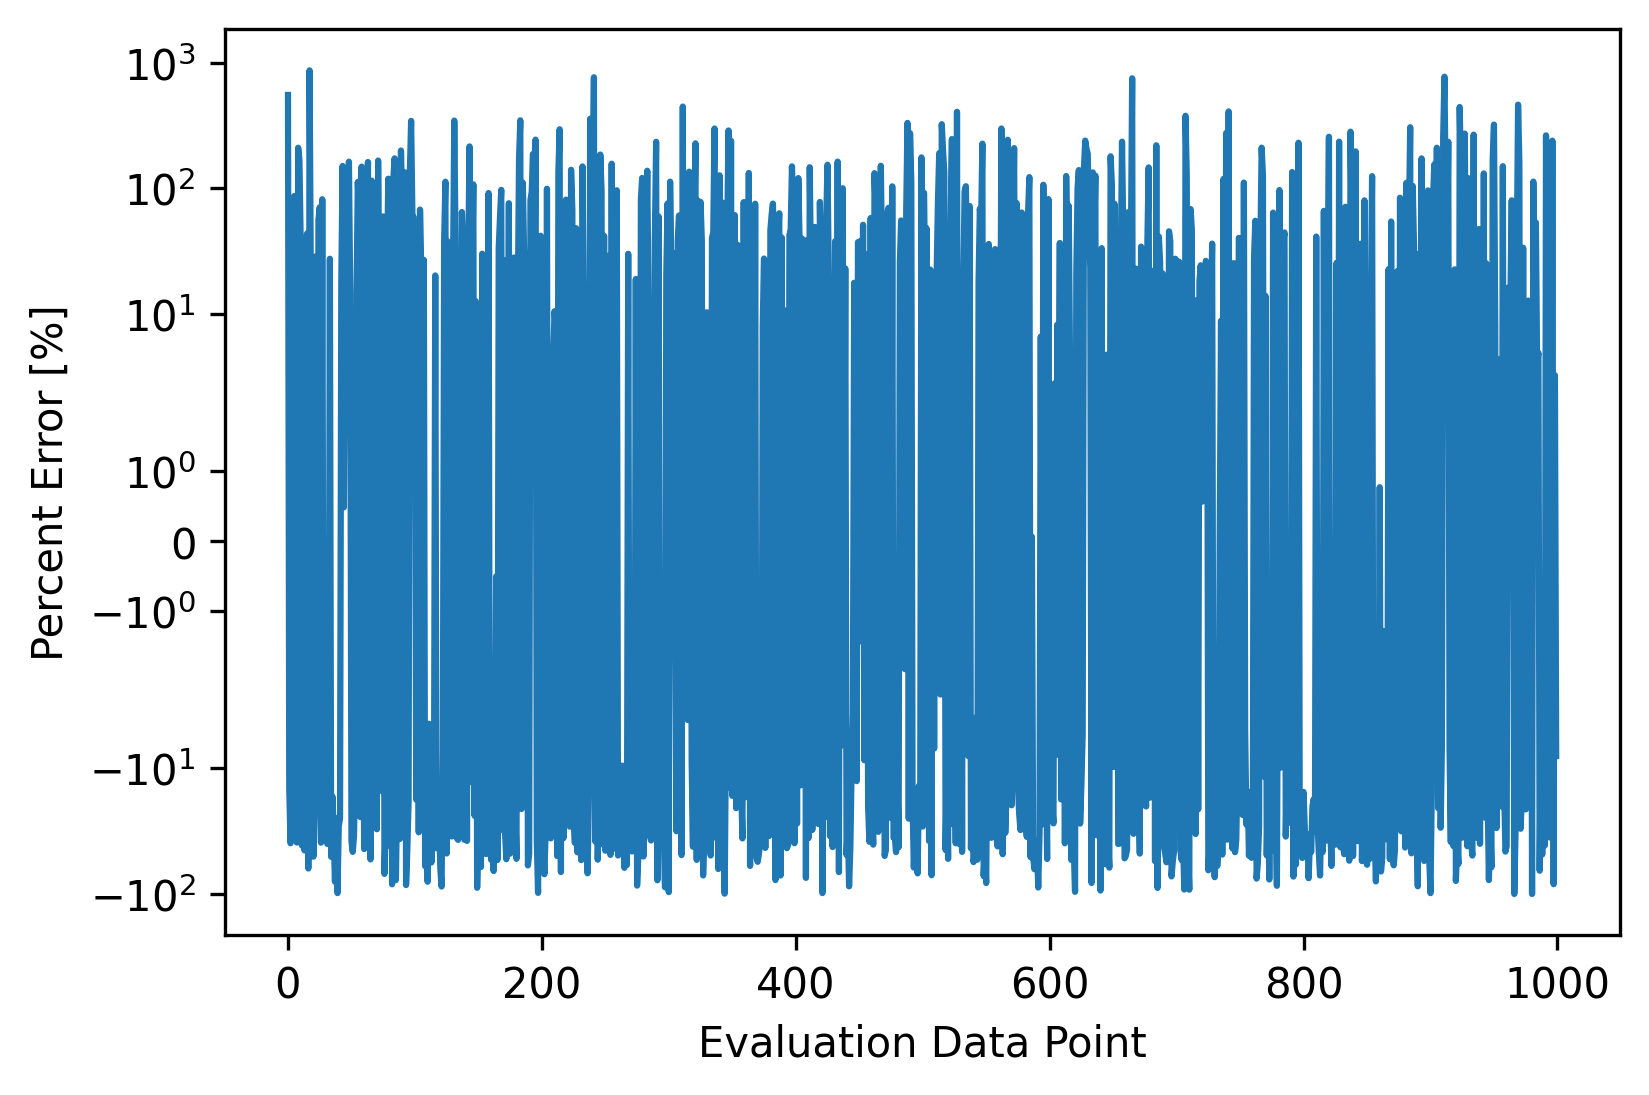

In [33]:
# in_width_eval[1]
# # model.predict([[te_mag], [te_angle], te_width, te_height])
# for i in range(len(in_mag_eval0)):
#     mag_temp = in_mag_eval0[i]
#     ang_temp = in_angle_eval0[i]
#     wid_temp = in_width_eval0[i]
#     hgt_temp = in_height_eval0[i]

eval0_predictions = model_gauss.predict([[in_mag_eval0], [in_angle_eval0], in_width_eval0, in_height_eval0])
# model.predict([[mag_temp], [ang_temp], wid_temp, hgt_temp])

sum_m_error0 = 0
sum_n_error0 = 0
sum_mode_error0 = 0
sum_comp_error0 = 0

for i in range(len(eval0_predictions[0])):
    eval_pred_m = np.argmax(eval0_predictions[0][i])
    # print(f"{eval_pred_m} - {eval_data.m[i]}")
    if eval_pred_m != (eval_data.m[i]):
        sum_m_error0 += 1

for i in range(len(eval0_predictions[1])):
    eval_pred_n = np.argmax(eval0_predictions[1][i])
    if eval_pred_n != (eval_data.n[i]):
        sum_n_error0 += 1

for i in range(len(eval0_predictions[2])):
    eval_pred_mode = np.round(eval0_predictions[2][i])
    if eval_pred_mode != eval_data['mode'][i]:
        sum_mode_error0 += 1

for i in range(len(eval0_predictions[4])):
    eval_pred_comp = np.argmax(eval0_predictions[4][i])
    # print(f"{eval_pred_comp} - {eval_data.component[i]}")
    if eval_pred_comp != eval_data.component[i]:
        sum_comp_error0 += 1

perc_error0 = np.zeros(len(eval0_predictions[3]))
for i in range(len(eval0_predictions[4])):
    eval_pred_freq = eval0_predictions[3][i]
    eval_real_freq = eval_data.freq[i]
    perc_error0[i] = ((eval_pred_freq-eval_real_freq)/eval_real_freq)*100

mean_perc_error0 = np.mean(perc_error0)
median_perc_error0 = np.median(perc_error0)
min_perc_error0 = np.min(perc_error0)
max_perc_error0 = np.max(perc_error0)

print(f"m error: {sum_m_error0}")
print(f"n error: {sum_n_error0}")
print(f"mode error: {sum_mode_error0}")
print(f"comp error: {sum_comp_error0}")
print(f"mean freq error: {mean_perc_error0}")
print(f"median freq error: {median_perc_error0}")
print(f"min freq error: {min_perc_error0}")
print(f"max freq error: {max_perc_error0}")

plt.plot(perc_error0)
plt.yscale('symlog')
plt.ylabel('Percent Error [%]')
plt.xlabel('Evaluation Data Point')
plt.show()

In [34]:
# in_width_eval[1]
# model.predict([[te_mag], [te_angle], te_width, te_height])
# for i in range(len(in_mag_eval1)):
#     mag_temp = in_mag_eval1[i]
#     ang_temp = in_angle_eval1[i]
#     wid_temp = in_width_eval1[i]
#     hgt_temp = in_height_eval1[i]

eval1_predictions = model_gauss.predict([[in_mag_eval1], [in_angle_eval1], in_width_eval1, in_height_eval1])
# model.predict([[mag_temp], [ang_temp], wid_temp, hgt_temp])

sum_m_error1 = 0
sum_n_error1 = 0
sum_mode_error1 = 0
sum_comp_error1 = 0

for i in range(len(eval1_predictions[0])):
    eval_pred_m = np.argmax(eval1_predictions[0][i])
    # print(f"{eval_pred_m} - {eval_data_noise_0p01.m[i]}")
    if eval_pred_m != eval_data_noise_0p01.m[i]:
        sum_m_error1 += 1

for i in range(len(eval1_predictions[1])):
    eval_pred_n = np.argmax(eval1_predictions[1][i])
    if eval_pred_n != eval_data_noise_0p01.n[i]:
        sum_n_error1 += 1

for i in range(len(eval1_predictions[2])):
    eval_pred_mode = np.round(eval1_predictions[2][i])
    if eval_pred_mode != eval_data_noise_0p01['mode'][i]:
        sum_mode_error1 += 1

for i in range(len(eval1_predictions[4])):
    eval_pred_comp = np.argmax(eval1_predictions[4][i])
    # print(f"{eval_pred_comp} - {eval_data_noise_0p01.component[i]}")
    if eval_pred_comp != eval_data_noise_0p01.component[i]:
        sum_comp_error1 += 1

perc_error1 = np.zeros(len(eval1_predictions[3]))
for i in range(len(eval1_predictions[4])):
    eval_pred_freq = eval1_predictions[3][i]
    eval_real_freq = eval_data_noise_0p01.freq[i]
    perc_error1[i] = ((eval_pred_freq-eval_real_freq)/eval_real_freq)*100

mean_perc_error1 = np.mean(perc_error1)
median_perc_error1 = np.median(perc_error1)
min_perc_error1 = np.min(perc_error1)
max_perc_error1 = np.max(perc_error1)

print(f"m error: {sum_m_error1}")
print(f"n error: {sum_n_error1}")
print(f"mode error: {sum_mode_error1}")
print(f"comp error: {sum_comp_error1}")
print(f"mean freq error: {mean_perc_error1}")
print(f"median freq error: {median_perc_error1}")
print(f"min freq error: {min_perc_error1}")
print(f"max freq error: {max_perc_error1}")

# plt.plot(perc_error1)
# plt.yscale('symlog')
# plt.ylabel('Percent Error [%]')
# plt.xlabel('Evaluation Data Point')
# plt.show()

m error: 12
n error: 9
mode error: 185
comp error: 184
mean freq error: 19.640522801902144
median freq error: -5.996564626693726
min freq error: -99.99938201904297
max freq error: 862.9177856445312


In [35]:
# in_width_eval[1]
# model.predict([[te_mag], [te_angle], te_width, te_height])
# for i in range(len(in_mag_eval2)):
#     mag_temp = in_mag_eval2[i]
#     ang_temp = in_angle_eval2[i]
#     wid_temp = in_width_eval2[i]
#     hgt_temp = in_height_eval2[i]

eval2_predictions = model_gauss.predict([[in_mag_eval2], [in_angle_eval2], in_width_eval2, in_height_eval2])
# model.predict([[mag_temp], [ang_temp], wid_temp, hgt_temp])

sum_m_error2 = 0
sum_n_error2 = 0
sum_mode_error2 = 0
sum_comp_error2 = 0

for i in range(len(eval2_predictions[0])):
    eval_pred_m = np.argmax(eval2_predictions[0][i])
    # print(f"{eval_pred_m} - {eval_data_noise_0p10.m[i]}")
    if eval_pred_m != eval_data_noise_0p10.m[i]:
        sum_m_error2 += 1

for i in range(len(eval2_predictions[1])):
    eval_pred_n = np.argmax(eval2_predictions[1][i])
    if eval_pred_n != eval_data_noise_0p10.n[i]:
        sum_n_error2 += 1

for i in range(len(eval2_predictions[2])):
    eval_pred_mode = np.round(eval2_predictions[2][i])
    if eval_pred_mode != eval_data_noise_0p10['mode'][i]:
        sum_mode_error2 += 1

for i in range(len(eval2_predictions[4])):
    eval_pred_comp = np.argmax(eval2_predictions[4][i])
    # print(f"{eval_pred_comp} - {eval_data_noise_0p10.component[i]}")
    if eval_pred_comp != eval_data_noise_0p10.component[i]:
        sum_comp_error2 += 1

perc_error2 = np.zeros(len(eval2_predictions[3]))
for i in range(len(eval2_predictions[4])):
    eval_pred_freq = eval2_predictions[3][i]
    eval_real_freq = eval_data_noise_0p10.freq[i]
    perc_error2[i] = ((eval_pred_freq-eval_real_freq)/eval_real_freq)*100

mean_perc_error2 = np.mean(perc_error2)
median_perc_error2 = np.median(perc_error2)
min_perc_error2 = np.min(perc_error2)
max_perc_error2 = np.max(perc_error2)

print(f"m error: {sum_m_error2}")
print(f"n error: {sum_n_error2}")
print(f"mode error: {sum_mode_error2}")
print(f"comp error: {sum_comp_error2}")
print(f"mean freq error: {mean_perc_error2}")
print(f"median freq error: {median_perc_error2}")
print(f"min freq error: {min_perc_error2}")
print(f"max freq error: {max_perc_error2}")

# plt.plot(perc_error2)
# plt.yscale('symlog')
# plt.ylabel('Percent Error [%]')
# plt.xlabel('Evaluation Data Point')
# plt.show()

m error: 12
n error: 9
mode error: 185
comp error: 184
mean freq error: 19.640522801902144
median freq error: -5.996564626693726
min freq error: -99.99938201904297
max freq error: 862.9177856445312


m error: 12
n error: 9
mode error: 185
comp error: 184
mean freq error: 19.779316867973655
median freq error: -5.996564626693726
min freq error: -99.99938201904297
max freq error: 865.3489990234375


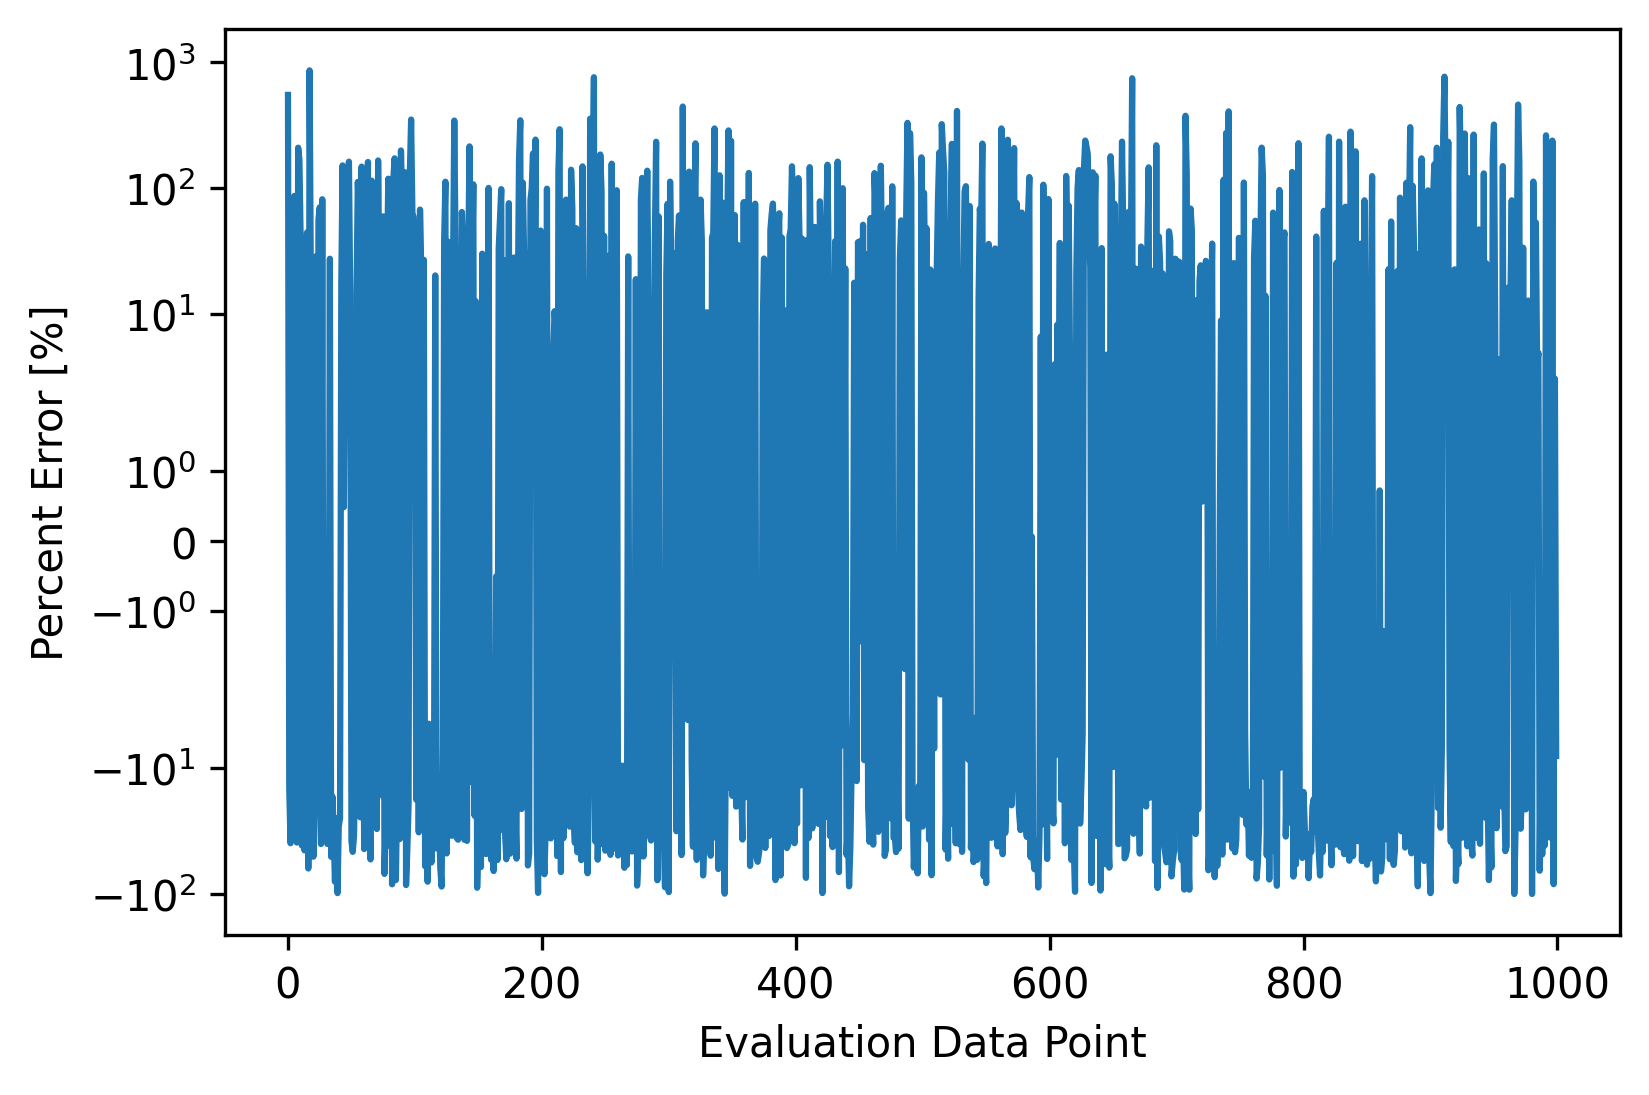

In [36]:
# in_width_eval[1]
# model.predict([[te_mag], [te_angle], te_width, te_height])
# for i in range(len(in_mag_eval3)):
#     mag_temp = in_mag_eval3[i]
#     ang_temp = in_angle_eval3[i]
#     wid_temp = in_width_eval3[i]
#     hgt_temp = in_height_eval3[i]

eval3_predictions = model_gauss.predict([[in_mag_eval3], [in_angle_eval3], in_width_eval3, in_height_eval3])
# model.predict([[mag_temp], [ang_temp], wid_temp, hgt_temp])

sum_m_error3 = 0
sum_n_error3 = 0
sum_mode_error3 = 0
sum_comp_error3 = 0

for i in range(len(eval3_predictions[0])):
    eval_pred_m = np.argmax(eval3_predictions[0][i])
    # print(f"{eval_pred_m} - {eval_data_noise_1p00.m[i]}")
    if eval_pred_m != eval_data_noise_1p00.m[i]:
        sum_m_error3 += 1

for i in range(len(eval3_predictions[1])):
    eval_pred_n = np.argmax(eval3_predictions[1][i])
    if eval_pred_n != eval_data_noise_1p00.n[i]:
        sum_n_error3 += 1

for i in range(len(eval3_predictions[2])):
    eval_pred_mode = np.round(eval3_predictions[2][i])
    if eval_pred_mode != eval_data_noise_1p00['mode'][i]:
        sum_mode_error3 += 1

for i in range(len(eval3_predictions[4])):
    eval_pred_comp = np.argmax(eval3_predictions[4][i])
    # print(f"{eval_pred_comp} - {eval_data_noise_1p00.component[i]}")
    if eval_pred_comp != eval_data_noise_1p00.component[i]:
        sum_comp_error3 += 1

perc_error3 = np.zeros(len(eval3_predictions[3]))
for i in range(len(eval3_predictions[4])):
    eval_pred_freq = eval3_predictions[3][i]
    eval_real_freq = eval_data_noise_1p00.freq[i]
    perc_error3[i] = ((eval_pred_freq-eval_real_freq)/eval_real_freq)*100

mean_perc_error3 = np.mean(perc_error3)
median_perc_error3 = np.median(perc_error3)
min_perc_error3 = np.min(perc_error3)
max_perc_error3 = np.max(perc_error3)

print(f"m error: {sum_m_error3}")
print(f"n error: {sum_n_error3}")
print(f"mode error: {sum_mode_error3}")
print(f"comp error: {sum_comp_error3}")
print(f"mean freq error: {mean_perc_error3}")
print(f"median freq error: {median_perc_error3}")
print(f"min freq error: {min_perc_error3}")
print(f"max freq error: {max_perc_error3}")

plt.plot(perc_error3)
plt.yscale('symlog')
plt.ylabel('Percent Error [%]')
plt.xlabel('Evaluation Data Point')
plt.show()

m error: 12
n error: 9
mode error: 185
comp error: 185
mean freq error: 58.260186950247736
median freq error: -1.7221980094909668
min freq error: -99.99938201904297
max freq error: 14449.4658203125


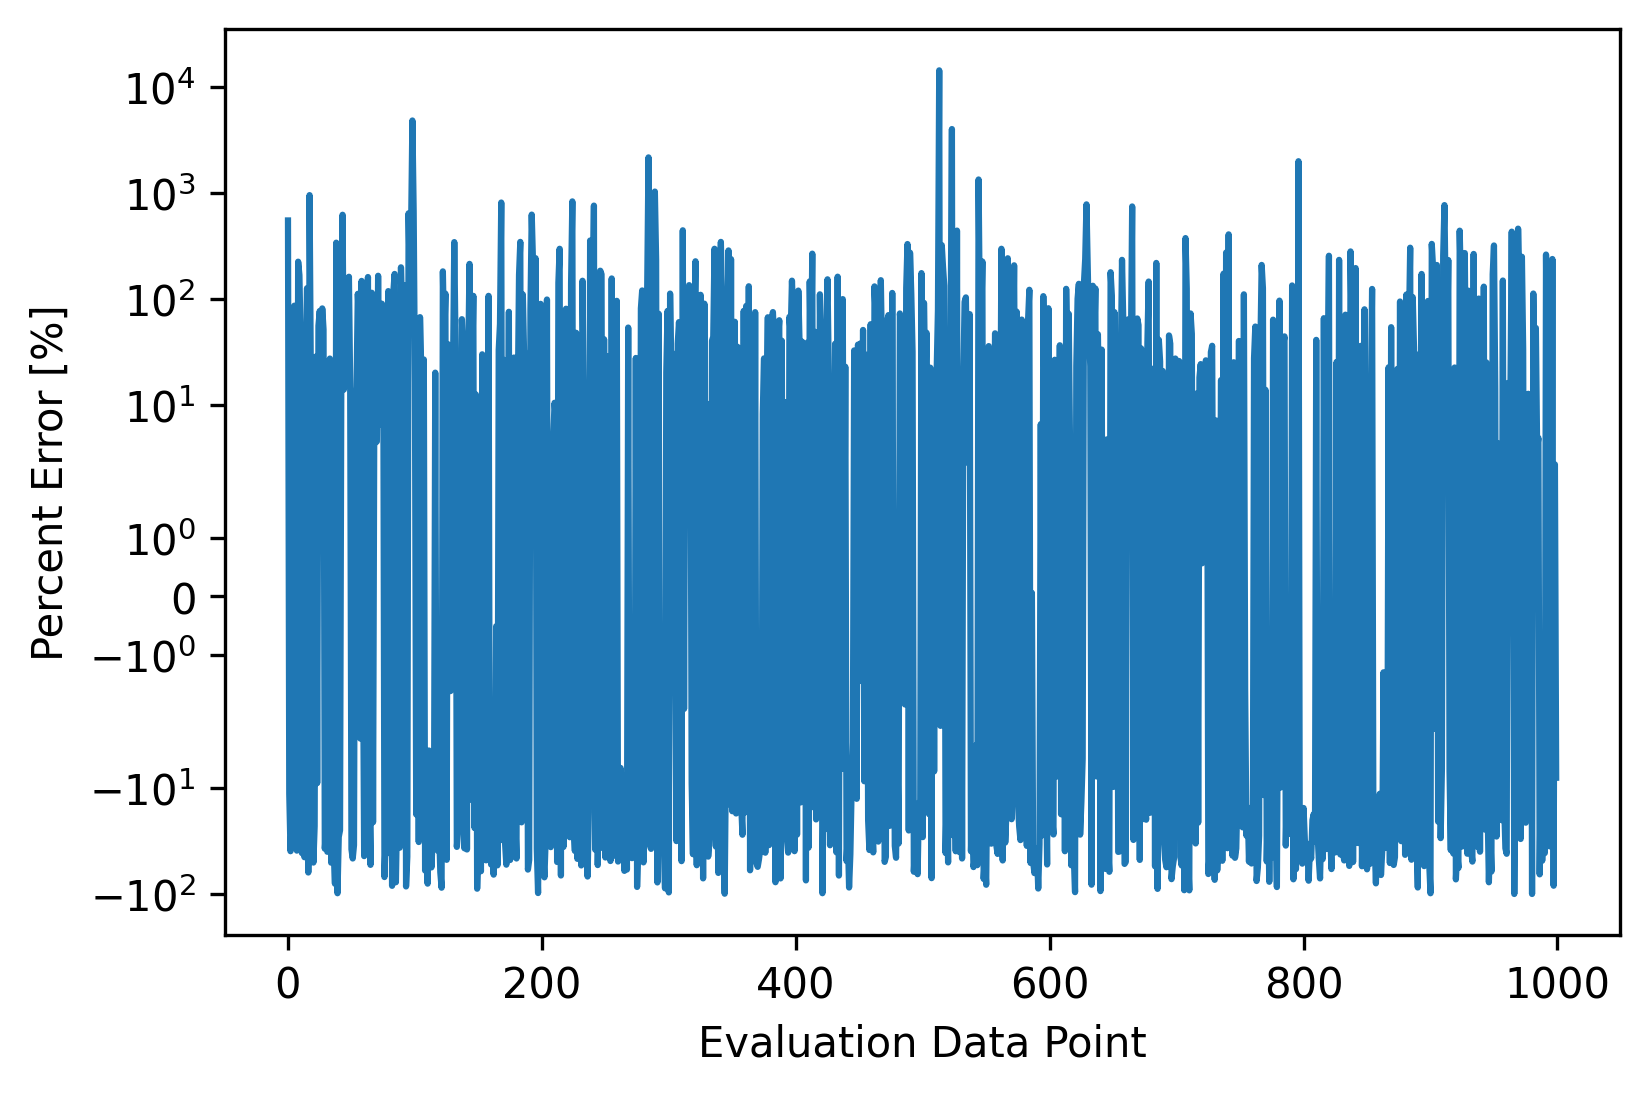

In [37]:
# in_width_eval[1]
# model.predict([[te_mag], [te_angle], te_width, te_height])
# for i in range(len(in_mag_eval4)):
#     mag_temp = in_mag_eval4[i]
#     ang_temp = in_angle_eval4[i]
#     wid_temp = in_width_eval4[i]
#     hgt_temp = in_height_eval4[i]

eval4_predictions = model_gauss.predict([[in_mag_eval4], [in_angle_eval4], in_width_eval4, in_height_eval4])
# model.predict([[mag_temp], [ang_temp], wid_temp, hgt_temp])

sum_m_error4 = 0
sum_n_error4 = 0
sum_mode_error4 = 0
sum_comp_error4 = 0

for i in range(len(eval4_predictions[0])):
    eval_pred_m = np.argmax(eval4_predictions[0][i])
    # print(f"{eval_pred_m} - {eval_data_noise_10p0.m[i]}")
    if eval_pred_m != eval_data_noise_10p0.m[i]:
        sum_m_error4 += 1

for i in range(len(eval4_predictions[1])):
    eval_pred_n = np.argmax(eval4_predictions[1][i])
    if eval_pred_n != eval_data_noise_10p0.n[i]:
        sum_n_error4 += 1

for i in range(len(eval4_predictions[2])):
    eval_pred_mode = np.round(eval4_predictions[2][i])
    if eval_pred_mode != eval_data_noise_10p0['mode'][i]:
        sum_mode_error4 += 1

for i in range(len(eval4_predictions[4])):
    eval_pred_comp = np.argmax(eval4_predictions[4][i])
    # print(f"{eval_pred_comp} - {eval_data_noise_10p0.component[i]}")
    if eval_pred_comp != eval_data_noise_10p0.component[i]:
        sum_comp_error4 += 1

perc_error4 = np.zeros(len(eval4_predictions[3]))
for i in range(len(eval4_predictions[4])):
    eval_pred_freq = eval4_predictions[3][i]
    eval_real_freq = eval_data_noise_10p0.freq[i]
    perc_error4[i] = ((eval_pred_freq-eval_real_freq)/eval_real_freq)*100

mean_perc_error4 = np.mean(perc_error4)
median_perc_error4 = np.median(perc_error4)
min_perc_error4 = np.min(perc_error4)
max_perc_error4 = np.max(perc_error4)

print(f"m error: {sum_m_error4}")
print(f"n error: {sum_n_error4}")
print(f"mode error: {sum_mode_error4}")
print(f"comp error: {sum_comp_error4}")
print(f"mean freq error: {mean_perc_error4}")
print(f"median freq error: {median_perc_error4}")
print(f"min freq error: {min_perc_error4}")
print(f"max freq error: {max_perc_error4}")

plt.plot(perc_error4)
plt.yscale('symlog')
plt.ylabel('Percent Error [%]')
plt.xlabel('Evaluation Data Point')
plt.show()

m error: 21
n error: 9
mode error: 203
comp error: 269
mean freq error: 885.102536918398
median freq error: 8.121881484985352
min freq error: -99.99938201904297
max freq error: 41062.7421875


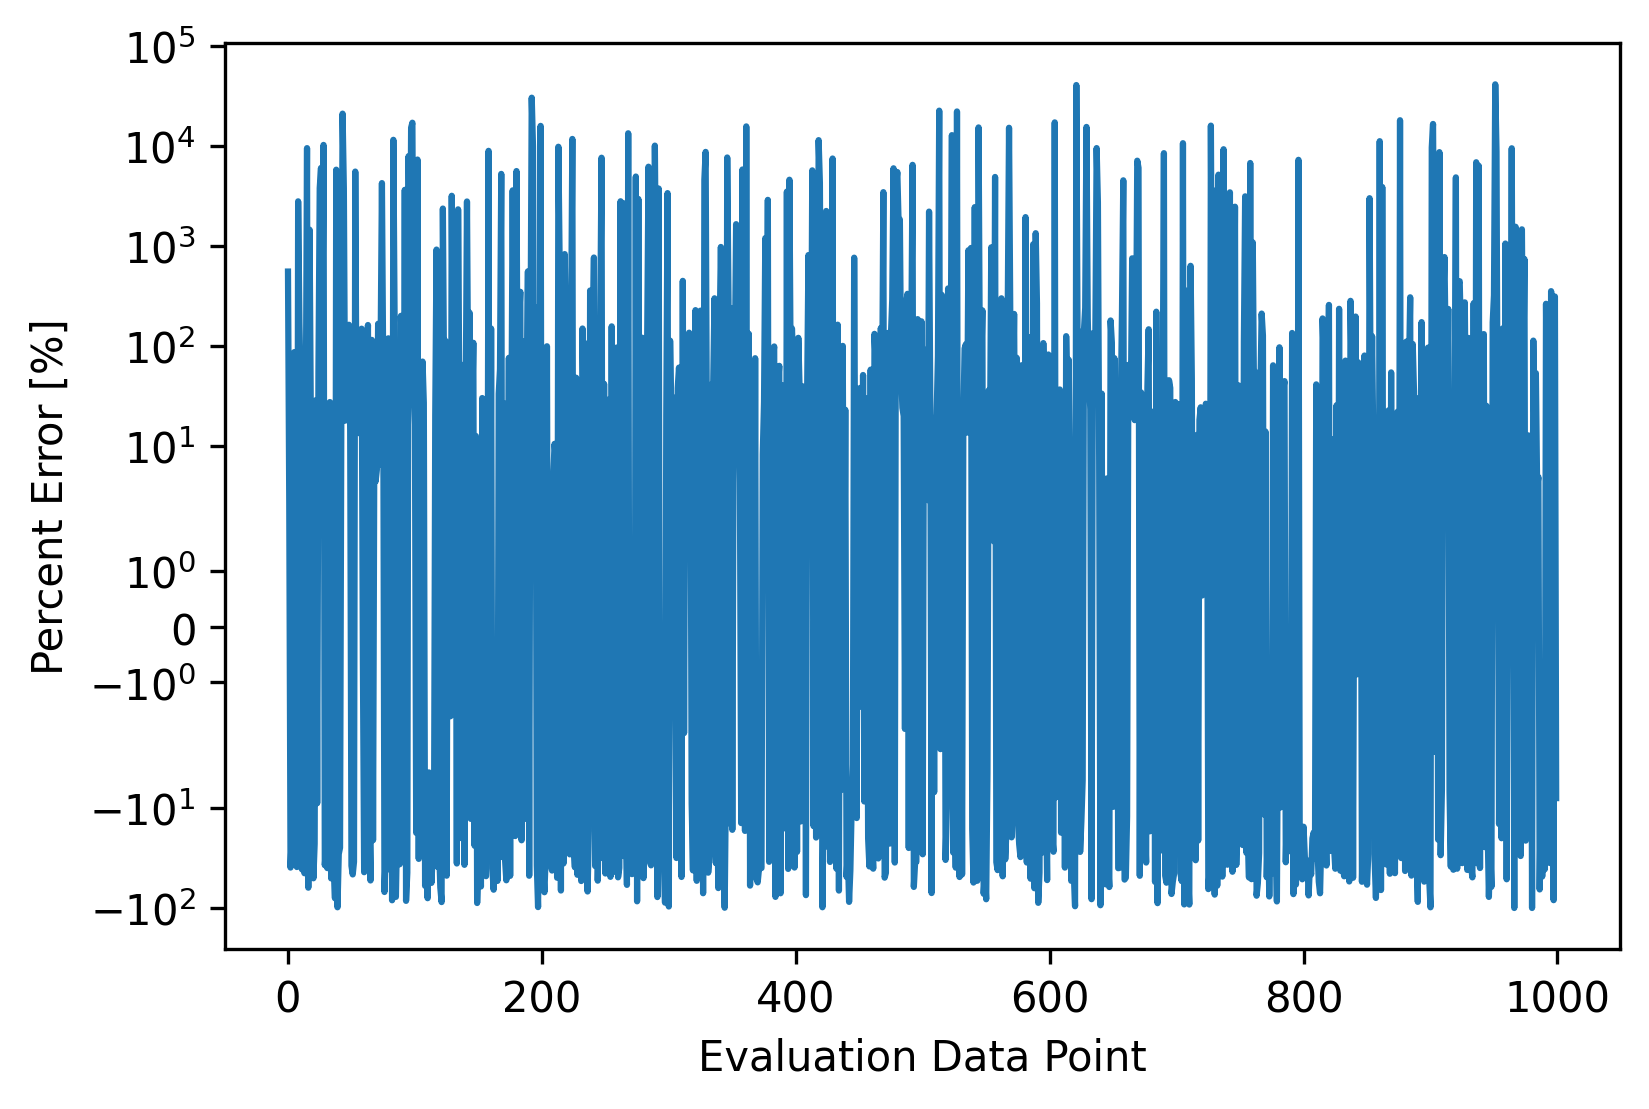

In [38]:
# in_width_eval[1]
# model.predict([[te_mag], [te_angle], te_width, te_height])
# for i in range(len(in_mag_eval5)):
#     mag_temp = in_mag_eval5[i]
#     ang_temp = in_angle_eval5[i]
#     wid_temp = in_width_eval5[i]
#     hgt_temp = in_height_eval5[i]

eval5_predictions = model_gauss.predict([[in_mag_eval5], [in_angle_eval5], in_width_eval5, in_height_eval5])
# model.predict([[mag_temp], [ang_temp], wid_temp, hgt_temp])

sum_m_error5 = 0
sum_n_error5 = 0
sum_mode_error5 = 0
sum_comp_error5 = 0

for i in range(len(eval5_predictions[0])):
    eval_pred_m = np.argmax(eval5_predictions[0][i])
    # print(f"{eval_pred_m} - {eval_data_noise_100p.m[i]}")
    if eval_pred_m != eval_data_noise_100p.m[i]:
        sum_m_error5 += 1

for i in range(len(eval5_predictions[1])):
    eval_pred_n = np.argmax(eval5_predictions[1][i])
    if eval_pred_n != eval_data_noise_100p.n[i]:
        sum_n_error5 += 1

for i in range(len(eval5_predictions[2])):
    eval_pred_mode = np.round(eval5_predictions[2][i])
    if eval_pred_mode != eval_data_noise_100p['mode'][i]:
        sum_mode_error5 += 1

for i in range(len(eval5_predictions[4])):
    eval_pred_comp = np.argmax(eval5_predictions[4][i])
    # print(f"{eval_pred_comp} - {eval_data_noise_100p.component[i]}")
    if eval_pred_comp != eval_data_noise_100p.component[i]:
        sum_comp_error5 += 1

perc_error5 = np.zeros(len(eval5_predictions[3]))
for i in range(len(eval5_predictions[4])):
    eval_pred_freq = eval5_predictions[3][i]
    eval_real_freq = eval_data_noise_100p.freq[i]
    perc_error5[i] = ((eval_pred_freq-eval_real_freq)/eval_real_freq)*100

mean_perc_error5 = np.mean(perc_error5)
median_perc_error5 = np.median(perc_error5)
min_perc_error5 = np.min(perc_error5)
max_perc_error5 = np.max(perc_error5)

print(f"m error: {sum_m_error5}")
print(f"n error: {sum_n_error5}")
print(f"mode error: {sum_mode_error5}")
print(f"comp error: {sum_comp_error5}")
print(f"mean freq error: {mean_perc_error5}")
print(f"median freq error: {median_perc_error5}")
print(f"min freq error: {min_perc_error5}")
print(f"max freq error: {max_perc_error5}")

plt.plot(perc_error5)
plt.yscale('symlog')
plt.ylabel('Percent Error [%]')
plt.xlabel('Evaluation Data Point')
plt.show()

Text(0, 0.5, 'Error Count')

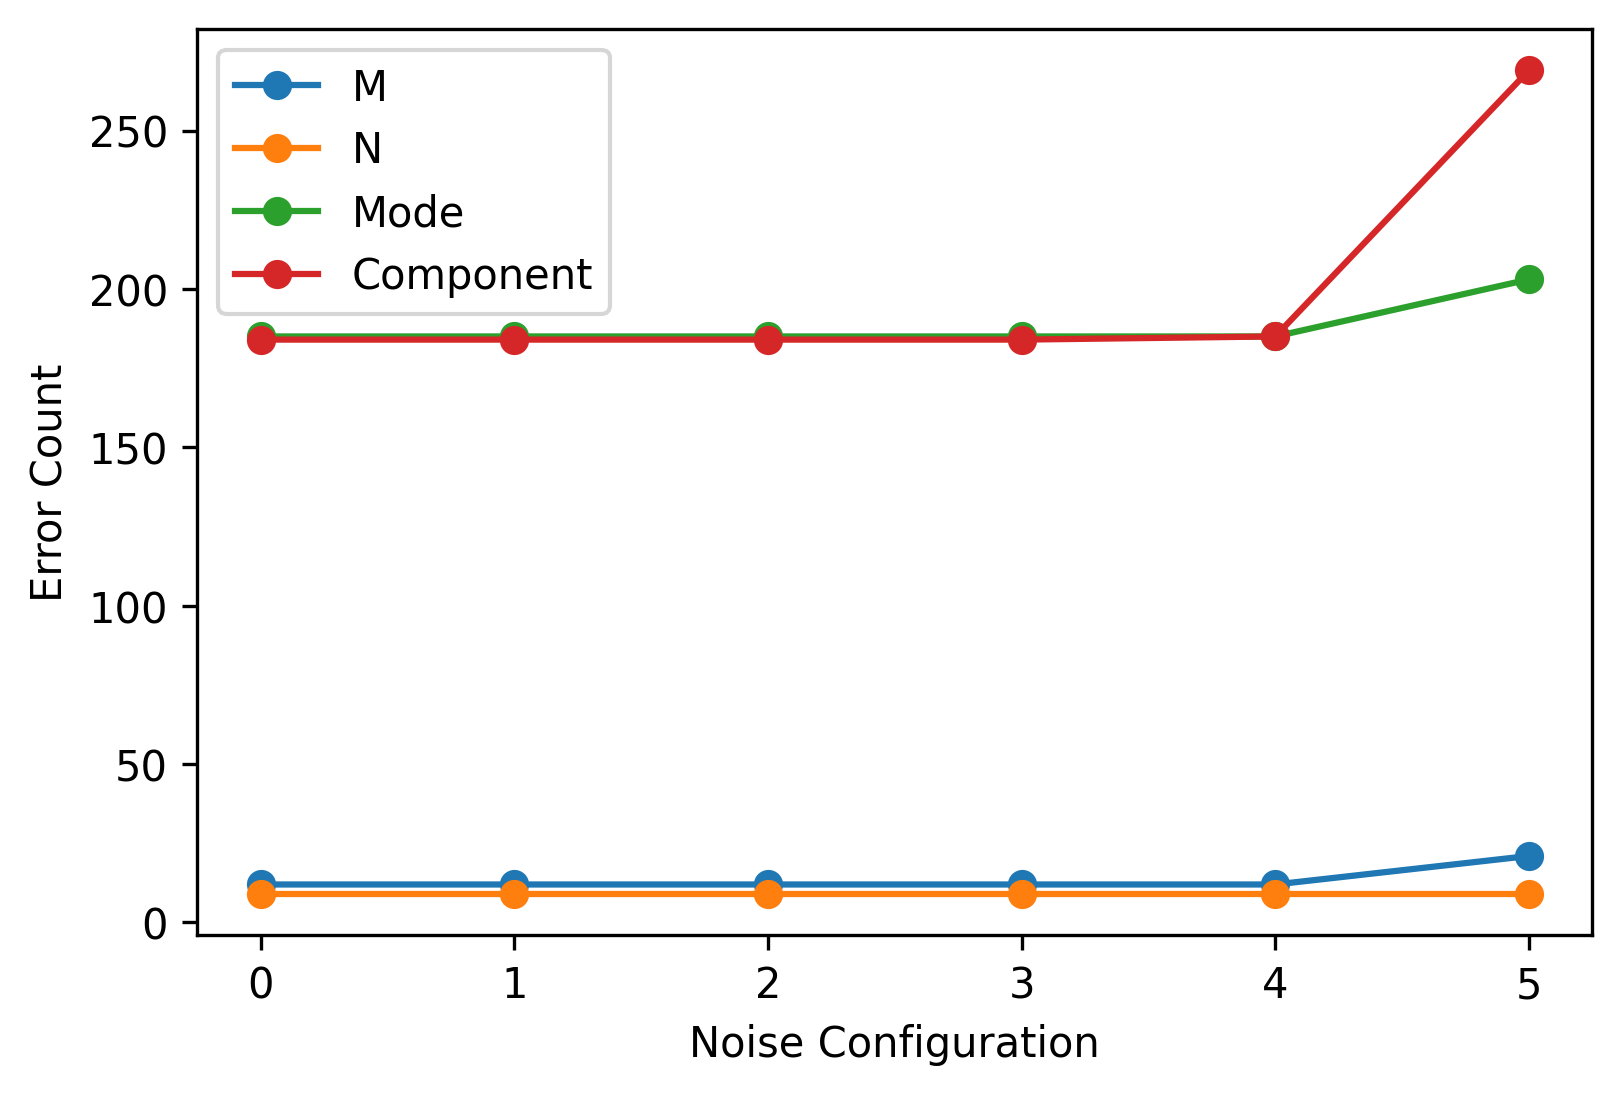

In [39]:
# Plot comparisons
x_axis_vals = [0, 1, 2, 3, 4, 5]
m_err_tot = [sum_m_error0, sum_m_error1,sum_m_error2,sum_m_error3,sum_m_error4,sum_m_error5]
n_err_tot = [sum_n_error0, sum_n_error1,sum_n_error2,sum_n_error3,sum_n_error4,sum_n_error5]
mode_err_tot = [sum_mode_error0, sum_mode_error1,sum_mode_error2,sum_mode_error3,sum_mode_error4,sum_mode_error5]
comp_err_tot = [sum_comp_error0, sum_comp_error1,sum_comp_error2,sum_comp_error3,sum_comp_error4,sum_comp_error5]

plt.plot(x_axis_vals, m_err_tot, marker="o")
plt.plot(x_axis_vals, n_err_tot, marker="o")
plt.plot(x_axis_vals, mode_err_tot, marker="o")
plt.plot(x_axis_vals, comp_err_tot, marker="o")
plt.legend(['M', 'N', 'Mode', 'Component'])
plt.xlabel("Noise Configuration")
plt.ylabel("Error Count")

In [44]:
# Decision Trees
clf_m = joblib.load("dt_model_gauss_m.pkl")
clf_n = joblib.load("dt_model_gauss_n.pkl")
clf_mode = joblib.load("dt_model_gauss_mode.pkl")
clf_comp = joblib.load("dt_model_gauss_comp.pkl")
reg_freq = joblib.load("dt_model_gauss_freq.pkl")


# Prep the eval data
in_mag_eval0_flat = np.reshape(in_mag_eval0,(len(in_mag_eval0),-1))
in_angle_eval0_flat = np.reshape(in_angle_eval0,(len(in_angle_eval0),-1))
in_mag_angle_eval0 = np.concatenate((in_mag_eval0_flat, in_angle_eval0_flat), axis=1)
in_dims_eval0 = np.vstack((in_width_eval0, in_height_eval0)).transpose()
in_svm_all_eval0 = np.concatenate((in_mag_angle_eval0, in_dims_eval0), axis=1)

in_mag_eval1_flat = np.reshape(in_mag_eval1,(len(in_mag_eval1),-1))
in_angle_eval1_flat = np.reshape(in_angle_eval1,(len(in_angle_eval1),-1))
in_mag_angle_eval1 = np.concatenate((in_mag_eval1_flat, in_angle_eval1_flat), axis=1)
in_dims_eval1 = np.vstack((in_width_eval1, in_height_eval1)).transpose()
in_svm_all_eval1 = np.concatenate((in_mag_angle_eval1, in_dims_eval1), axis=1)

in_mag_eval2_flat = np.reshape(in_mag_eval2,(len(in_mag_eval2),-1))
in_angle_eval2_flat = np.reshape(in_angle_eval2,(len(in_angle_eval2),-1))
in_mag_angle_eval2 = np.concatenate((in_mag_eval2_flat, in_angle_eval2_flat), axis=1)
in_dims_eval2 = np.vstack((in_width_eval2, in_height_eval2)).transpose()
in_svm_all_eval2 = np.concatenate((in_mag_angle_eval2, in_dims_eval2), axis=1)

in_mag_eval3_flat = np.reshape(in_mag_eval3,(len(in_mag_eval3),-1))
in_angle_eval3_flat = np.reshape(in_angle_eval3,(len(in_angle_eval3),-1))
in_mag_angle_eval3 = np.concatenate((in_mag_eval3_flat, in_angle_eval3_flat), axis=1)
in_dims_eval3 = np.vstack((in_width_eval3, in_height_eval3)).transpose()
in_svm_all_eval3 = np.concatenate((in_mag_angle_eval3, in_dims_eval3), axis=1)

in_mag_eval4_flat = np.reshape(in_mag_eval4,(len(in_mag_eval4),-1))
in_angle_eval4_flat = np.reshape(in_angle_eval4,(len(in_angle_eval4),-1))
in_mag_angle_eval4 = np.concatenate((in_mag_eval4_flat, in_angle_eval4_flat), axis=1)
in_dims_eval4 = np.vstack((in_width_eval4, in_height_eval4)).transpose()
in_svm_all_eval4 = np.concatenate((in_mag_angle_eval4, in_dims_eval4), axis=1)

in_mag_eval5_flat = np.reshape(in_mag_eval5,(len(in_mag_eval5),-1))
in_angle_eval5_flat = np.reshape(in_angle_eval5,(len(in_angle_eval5),-1))
in_mag_angle_eval5 = np.concatenate((in_mag_eval5_flat, in_angle_eval5_flat), axis=1)
in_dims_eval5 = np.vstack((in_width_eval5, in_height_eval5)).transpose()
in_svm_all_eval5 = np.concatenate((in_mag_angle_eval5, in_dims_eval5), axis=1)

m error: 40
n error: 40
mode error: 85
comp error: 16
mean freq error: 16.270263131383064
median freq error: -5.86123706003587
min freq error: -91.39224390003454
max freq error: 2231.465768429018


Text(0, 0.5, 'Count of Occurances')

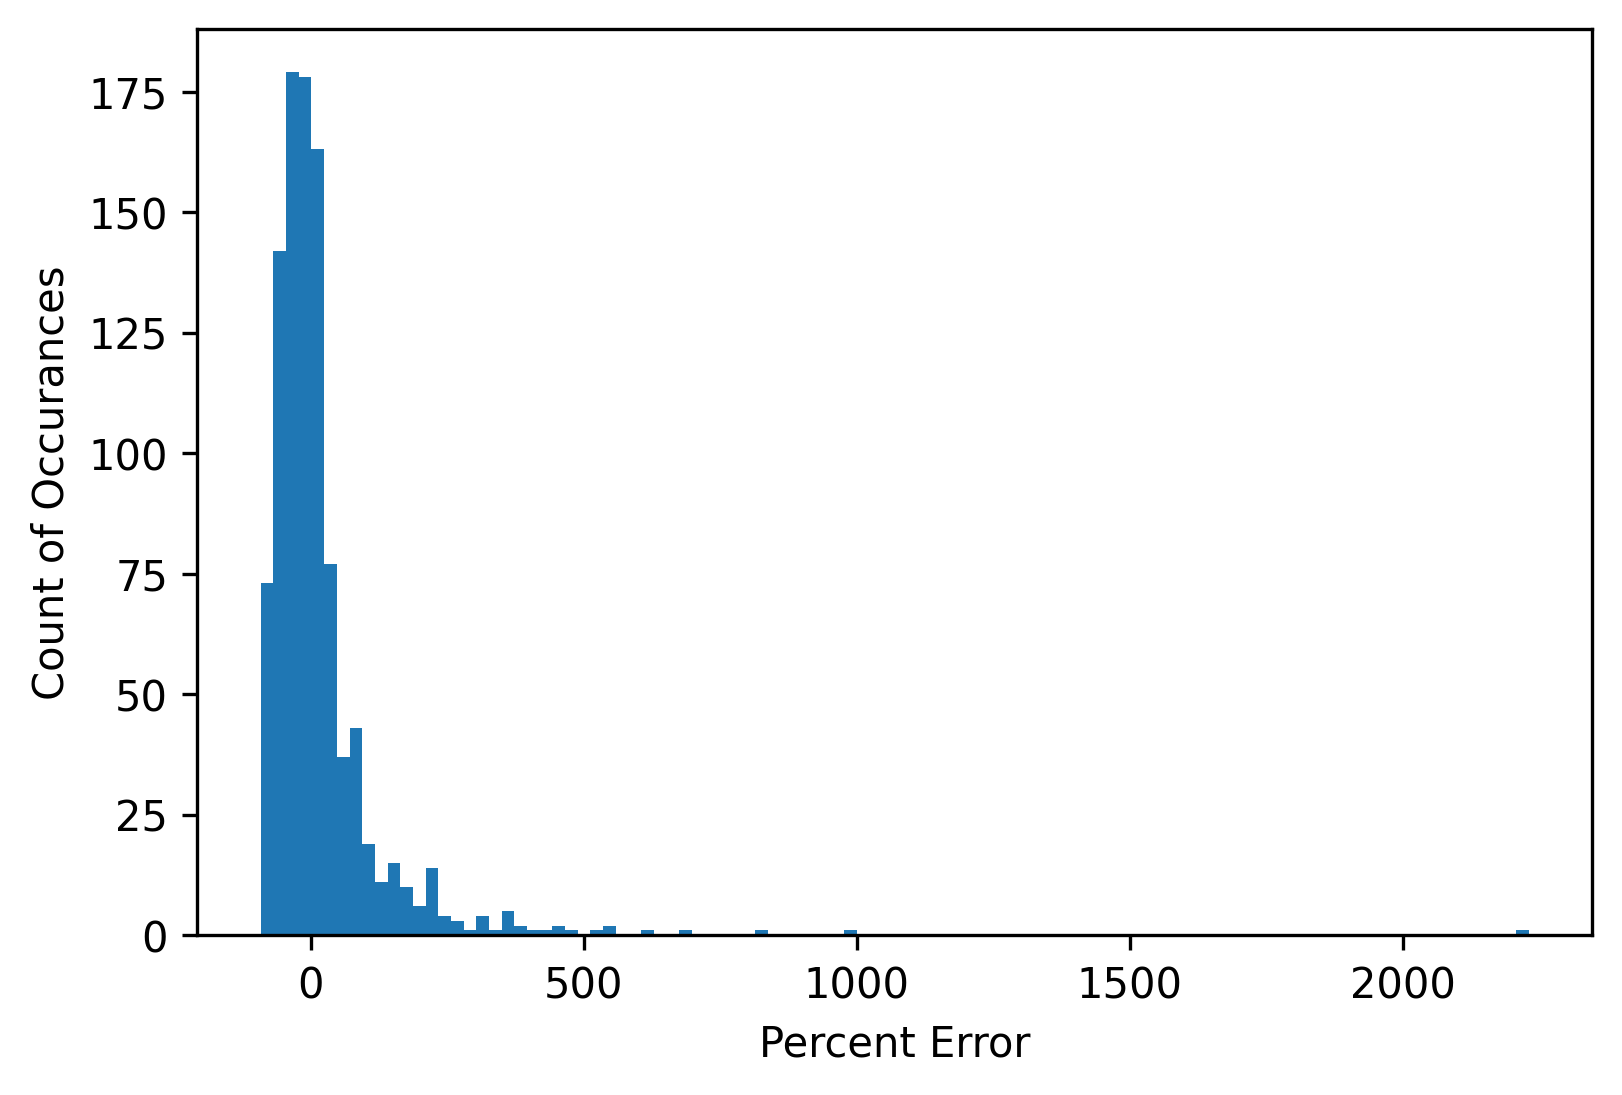

In [45]:
# Check the noiseless eval0 data set
m_error0 = 0
for i in range(len(out_m_eval0)):
    predicted_m_eval0 = np.array(clf_m.predict([in_svm_all_eval0[i]])).item()
    real_m_eval0 = np.array(out_m_eval0[i])
    # print(f"Predict: {predicted_m0} and Real: {real_m0}")
    if predicted_m_eval0 != real_m_eval0:
        m_error0 += 1

# print(f"m error: {m_error0}")

n_error0 = 0
for i in range(len(out_n_eval0)):
    predicted_n_eval0 = np.array(clf_n.predict([in_svm_all_eval0[i]])).item()
    real_n_eval0 = np.array(out_n_eval0[i])
    # print(f"Predict: {predicted_m0} and Real: {real_m0}")
    if predicted_n_eval0 != real_n_eval0:
        n_error0 += 1

# print(f"n error: {n_error0}")

mode_error0 = 0
for i in range(len(out_mode_eval0)):
    predicted_mode_eval0 = np.array(clf_mode.predict([in_svm_all_eval0[i]])).item()
    real_mode_eval0 = np.array(out_mode_eval0[i])
    # print(f"Predict: {predicted_m0} and Real: {real_m0}")
    if predicted_mode_eval0 != real_mode_eval0:
        mode_error0 += 1

# print(f"mode error: {mode_error0}")

comp_error0 = 0
for i in range(len(out_component_eval0)):
    predicted_comp_eval0 = np.array(clf_comp.predict([in_svm_all_eval0[i]])).item()
    real_comp_eval0 = np.array(out_component_eval0[i])
    # print(f"Predict: {predicted_comp_eval0} and Real: {real_comp_eval0}")
    if predicted_comp_eval0 != real_comp_eval0:
        comp_error0 += 1

# print(f"comp error: {comp_error0}")

perc_error0 = np.zeros(len(out_freq_eval0))
for i in range(len(out_freq_eval0)):
    predicted_freq_eval0 = np.array(reg_freq.predict([in_svm_all_eval0[i]])).item()
    real_freq_eval0 = np.array(out_freq_eval0[i])
    # print(f"Predict: {predicted_freq_eval0} and Real: {real_freq_eval0}")
    perc_error0[i] = ((predicted_freq_eval0-real_freq_eval0)/real_freq_eval0)*100


mean_perc_error0 = np.mean(perc_error0)
median_perc_error0 = np.median(perc_error0)
min_perc_error0 = np.min(perc_error0)
max_perc_error0 = np.max(perc_error0)

print(f"m error: {m_error0}")
print(f"n error: {n_error0}")
print(f"mode error: {mode_error0}")
print(f"comp error: {comp_error0}")
print(f"mean freq error: {mean_perc_error0}")
print(f"median freq error: {median_perc_error0}")
print(f"min freq error: {min_perc_error0}")
print(f"max freq error: {max_perc_error0}")

plt.hist(perc_error0, bins=100)
plt.xlabel("Percent Error")
plt.ylabel("Count of Occurances")

m error: 193
n error: 88
mode error: 258
comp error: 273
mean freq error: 10.012769678690244
median freq error: -26.541946392497763
min freq error: -96.83708369123084
max freq error: 1635.4677736276678


Text(0, 0.5, 'Count of Occurances')

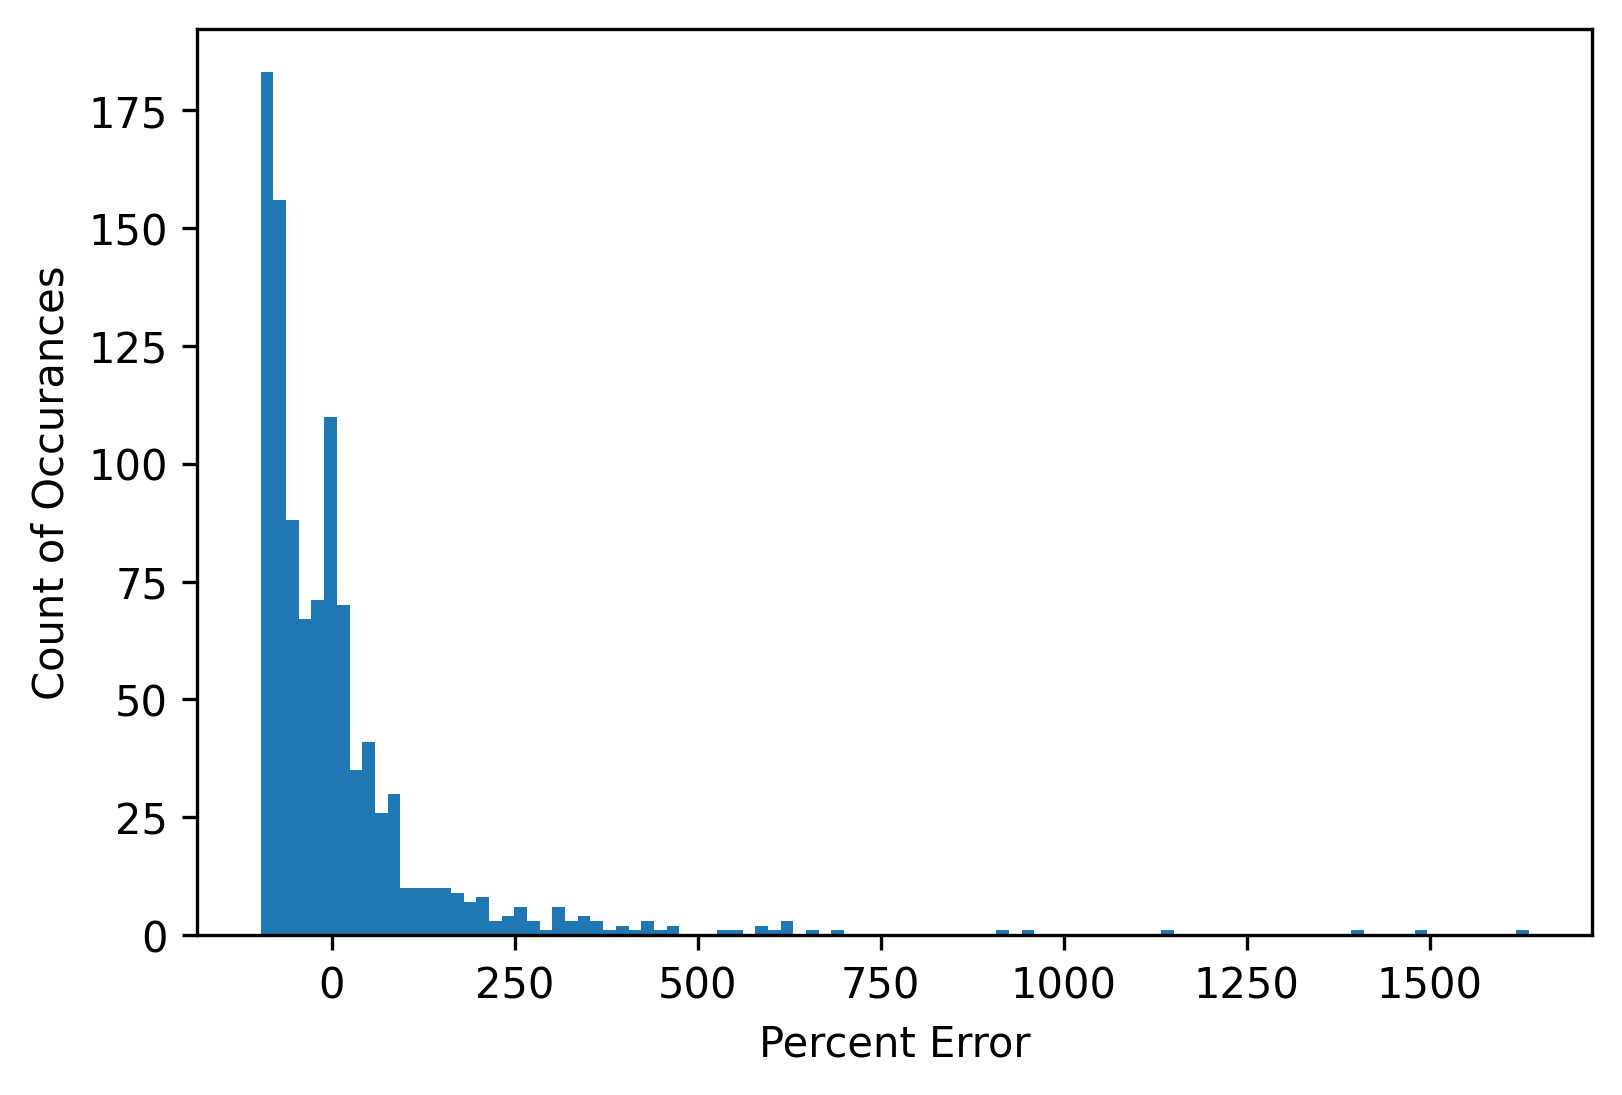

In [46]:
# Check the noiseless eval1 data set
m_error1 = 0
for i in range(len(out_m_eval1)):
    predicted_m_eval1 = np.array(clf_m.predict([in_svm_all_eval1[i]])).item()
    real_m_eval1 = np.array(out_m_eval1[i])
    # print(f"Predict: {predicted_m0} and Real: {real_m0}")
    if predicted_m_eval1 != real_m_eval1:
        m_error1 += 1

# print(f"m error: {m_error1}")

n_error1 = 0
for i in range(len(out_n_eval1)):
    predicted_n_eval1 = np.array(clf_n.predict([in_svm_all_eval1[i]])).item()
    real_n_eval1 = np.array(out_n_eval1[i])
    # print(f"Predict: {predicted_m0} and Real: {real_m0}")
    if predicted_n_eval1 != real_n_eval1:
        n_error1 += 1

# print(f"n error: {n_error1}")

mode_error1 = 0
for i in range(len(out_mode_eval1)):
    predicted_mode_eval1 = np.array(clf_mode.predict([in_svm_all_eval1[i]])).item()
    real_mode_eval1 = np.array(out_mode_eval1[i])
    # print(f"Predict: {predicted_m0} and Real: {real_m0}")
    if predicted_mode_eval1 != real_mode_eval1:
        mode_error1 += 1

# print(f"mode error: {mode_error1}")

comp_error1 = 0
for i in range(len(out_component_eval1)):
    predicted_comp_eval1 = np.array(clf_comp.predict([in_svm_all_eval1[i]])).item()
    real_comp_eval1 = np.array(out_component_eval1[i])
    # print(f"Predict: {predicted_comp_eval1} and Real: {real_comp_eval1}")
    if predicted_comp_eval1 != real_comp_eval1:
        comp_error1 += 1

# print(f"comp error: {comp_error1}")

perc_error1 = np.zeros(len(out_freq_eval1))
for i in range(len(out_freq_eval1)):
    predicted_freq_eval1 = np.array(reg_freq.predict([in_svm_all_eval1[i]])).item()
    real_freq_eval1 = np.array(out_freq_eval1[i])
    # print(f"Predict: {predicted_freq_eval1} and Real: {real_freq_eval1}")
    perc_error1[i] = ((predicted_freq_eval1-real_freq_eval1)/real_freq_eval1)*100


mean_perc_error1 = np.mean(perc_error1)
median_perc_error1 = np.median(perc_error1)
min_perc_error1 = np.min(perc_error1)
max_perc_error1 = np.max(perc_error1)

print(f"m error: {m_error1}")
print(f"n error: {n_error1}")
print(f"mode error: {mode_error1}")
print(f"comp error: {comp_error1}")
print(f"mean freq error: {mean_perc_error1}")
print(f"median freq error: {median_perc_error1}")
print(f"min freq error: {min_perc_error1}")
print(f"max freq error: {max_perc_error1}")

plt.hist(perc_error1, bins=100)
plt.xlabel("Percent Error")
plt.ylabel("Count of Occurances")

m error: 108
n error: 69
mode error: 191
comp error: 144
mean freq error: 5.868140318430791
median freq error: -27.61832717329258
min freq error: -97.3593692918304
max freq error: 2304.727710940315


Text(0, 0.5, 'Count of Occurances')

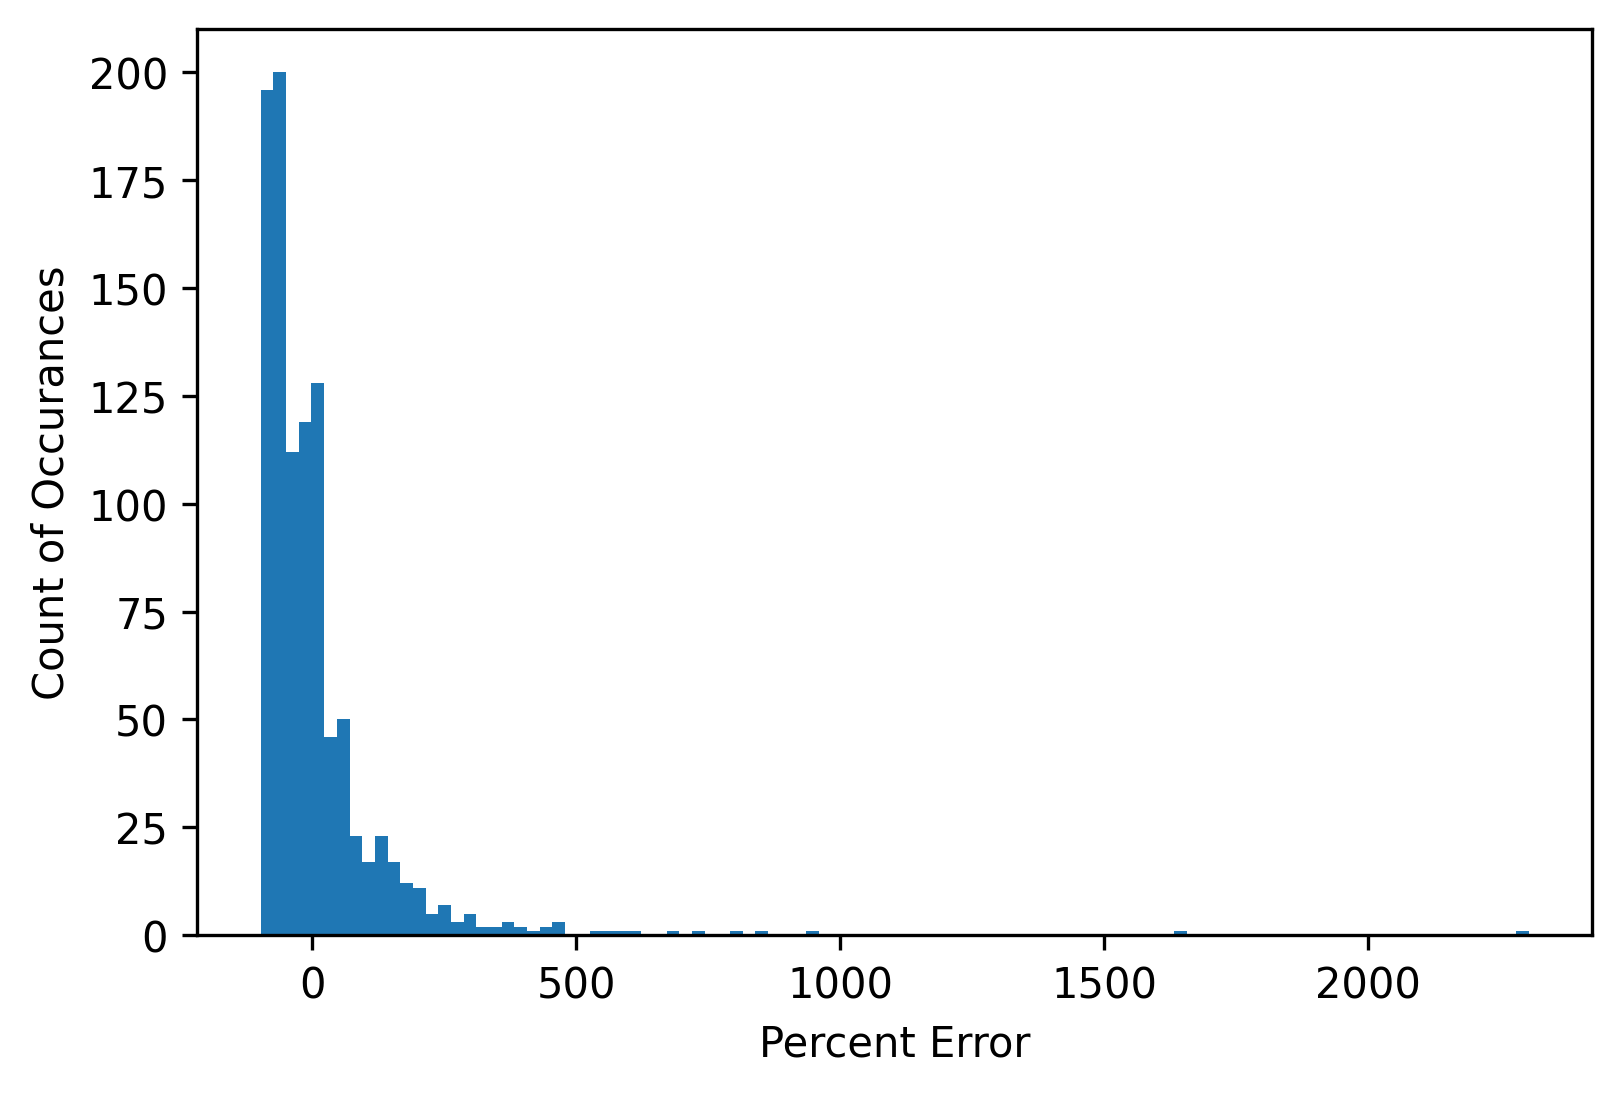

In [47]:
# Check the noiseless eval2 data set
m_error2 = 0
for i in range(len(out_m_eval2)):
    predicted_m_eval2 = np.array(clf_m.predict([in_svm_all_eval2[i]])).item()
    real_m_eval2 = np.array(out_m_eval2[i])
    # print(f"Predict: {predicted_m0} and Real: {real_m0}")
    if predicted_m_eval2 != real_m_eval2:
        m_error2 += 1

# print(f"m error: {m_error2}")

n_error2 = 0
for i in range(len(out_n_eval2)):
    predicted_n_eval2 = np.array(clf_n.predict([in_svm_all_eval2[i]])).item()
    real_n_eval2 = np.array(out_n_eval2[i])
    # print(f"Predict: {predicted_m0} and Real: {real_m0}")
    if predicted_n_eval2 != real_n_eval2:
        n_error2 += 1

# print(f"n error: {n_error2}")

mode_error2 = 0
for i in range(len(out_mode_eval2)):
    predicted_mode_eval2 = np.array(clf_mode.predict([in_svm_all_eval2[i]])).item()
    real_mode_eval2 = np.array(out_mode_eval2[i])
    # print(f"Predict: {predicted_m0} and Real: {real_m0}")
    if predicted_mode_eval2 != real_mode_eval2:
        mode_error2 += 1

# print(f"mode error: {mode_error2}")

comp_error2 = 0
for i in range(len(out_component_eval2)):
    predicted_comp_eval2 = np.array(clf_comp.predict([in_svm_all_eval2[i]])).item()
    real_comp_eval2 = np.array(out_component_eval2[i])
    # print(f"Predict: {predicted_comp_eval2} and Real: {real_comp_eval2}")
    if predicted_comp_eval2 != real_comp_eval2:
        comp_error2 += 1

# print(f"comp error: {comp_error2}")

perc_error2 = np.zeros(len(out_freq_eval2))
for i in range(len(out_freq_eval2)):
    predicted_freq_eval2 = np.array(reg_freq.predict([in_svm_all_eval2[i]])).item()
    real_freq_eval2 = np.array(out_freq_eval2[i])
    # print(f"Predict: {predicted_freq_eval2} and Real: {real_freq_eval2}")
    perc_error2[i] = ((predicted_freq_eval2-real_freq_eval2)/real_freq_eval2)*100


mean_perc_error2 = np.mean(perc_error2)
median_perc_error2 = np.median(perc_error2)
min_perc_error2 = np.min(perc_error2)
max_perc_error2 = np.max(perc_error2)

print(f"m error: {m_error2}")
print(f"n error: {n_error2}")
print(f"mode error: {mode_error2}")
print(f"comp error: {comp_error2}")
print(f"mean freq error: {mean_perc_error2}")
print(f"median freq error: {median_perc_error2}")
print(f"min freq error: {min_perc_error2}")
print(f"max freq error: {max_perc_error2}")

plt.hist(perc_error2, bins=100)
plt.xlabel("Percent Error")
plt.ylabel("Count of Occurances")

m error: 73
n error: 47
mode error: 104
comp error: 52
mean freq error: 11.678719753260195
median freq error: -11.455643431678677
min freq error: -91.19540163703468
max freq error: 2231.465768429018


Text(0, 0.5, 'Count of Occurances')

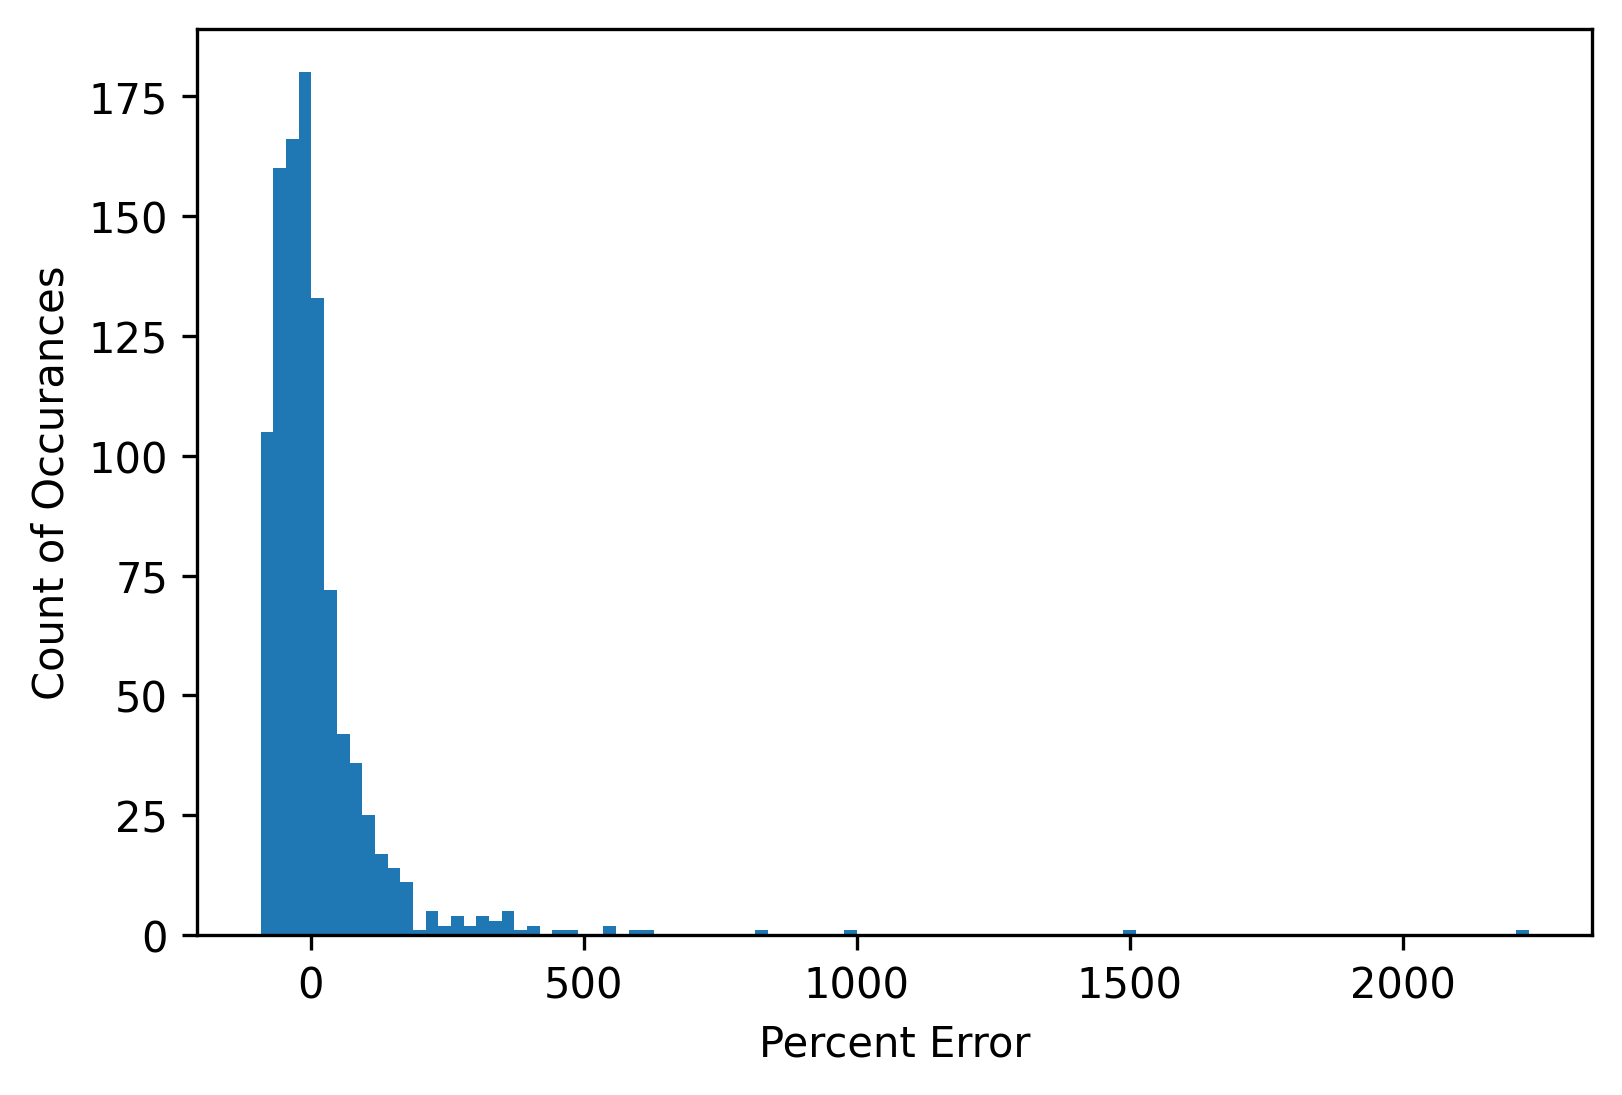

In [48]:
# Check the noiseless eval3 data set
m_error3 = 0
for i in range(len(out_m_eval3)):
    predicted_m_eval3 = np.array(clf_m.predict([in_svm_all_eval3[i]])).item()
    real_m_eval3 = np.array(out_m_eval3[i])
    # print(f"Predict: {predicted_m0} and Real: {real_m0}")
    if predicted_m_eval3 != real_m_eval3:
        m_error3 += 1

# print(f"m error: {m_error3}")

n_error3 = 0
for i in range(len(out_n_eval3)):
    predicted_n_eval3 = np.array(clf_n.predict([in_svm_all_eval3[i]])).item()
    real_n_eval3 = np.array(out_n_eval3[i])
    # print(f"Predict: {predicted_m0} and Real: {real_m0}")
    if predicted_n_eval3 != real_n_eval3:
        n_error3 += 1

# print(f"n error: {n_error3}")

mode_error3 = 0
for i in range(len(out_mode_eval3)):
    predicted_mode_eval3 = np.array(clf_mode.predict([in_svm_all_eval3[i]])).item()
    real_mode_eval3 = np.array(out_mode_eval3[i])
    # print(f"Predict: {predicted_m0} and Real: {real_m0}")
    if predicted_mode_eval3 != real_mode_eval3:
        mode_error3 += 1

# print(f"mode error: {mode_error3}")

comp_error3 = 0
for i in range(len(out_component_eval3)):
    predicted_comp_eval3 = np.array(clf_comp.predict([in_svm_all_eval3[i]])).item()
    real_comp_eval3 = np.array(out_component_eval3[i])
    # print(f"Predict: {predicted_comp_eval3} and Real: {real_comp_eval3}")
    if predicted_comp_eval3 != real_comp_eval3:
        comp_error3 += 1

# print(f"comp error: {comp_error3}")

perc_error3 = np.zeros(len(out_freq_eval3))
for i in range(len(out_freq_eval3)):
    predicted_freq_eval3 = np.array(reg_freq.predict([in_svm_all_eval3[i]])).item()
    real_freq_eval3 = np.array(out_freq_eval3[i])
    # print(f"Predict: {predicted_freq_eval3} and Real: {real_freq_eval3}")
    perc_error3[i] = ((predicted_freq_eval3-real_freq_eval3)/real_freq_eval3)*100


mean_perc_error3 = np.mean(perc_error3)
median_perc_error3 = np.median(perc_error3)
min_perc_error3 = np.min(perc_error3)
max_perc_error3 = np.max(perc_error3)

print(f"m error: {m_error3}")
print(f"n error: {n_error3}")
print(f"mode error: {mode_error3}")
print(f"comp error: {comp_error3}")
print(f"mean freq error: {mean_perc_error3}")
print(f"median freq error: {median_perc_error3}")
print(f"min freq error: {min_perc_error3}")
print(f"max freq error: {max_perc_error3}")

plt.hist(perc_error3, bins=100)
plt.xlabel("Percent Error")
plt.ylabel("Count of Occurances")

m error: 90
n error: 74
mode error: 114
comp error: 5
mean freq error: 44.82627369166465
median freq error: 9.633137940667787
min freq error: -93.37841725444174
max freq error: 1927.087489462229


Text(0, 0.5, 'Count of Occurances')

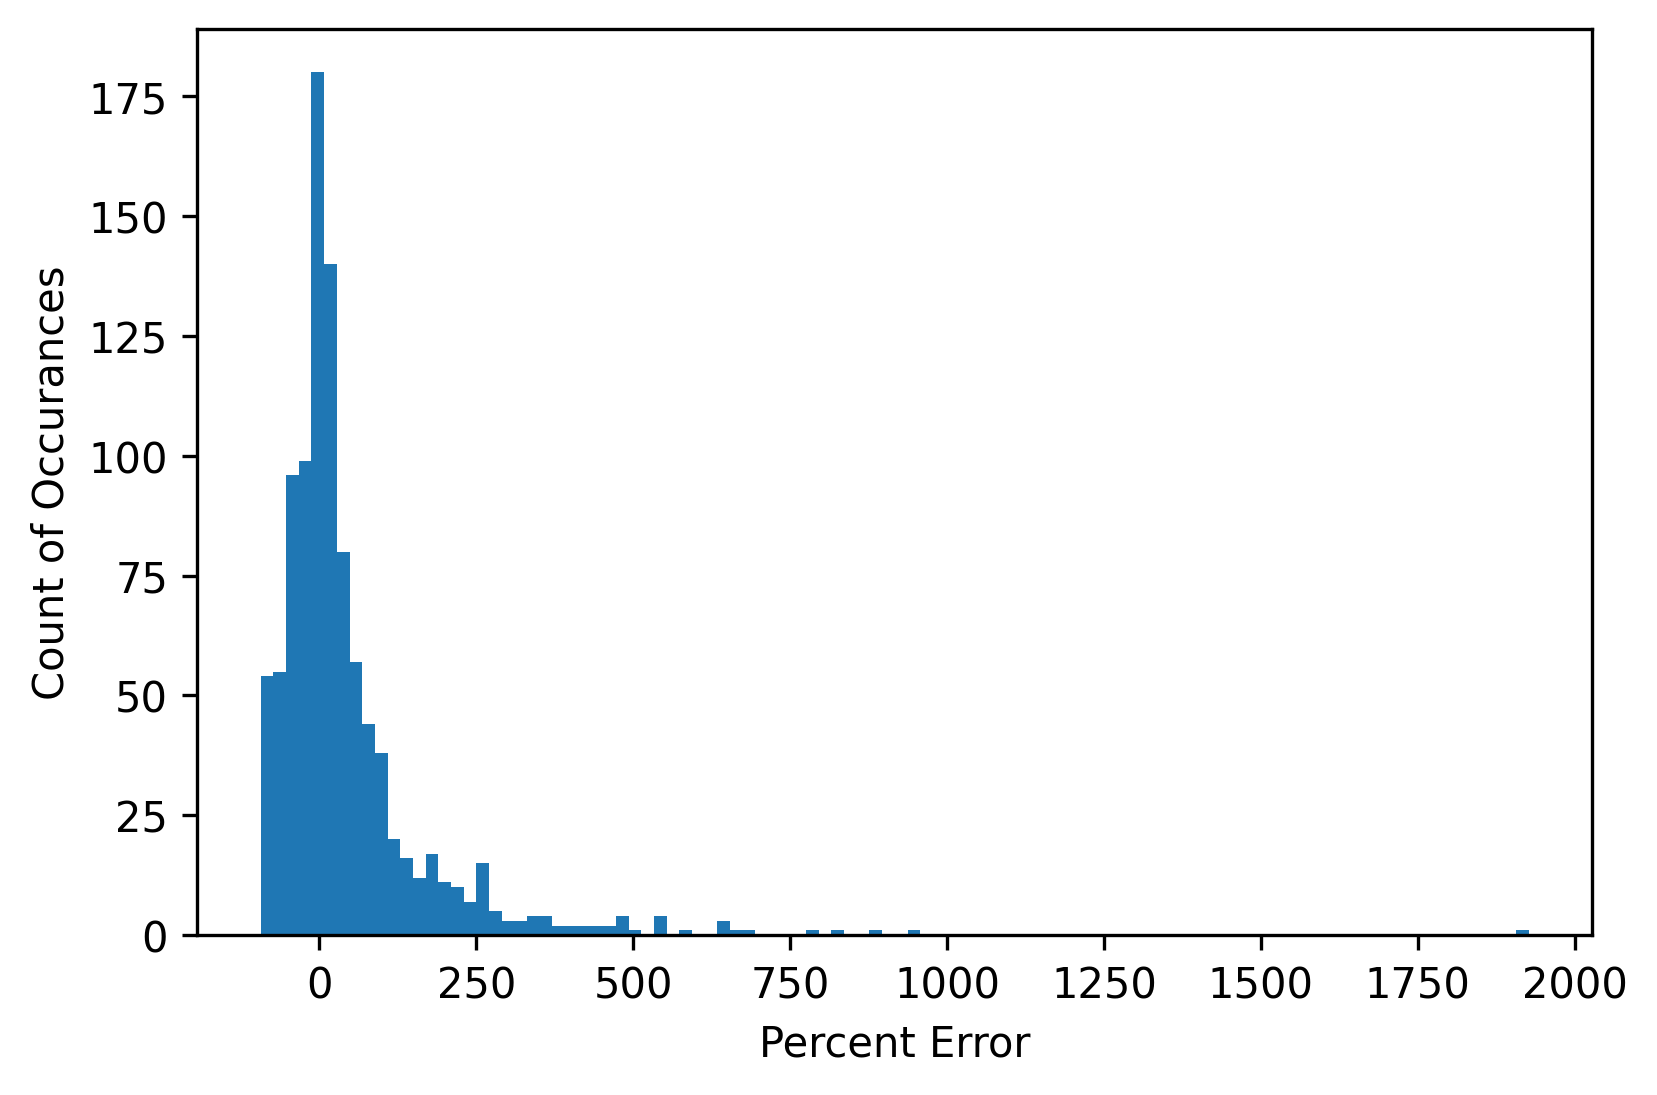

In [49]:
# Check the noiseless eval4 data set
m_error4 = 0
for i in range(len(out_m_eval4)):
    predicted_m_eval4 = np.array(clf_m.predict([in_svm_all_eval4[i]])).item()
    real_m_eval4 = np.array(out_m_eval4[i])
    # print(f"Predict: {predicted_m0} and Real: {real_m0}")
    if predicted_m_eval4 != real_m_eval4:
        m_error4 += 1

# print(f"m error: {m_error4}")

n_error4 = 0
for i in range(len(out_n_eval4)):
    predicted_n_eval4 = np.array(clf_n.predict([in_svm_all_eval4[i]])).item()
    real_n_eval4 = np.array(out_n_eval4[i])
    # print(f"Predict: {predicted_m0} and Real: {real_m0}")
    if predicted_n_eval4 != real_n_eval4:
        n_error4 += 1

# print(f"n error: {n_error4}")

mode_error4 = 0
for i in range(len(out_mode_eval4)):
    predicted_mode_eval4 = np.array(clf_mode.predict([in_svm_all_eval4[i]])).item()
    real_mode_eval4 = np.array(out_mode_eval4[i])
    # print(f"Predict: {predicted_m0} and Real: {real_m0}")
    if predicted_mode_eval4 != real_mode_eval4:
        mode_error4 += 1

# print(f"mode error: {mode_error4}")

comp_error4 = 0
for i in range(len(out_component_eval4)):
    predicted_comp_eval4 = np.array(clf_comp.predict([in_svm_all_eval4[i]])).item()
    real_comp_eval4 = np.array(out_component_eval4[i])
    # print(f"Predict: {predicted_comp_eval4} and Real: {real_comp_eval4}")
    if predicted_comp_eval4 != real_comp_eval4:
        comp_error4 += 1

# print(f"comp error: {comp_error4}")

perc_error4 = np.zeros(len(out_freq_eval4))
for i in range(len(out_freq_eval4)):
    predicted_freq_eval4 = np.array(reg_freq.predict([in_svm_all_eval4[i]])).item()
    real_freq_eval4 = np.array(out_freq_eval4[i])
    # print(f"Predict: {predicted_freq_eval4} and Real: {real_freq_eval4}")
    perc_error4[i] = ((predicted_freq_eval4-real_freq_eval4)/real_freq_eval4)*100


mean_perc_error4 = np.mean(perc_error4)
median_perc_error4 = np.median(perc_error4)
min_perc_error4 = np.min(perc_error4)
max_perc_error4 = np.max(perc_error4)

print(f"m error: {m_error4}")
print(f"n error: {n_error4}")
print(f"mode error: {mode_error4}")
print(f"comp error: {comp_error4}")
print(f"mean freq error: {mean_perc_error4}")
print(f"median freq error: {median_perc_error4}")
print(f"min freq error: {min_perc_error4}")
print(f"max freq error: {max_perc_error4}")

plt.hist(perc_error4, bins=100)
plt.xlabel("Percent Error")
plt.ylabel("Count of Occurances")

m error: 121
n error: 127
mode error: 176
comp error: 12
mean freq error: 55.42267693648126
median freq error: 16.822793327813336
min freq error: -93.05829602218
max freq error: 1279.5032862715404


Text(0, 0.5, 'Count of Occurances')

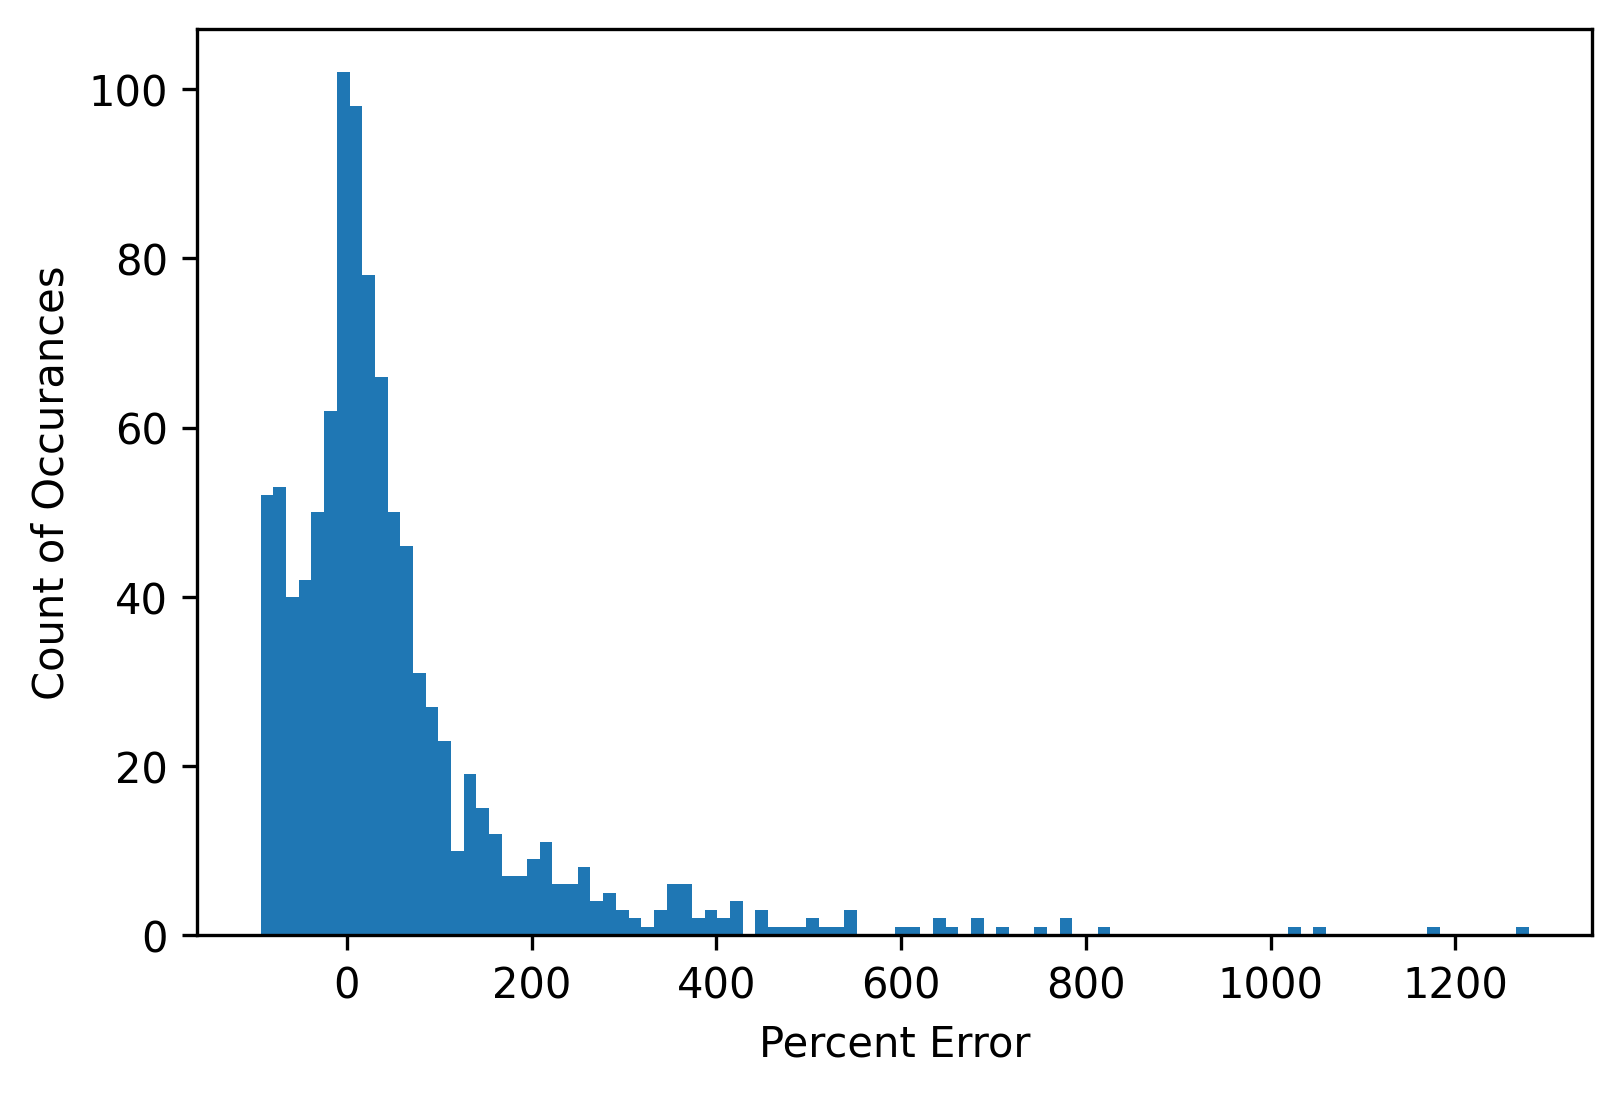

In [50]:
# Check the noiseless eval5 data set
m_error5 = 0
for i in range(len(out_m_eval5)):
    predicted_m_eval5 = np.array(clf_m.predict([in_svm_all_eval5[i]])).item()
    real_m_eval5 = np.array(out_m_eval5[i])
    # print(f"Predict: {predicted_m0} and Real: {real_m0}")
    if predicted_m_eval5 != real_m_eval5:
        m_error5 += 1

# print(f"m error: {m_error5}")

n_error5 = 0
for i in range(len(out_n_eval5)):
    predicted_n_eval5 = np.array(clf_n.predict([in_svm_all_eval5[i]])).item()
    real_n_eval5 = np.array(out_n_eval5[i])
    # print(f"Predict: {predicted_m0} and Real: {real_m0}")
    if predicted_n_eval5 != real_n_eval5:
        n_error5 += 1

# print(f"n error: {n_error5}")

mode_error5 = 0
for i in range(len(out_mode_eval5)):
    predicted_mode_eval5 = np.array(clf_mode.predict([in_svm_all_eval5[i]])).item()
    real_mode_eval5 = np.array(out_mode_eval5[i])
    # print(f"Predict: {predicted_m0} and Real: {real_m0}")
    if predicted_mode_eval5 != real_mode_eval5:
        mode_error5 += 1

# print(f"mode error: {mode_error5}")

comp_error5 = 0
for i in range(len(out_component_eval5)):
    predicted_comp_eval5 = np.array(clf_comp.predict([in_svm_all_eval5[i]])).item()
    real_comp_eval5 = np.array(out_component_eval5[i])
    # print(f"Predict: {predicted_comp_eval5} and Real: {real_comp_eval5}")
    if predicted_comp_eval5 != real_comp_eval5:
        comp_error5 += 1

# print(f"comp error: {comp_error5}")

perc_error5 = np.zeros(len(out_freq_eval5))
for i in range(len(out_freq_eval5)):
    predicted_freq_eval5 = np.array(reg_freq.predict([in_svm_all_eval5[i]])).item()
    real_freq_eval5 = np.array(out_freq_eval5[i])
    # print(f"Predict: {predicted_freq_eval5} and Real: {real_freq_eval5}")
    perc_error5[i] = ((predicted_freq_eval5-real_freq_eval5)/real_freq_eval5)*100


mean_perc_error5 = np.mean(perc_error5)
median_perc_error5 = np.median(perc_error5)
min_perc_error5 = np.min(perc_error5)
max_perc_error5 = np.max(perc_error5)

print(f"m error: {m_error5}")
print(f"n error: {n_error5}")
print(f"mode error: {mode_error5}")
print(f"comp error: {comp_error5}")
print(f"mean freq error: {mean_perc_error5}")
print(f"median freq error: {median_perc_error5}")
print(f"min freq error: {min_perc_error5}")
print(f"max freq error: {max_perc_error5}")

plt.hist(perc_error5, bins=100)
plt.xlabel("Percent Error")
plt.ylabel("Count of Occurances")

Text(0, 0.5, 'Error Count')

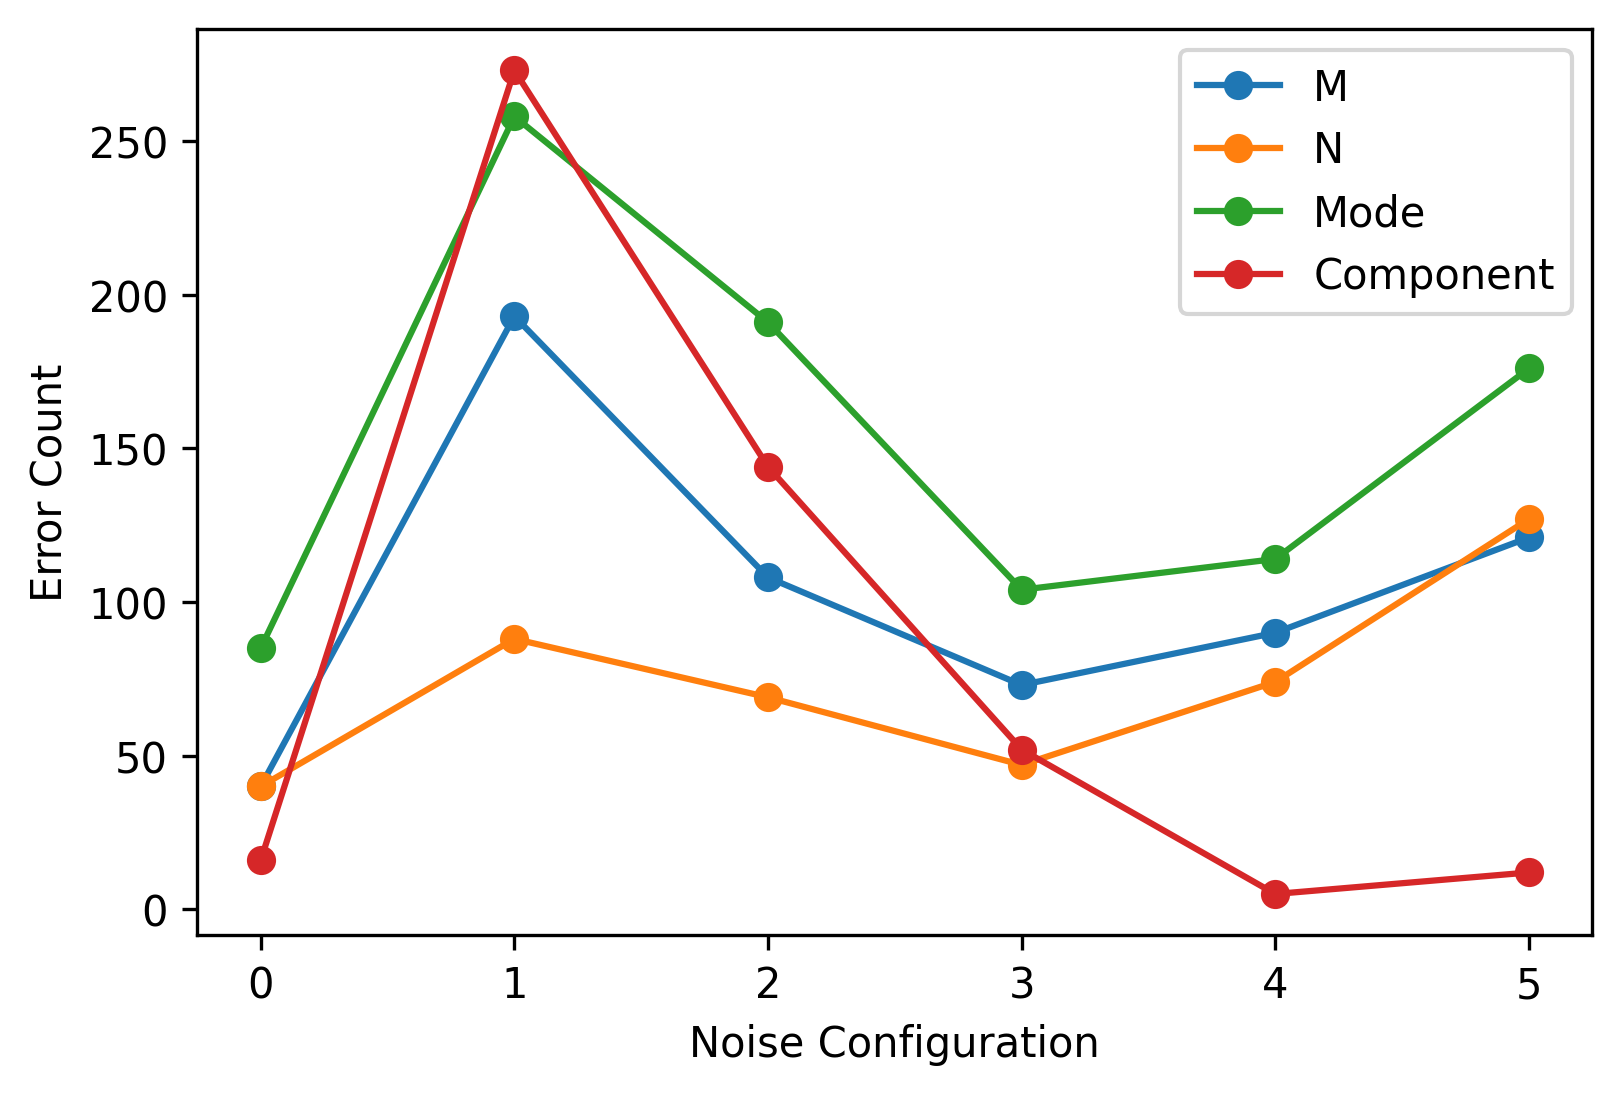

In [51]:
# Plot comparisons
x_axis_vals = [0, 1, 2, 3, 4, 5]
m_err_tot = [m_error0, m_error1,m_error2,m_error3,m_error4,m_error5]
n_err_tot = [n_error0, n_error1,n_error2,n_error3,n_error4,n_error5]
mode_err_tot = [mode_error0, mode_error1,mode_error2,mode_error3,mode_error4,mode_error5]
comp_err_tot = [comp_error0, comp_error1,comp_error2,comp_error3,comp_error4,comp_error5]

plt.plot(x_axis_vals, m_err_tot, marker="o")
plt.plot(x_axis_vals, n_err_tot, marker="o")
plt.plot(x_axis_vals, mode_err_tot, marker="o")
plt.plot(x_axis_vals, comp_err_tot, marker="o")
plt.legend(['M', 'N', 'Mode', 'Component'])
plt.xlabel("Noise Configuration")
plt.ylabel("Error Count")